# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
4. [Optimizing Architecture](#Conditional-Generative-Adversarial-Network)
5. [Making the model shiny](#Fine-Tuning-the-CGAN)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [98]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa

Let's deep dive into our real data.

In [100]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

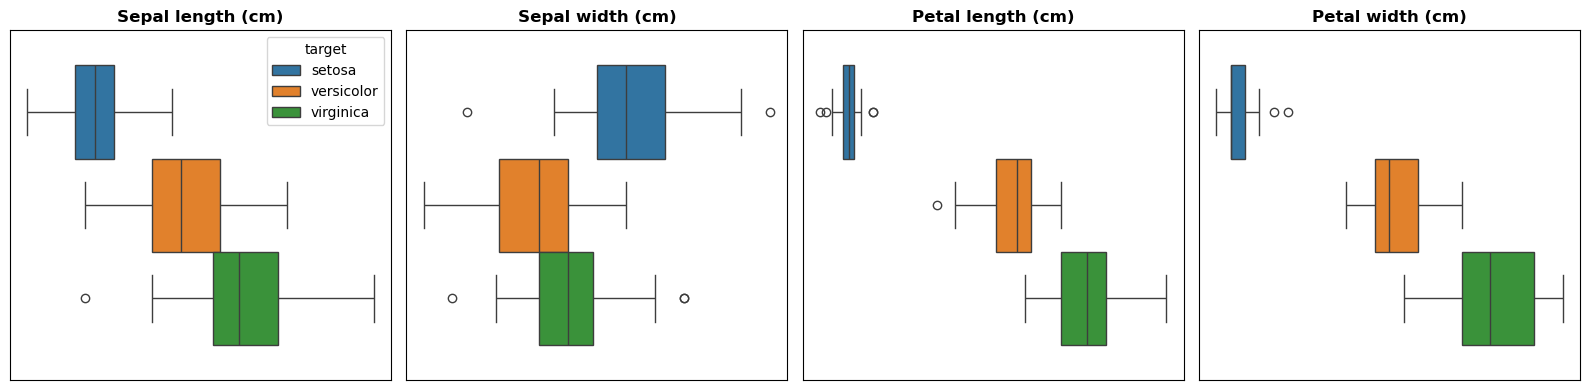

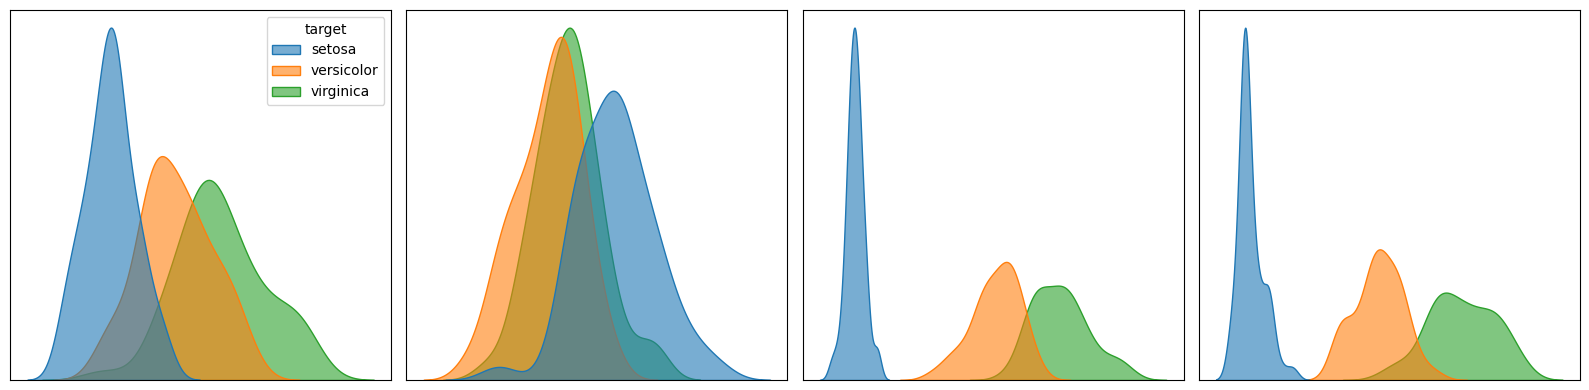

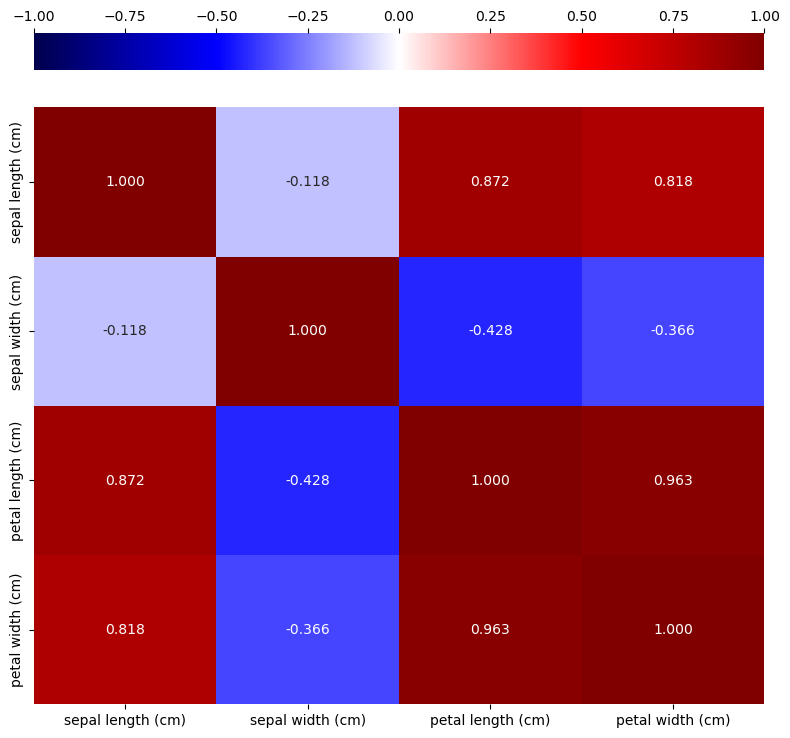

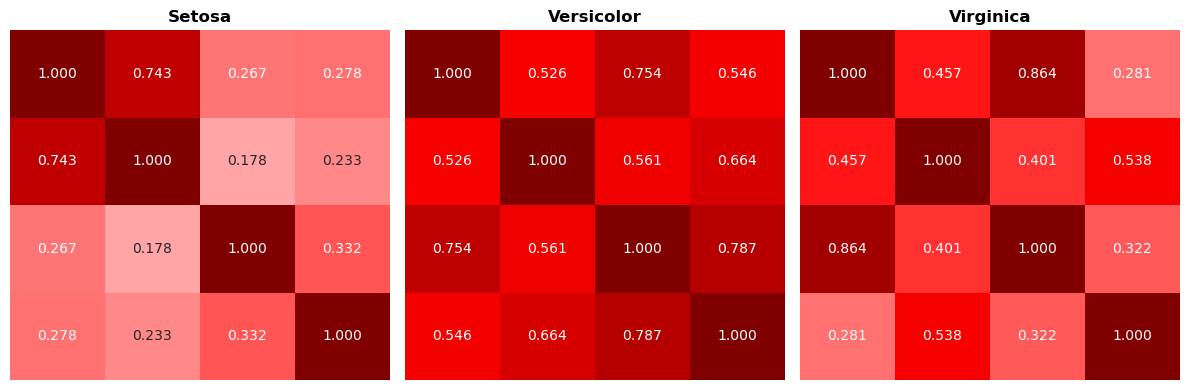

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0           4.503225          2.881532           1.789744          0.114160   
1           5.602862          2.849938           0.758225         -0.048870   
2           4.449964          3.785179           0.473534         -1.727117   
3           4.858372          2.759902           2.243104         -0.062870   
4           5.927822          4.479356           1.437151          1.193244   

   target  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa

Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.012      5.587   
     sepal width (cm)   3.428      2.770     2.974     3.608      2.695   
     petal length (cm)  1.462      4.260     5.552     1.557      4.218   
     petal width (cm)   0.246      1.326     2.026     0.225      1.155   
STD  sepal length (cm)  0.352      0.516     0.636     1.043      0.864   
     sepal width (cm)   0.379      0.314     0.322     1.105      1.106   
     petal length (cm)  0.174      0.470     0.552     1.145      1.139   
     petal width (cm)   0.105      0.198     0.275     0.895      1.059   
MIN  sepal length (cm)  4.300      4.900     4.900     2.342      3.971   
     sepal width (cm)   2.300      2.000     2.200     1.128      0.369   
     petal length (cm)  1.000      3.000     4.500    -1.450      1.829   
     petal width (cm)   0.100      1.000     1.400    -1.981     -0.728   
MAX  sepal length (cm)  5.800      7.000     7.900     7.935      7.192   
     sepal width (cm)   4.400      3.400     3.800     6.500      5.291   
     petal length (cm)  1.900      5.100     6.900     3.640      6.212   
     petal width (cm)   0.600      1.800     2.500     1.943      3.489   
SKEW sepal length (cm)  0.116      0.102     0.114     0.216      0.057   
     sepal width (cm)   0.040     -0.352     0.355     0.159      0.091   
     petal length (cm)  0.103     -0.588     0.533    -0.601     -0.442   
     petal width (cm)   1.216     -0.030    -0.126    -0.178      0.155   
KURT sepal length (cm) -0.346     -0.599    -0.088     0.704     -1.013   
     sepal width (cm)   0.744     -0.448     0.520    -0.080     -0.359   
     petal length (cm)  0.805     -0.074    -0.256    -0.023     -0.733   
     petal width (cm)   1.434     -0.488    -0.661    -0.291     -0.870   
IQR  sepal length (cm)  0.400      0.700     0.675     1.137      1.282   
     sepal width (cm)   0.475      0.475     0.375     1.617      1.455   
     petal length (cm)  0.175      0.600     0.775     1.373      1.645   
     petal width (cm)   0.100      0.300     0.500     1.167      1.726   

                                  
                       virginica  
MEAN sepal length (cm)     6.431  
     sepal width (cm)      3.240  
     petal length (cm)     5.640  
     petal width (cm)      2.074  
STD  sepal length (cm)     1.179  
     sepal width (cm)      1.058  
     petal length (cm)     1.183  
     petal width (cm)      0.976  
MIN  sepal length (cm)     3.874  
     sepal width (cm)      0.775  
     petal length (cm)     3.211  
     petal width (cm)      0.248  
MAX  sepal length (cm)     9.586  
     sepal width (cm)      5.817  
     petal length (cm)     8.584  
     petal width (cm)      4.580  
SKEW sepal length (cm)     0.483  
     sepal width (cm)      0.026  
     petal length (cm)     0.136  
     petal width (cm)      0.715  
KURT sepal length (cm)     0.514  
     sepal width (cm)     -0.027  
     petal length (cm)    -0.415  
     petal width (cm)      0.431  
IQR  sepal length (cm)     1.433  
     sepal width (cm)      1.103  
     petal length (cm)     1.750  
     petal width (cm)      1.135

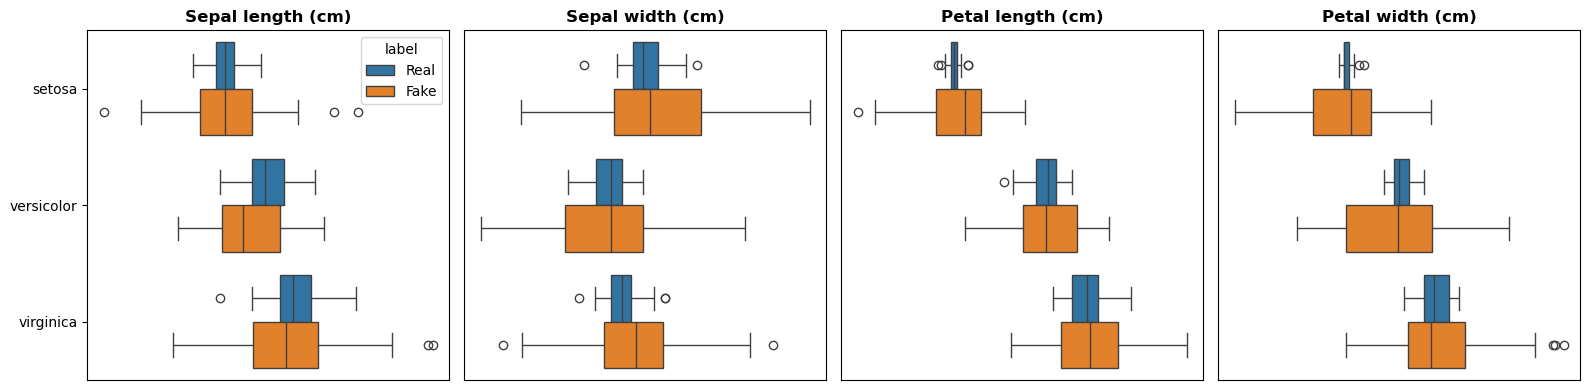

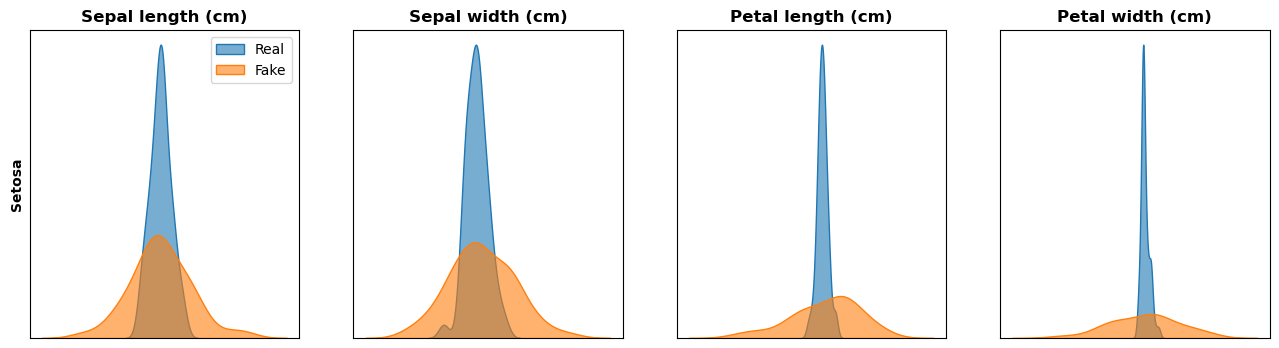

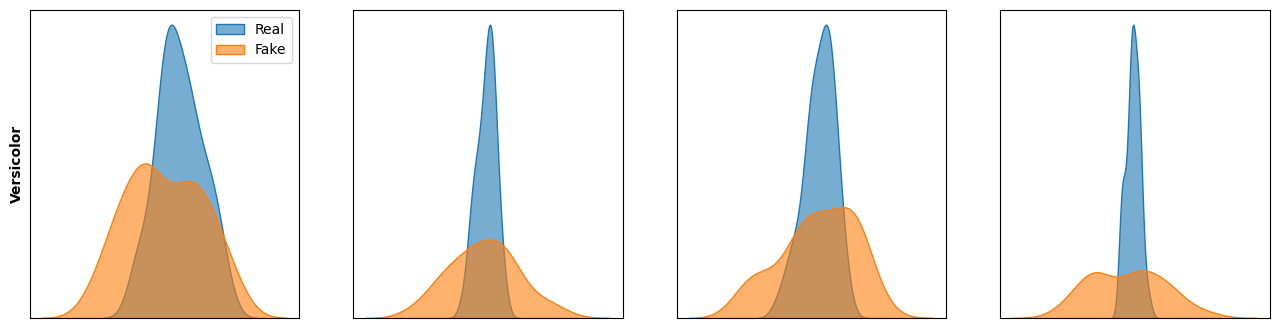

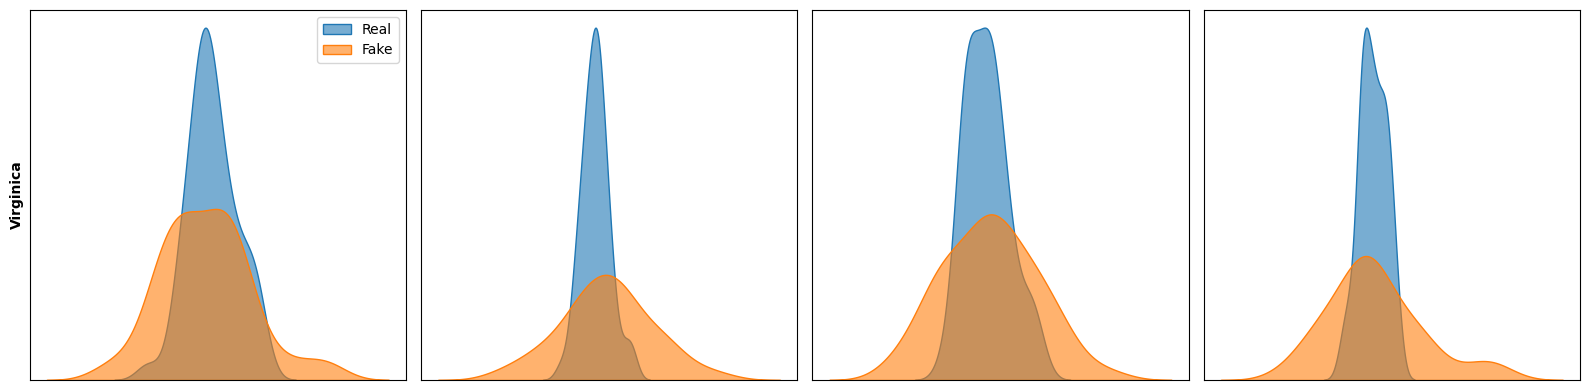

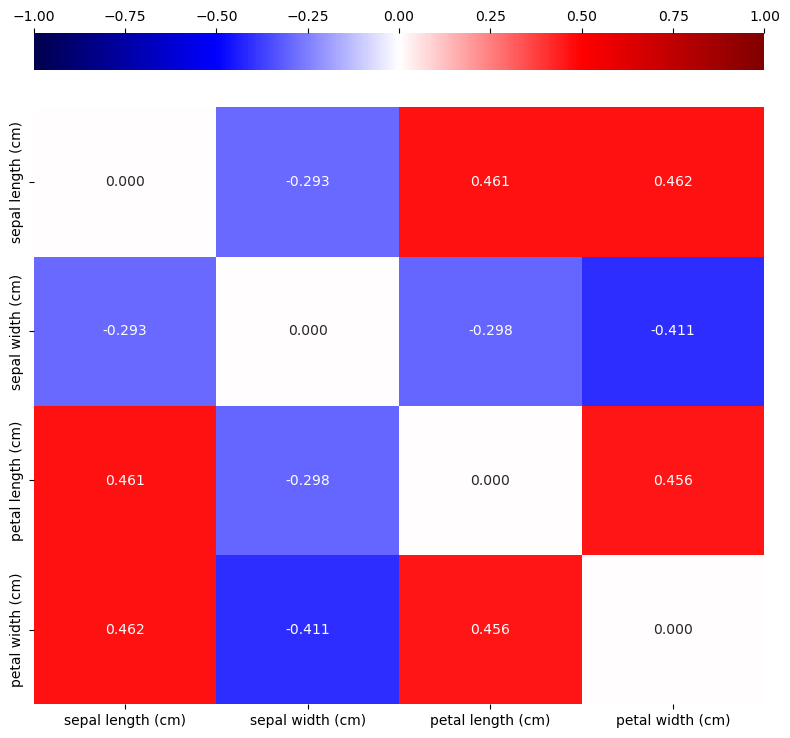

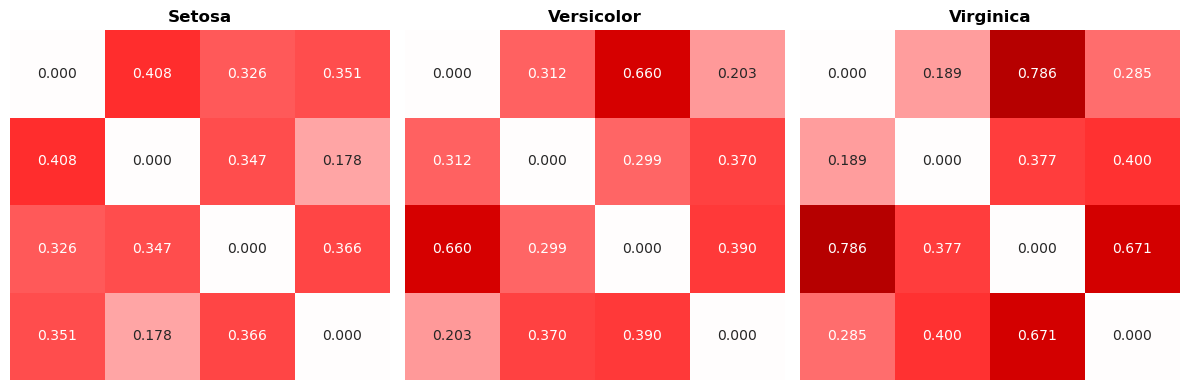

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader.

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE.

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    
set_seed()
vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GAN's nets.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

set_seed()    
gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 810 parameters


Models have approximately the same number of parameters.

We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()
z = torch.randn(150, 4)

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 100 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/500 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 50/500 | Loss: 0.3227
MEAN: [-0.017  0.008 -0.08  -0.051]
STD:  [0.283 0.434 0.225 0.253]
MIN:  [-0.897 -1.855 -0.581 -0.465]
MAX:  [1.615 2.23  0.845 0.815]
SKEW: [ 0.647 -0.348  0.128  0.281]
KURT: [0.931 1.651 0.12  0.177]

Epoch 100/500 | Loss: 0.2992
MEAN: [-0.002  0.003 -0.072 -0.032]
STD:  [0.233 0.374 0.194 0.207]
MIN:  [-0.886 -1.741 -0.572 -0.453]
MAX:  [1.535 2.182 0.8   0.733]
SKEW: [ 0.473 -0.185  0.048  0.104]
KURT: [0.938 1.675 0.115 0.176]

Epoch 200/500 | Loss: 0.2913
MEAN: [-0.01  -0.001 -0.09  -0.051]
STD:  [0.224 0.368 0.182 0.19 ]
MIN:  [-0.877 -1.709 -0.568 -0.448]
MAX:  [1.538 2.174 0.797 0.722]
SKEW: [ 0.505 -0.103  0.089  0.129]
KURT: [0.929 1.672 0.111 0.171]

Epoch 300/500 | Loss: 0.2944
MEAN: [-0.013 -0.007 -0.089 -0.05 ]
STD:  [0.219 0.364 0.179 0.185]
MIN:  [-0.877 -1.717 -0.568 -0.448]
MAX:  [1.541 2.193 0.793 0.718]
SKEW: [ 0.499 -0.089  0.064  0.1  ]
KURT: [0.928 1.676 0.107 0.168]

Epoch 400/500 | Loss: 0.2872
MEAN: [-0.005 -0.006 -0.088 -0.052]

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

Let's train the Conditional GAN.

In [18]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [19]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 100 == 0 or epoch == 500:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7049 | GLoss 0.8255
MEAN: [ 0.033 -0.012 -0.096 -0.011]
STD:  [0.965 0.964 0.969 0.935]
MIN:  [-1.721 -2.333 -1.584 -1.283]
MAX:  [2.438 2.961 1.563 1.514]
SKEW: [ 0.531 -0.075 -0.764 -0.276]
KURT: [-0.946 -0.561 -2.841 -0.99 ]

Epoch 100/500 | DLoss: 0.6766 | GLoss 0.7381
MEAN: [ 1.178  0.847  0.444 -0.09 ]
STD:  [0.281 0.398 0.118 0.102]
MIN:  [ 1.076 -0.597  0.278 -0.11 ]
MAX:  [2.856 2.985 0.897 0.211]
SKEW: [ 0.985 -0.152  0.035  0.228]
KURT: [0.48  1.558 0.045 0.088]

Epoch 200/500 | DLoss: 0.7312 | GLoss 0.6434
MEAN: [ 0.032 -0.386 -0.037 -0.121]
STD:  [ 0.147  0.315  0.119 -0.063]
MIN:  [-0.763 -1.7   -0.207 -0.03 ]
MAX:  [ 1.062  1.716  0.37  -0.073]
SKEW: [-0.217  0.858 -0.129 -0.168]
KURT: [0.87  1.638 0.069 0.152]

Epoch 300/500 | DLoss: 0.6807 | GLoss 0.7064
MEAN: [ 0.41  -0.046 -0.049 -0.151]
STD:  [0.234 0.235 0.136 0.043]
MIN:  [-0.19  -1.107 -0.176 -0.094]
MAX:  [1.713 1.681 0.518 0.068]
SKEW: [ 0.584 -0.189  0.305  0.292]
KURT: [0.878 1.544 0.0

In [20]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

Let's check which of the two results better approximates the actual data using the Kolmogorov-Smirnov test and the Wasserstein Distance.

In [21]:
print(f"KS test for VAE Data:\n{round(utils.calculate_ks_test(real_iris, vae_df), 5)}\n")
print(f"KS test for GAN Data:\n{round(utils.calculate_ks_test(real_iris, gan_df), 5)}\n")

print(f"WD for VAE Data:\n{round(utils.calculate_wasserstein_distance(real_iris, vae_df), 5)}\n")
print(f"WD for GAN Data:\n{round(utils.calculate_wasserstein_distance(real_iris, gan_df), 5)}")

KS test for VAE Data:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.21333  0.00211
1   sepal width (cm)       0.28000  0.00001
2  petal length (cm)       0.33333  0.00000
3   petal width (cm)       0.32000  0.00000

KS test for GAN Data:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.28667  0.00001
1   sepal width (cm)       0.29333  0.00000
2  petal length (cm)       0.33333  0.00000
3   petal width (cm)       0.32000  0.00000

WD for VAE Data:
             Feature  W Distance
0  sepal length (cm)     0.25957
1   sepal width (cm)     0.15692
2  petal length (cm)     0.41564
3   petal width (cm)     0.17683

WD for GAN Data:
             Feature  W Distance
0  sepal length (cm)     0.29182
1   sepal width (cm)     0.15968
2  petal length (cm)     0.63601
3   petal width (cm)     0.20348


As much as all the distances found using the KS test are significant (we have to reject H0 and so the distributions are not from the same population) these appear to be smaller overall for the VAE data. Even when examining Wasserstein's distances, the VAE seems to track the original distributions better. Let's check the Q-Q plots.

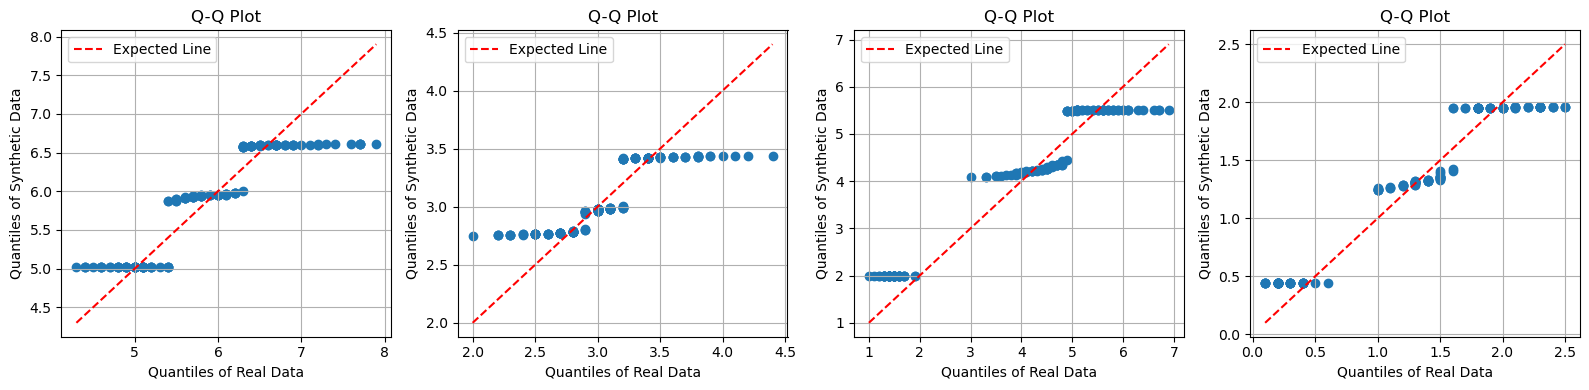

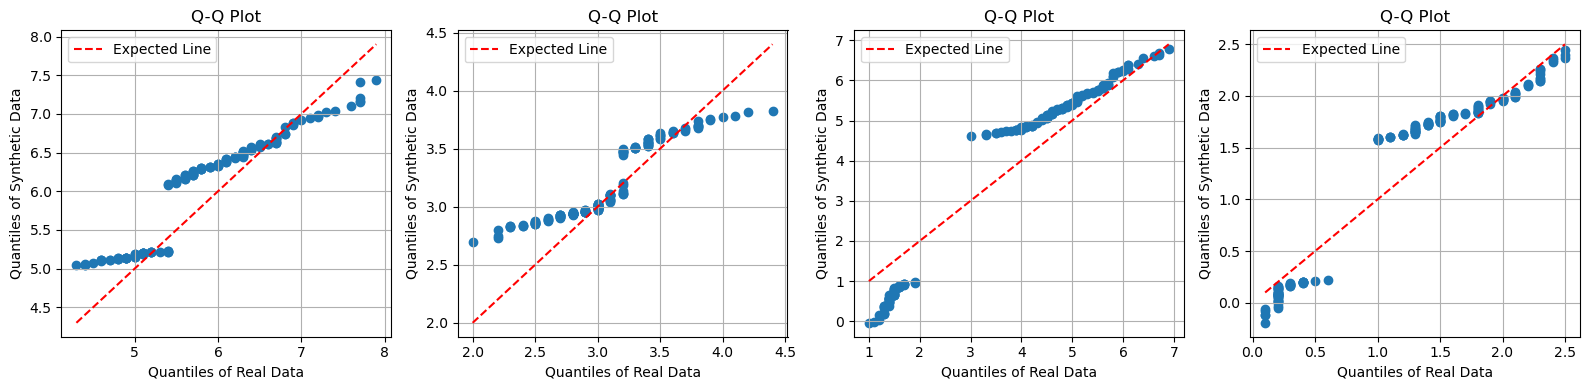

In [22]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

Examining the Q-Q plots there is slightly more overlap for the GAN-generated data. We will examine the data visually to make the final decision.

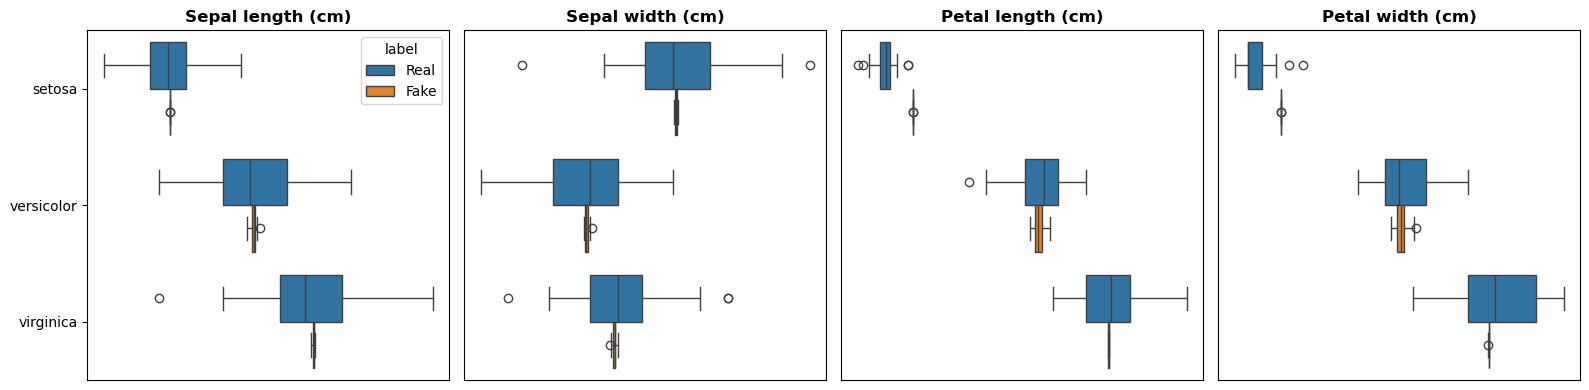

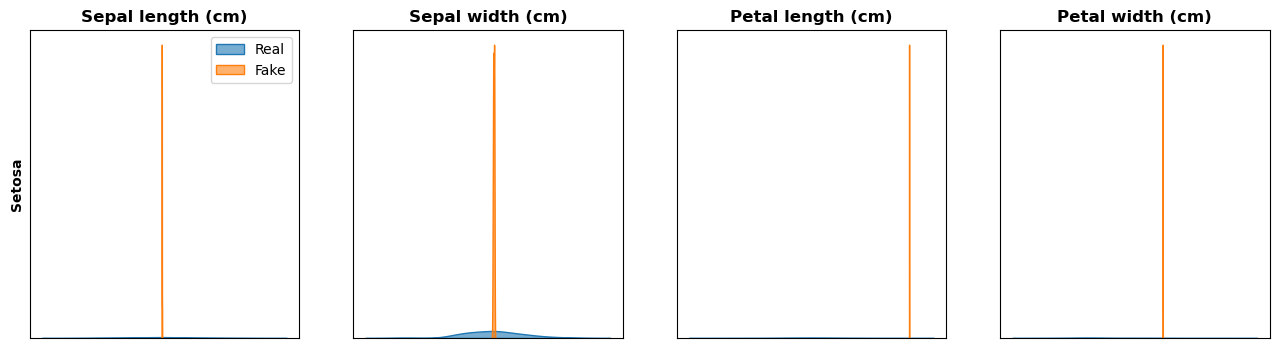

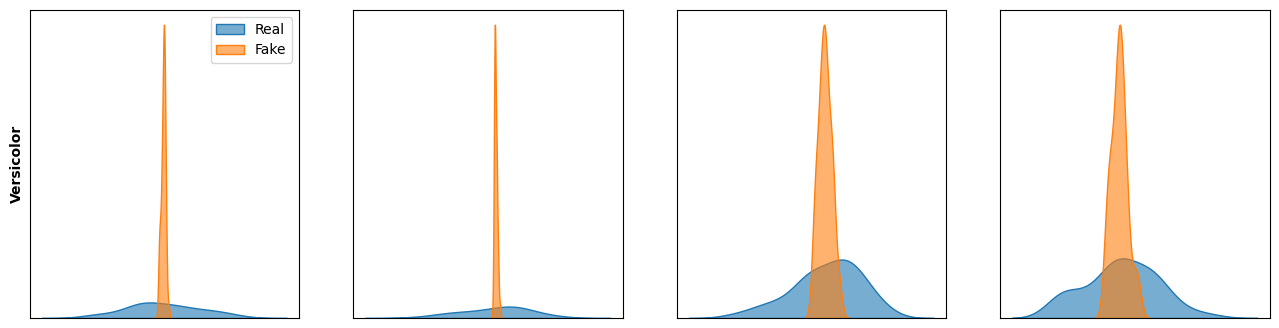

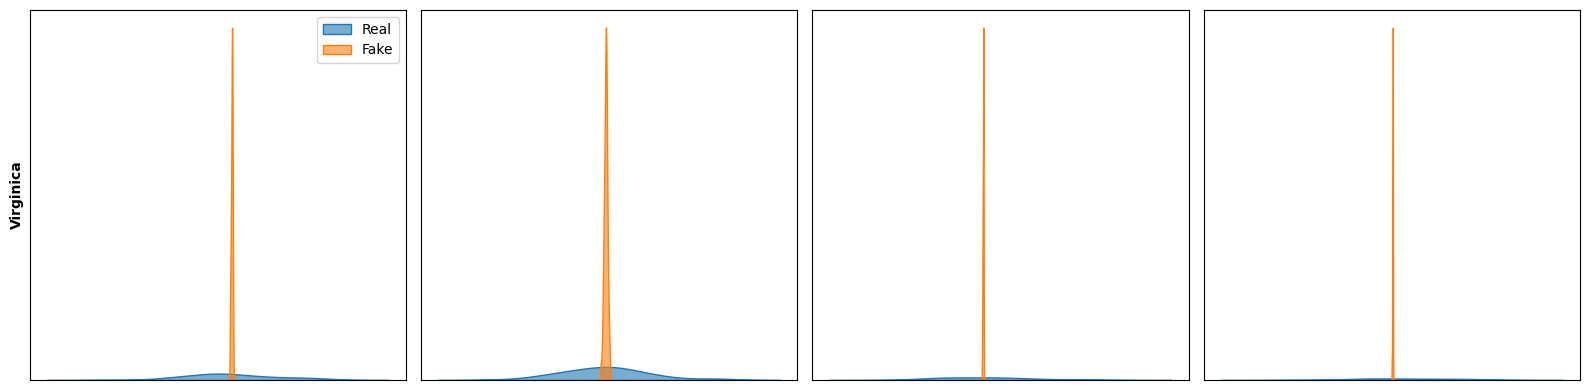

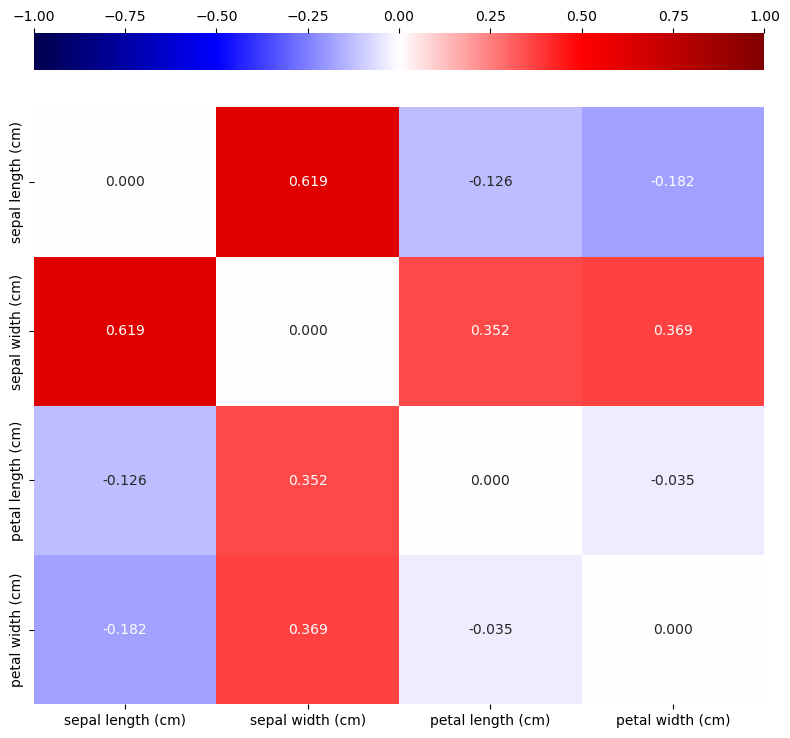

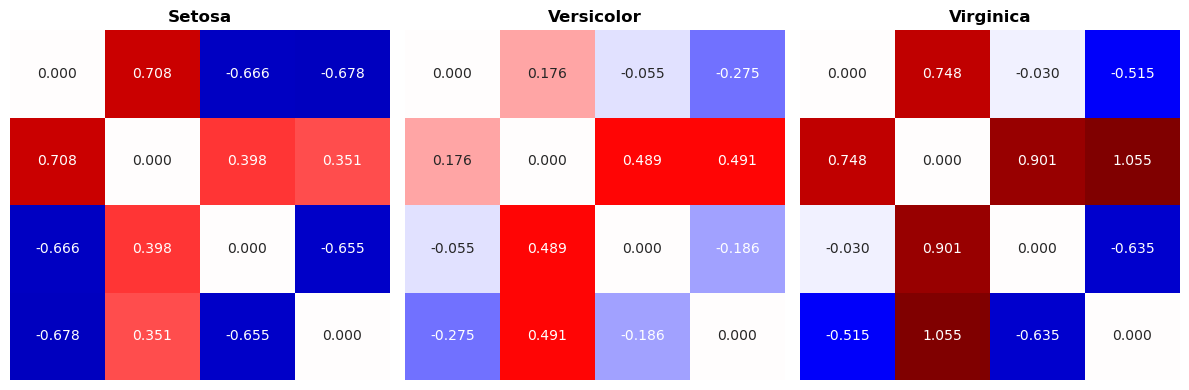

In [23]:
utils.plot_data(real_iris, 'target', vae_df)

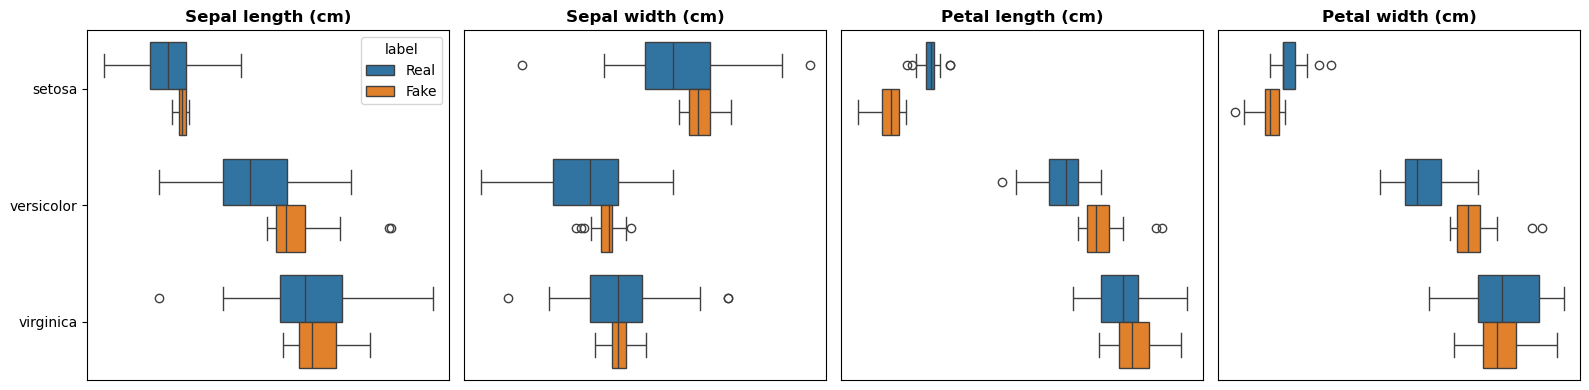

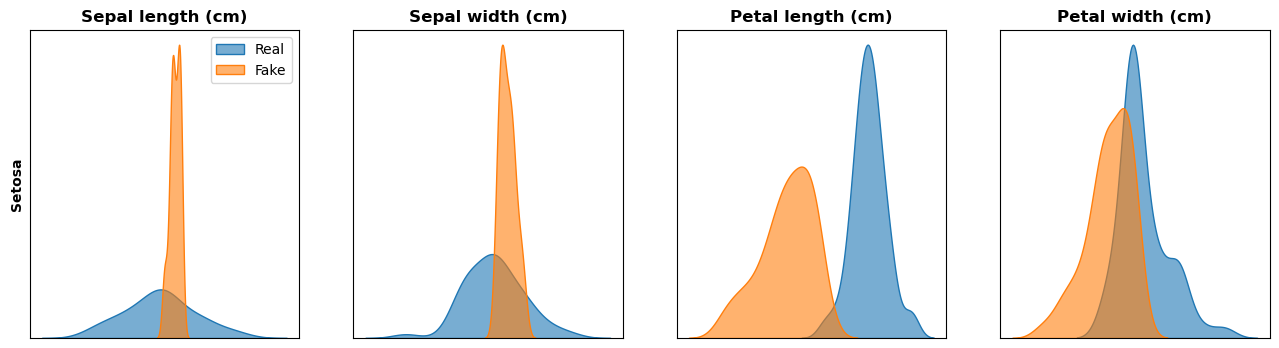

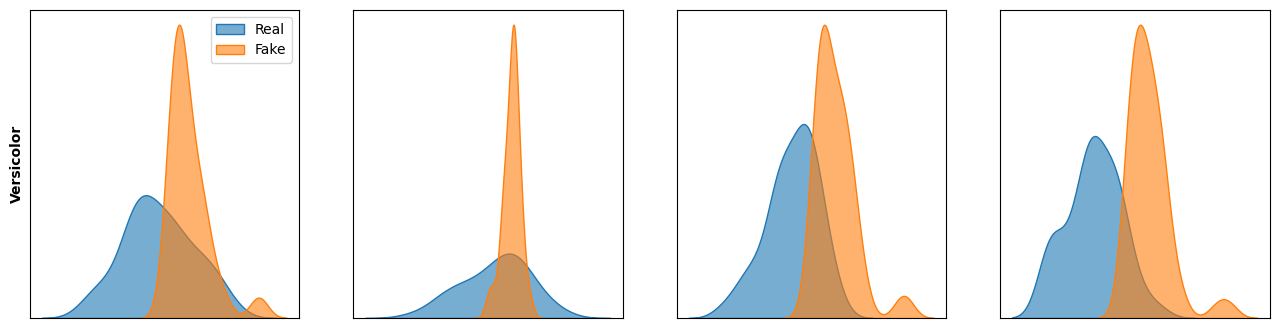

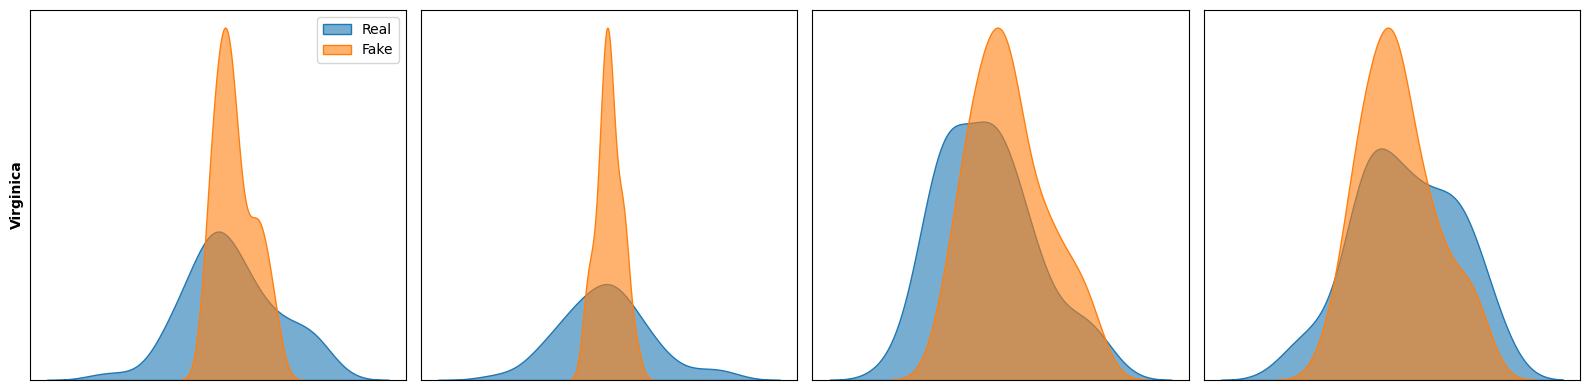

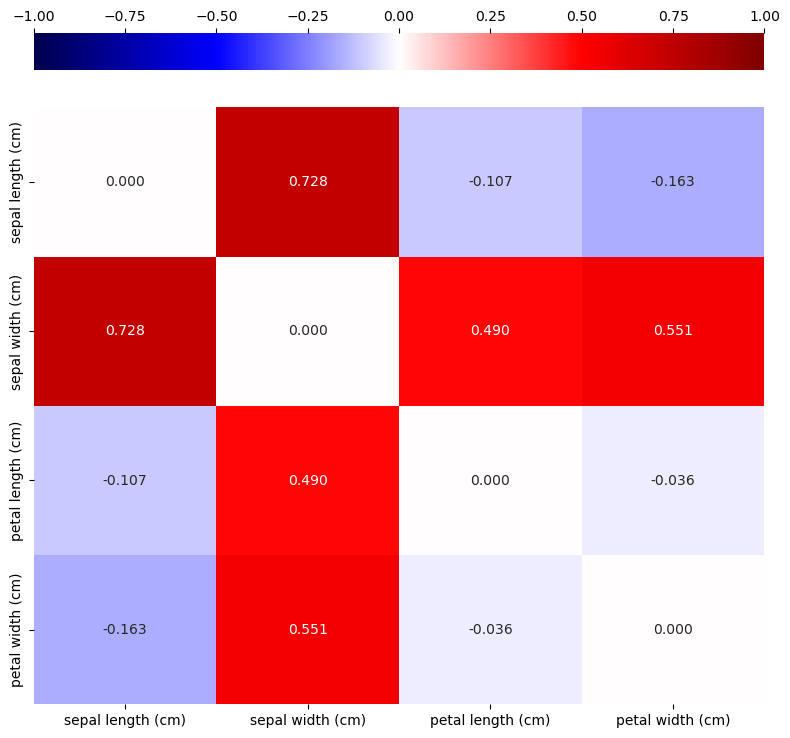

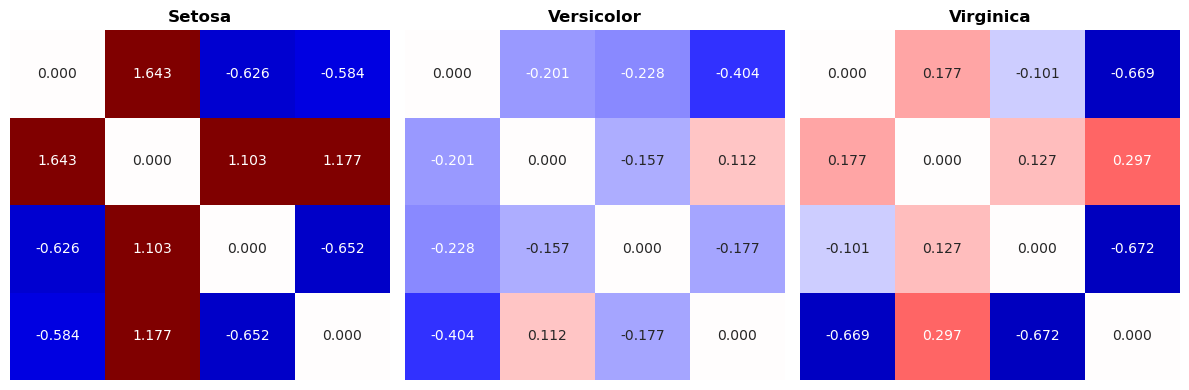

In [24]:
utils.plot_data(real_iris, 'target', gan_df)

As much as it can still be improved GAN seems to be the most suitable architecture for replicating data so the focus of the next steps will be on finding the best architecture.

## Conditional Generative Adversarial Network

In this section, we focus on refining the GAN architecture to maximize its performance in generating synthetic data that closely resembles the real dataset. Our aim is to improve the overlap between the distributions of generated and real data while maintaining computational efficiency. The resulting model will form the basis for subsequent evaluations and applications.

The strating point is a model with 861 parameters. We'll build other 2 bigger versions to prove out which is the best; grid search will also take place on the optimal size of the noise vector for which we will explore the following sizes: 2, 4, 8, 16, 32, and 64.

In [25]:
# Smallest GAN

class Generator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Medium GAN

class Generator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Big GAN

class Generator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

In [26]:
small_gan_dict = {'Generator': Generator1, 'Discriminator': Discriminator1, 
                  'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}
med_gan_dict = {'Generator': Generator2, 'Discriminator': Discriminator2, 
                'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}
big_gan_dict = {'Generator': Generator3, 'Discriminator': Discriminator3, 
                'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}

noise_size = [2**n for n in range(1, 7)]

criterion = nn.BCELoss()


for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for size_idx, size in enumerate(noise_size):
        
        set_seed()
        gen = model['Generator'](input_dim = size, num_classes = 3)
        disc = model['Discriminator'](input_dim = 4, num_classes = 3)
        
        g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
        d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)
        
        model['Noise Vector List'].append(size)
        model['Model Size'].append(sum(p.numel() for p in gen.parameters()))
        
        set_seed()
        z = torch.randn(150, size)
        
        for epoch in tqdm(range(501), desc = f'GAN {model_idx + 1} NV {size}'):
            
            gen_epoch_loss = 0
            disc_epoch_loss = 0
    
            disc.train()
            gen.train()
            
            for data, labels in real_gan_dataloader:
                
                real_data = data
                real_labels = torch.ones(real_data.shape[0], 1)
            
                train_z = torch.randn(real_data.shape[0], size)
                fake_data = gen(train_z, labels)
                fake_labels = torch.zeros(real_data.shape[0], 1)
            
                disc.zero_grad()
                
                real_loss = criterion(disc(real_data, labels), real_labels)
                fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
                d_loss = (real_loss + fake_loss) / 2
                disc_epoch_loss += d_loss.item()
                d_loss.backward()
            
                d_opt.step()
            
                gen.zero_grad()
            
                gen_labels = torch.ones(real_data.shape[0], 1)
            
                g_loss = criterion(disc(fake_data, labels), gen_labels)
                gen_epoch_loss += g_loss.item()
                g_loss.backward()
            
                g_opt.step()
                
            g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
            d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
            
            if epoch == 500:
        
                print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
                with torch.no_grad():
                    gen.eval()
                    gen_z = gen(z, real_gan_dataloader.dataset.label)
                    utils.compare_results(real_gan_dataloader.dataset.data, gen_z)
                    
        model['Dataframes'].append(std_scl.inverse_transform(gen(z, real_gan_dataloader.dataset.label).detach().numpy()))

GAN 1 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6209 | GLoss 0.9150
MEAN: [ 0.111 -0.704 -0.03  -0.01 ]
STD:  [ 0.018 -0.068  0.016 -0.189]
MIN:  [ 0.275 -1.34  -0.094  0.29 ]
MAX:  [ 0.722 -0.468  0.336  0.008]
SKEW: [ 0.514 -0.068  0.262  0.4  ]
KURT: [0.745 0.862 0.054 0.121]


GAN 1 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6592 | GLoss 0.7652
MEAN: [-0.262 -0.268 -0.035 -0.094]
STD:  [ 0.17   0.269 -0.321 -0.124]
MIN:  [-0.901 -1.602  0.591  0.386]
MAX:  [0.554 1.324 0.069 0.074]
SKEW: [ 0.578 -0.32   0.329  0.476]
KURT: [0.709 1.381 0.048 0.094]


GAN 1 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6970 | GLoss 0.6959
MEAN: [-0.584  0.194  0.21   0.155]
STD:  [ 0.458  0.105 -0.168  0.045]
MIN:  [-1.57  -0.66   0.42   0.156]
MAX:  [0.233 0.979 0.19  0.542]
SKEW: [-0.078 -0.019 -0.031  0.124]
KURT: [-0.119  0.795  0.048  0.123]


GAN 1 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.7018 | GLoss 0.6735
MEAN: [0.032 0.235 0.099 0.005]
STD:  [-0.01   0.029  0.032  0.193]
MIN:  [ 0.139  0.199  0.136 -0.17 ]
MAX:  [0.51  1.649 0.494 0.475]
SKEW: [ 0.25   0.336 -0.006 -0.041]
KURT: [0.725 1.051 0.078 0.14 ]


GAN 1 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6634 | GLoss 0.8109
MEAN: [-0.332  0.344  0.054  0.304]
STD:  [ 0.115  0.017  0.022 -0.102]
MIN:  [-0.431  0.8   -0.04   0.638]
MAX:  [ 0.18   0.997  0.316 -0.313]
SKEW: [ 0.345  0.222  0.208 -0.257]
KURT: [ 0.379  0.089  0.066 -0.055]


GAN 1 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6974 | GLoss 0.6930
MEAN: [-0.203 -0.059 -0.021  0.121]
STD:  [ 0.241  0.196 -0.015  0.054]
MIN:  [-0.873 -0.904 -0.108  0.262]
MAX:  [1.079 0.884 0.44  0.465]
SKEW: [ 0.535 -0.048  0.182  0.077]
KURT: [0.819 0.71  0.094 0.099]


GAN 2 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6829 | GLoss 0.7761
MEAN: [-0.799 -0.774 -0.459 -0.205]
STD:  [ 0.003  0.33  -0.304 -0.133]
MIN:  [-1.373 -1.53  -0.193  0.045]
MAX:  [-0.041  1.213 -0.599 -0.013]
SKEW: [-0.016  0.653 -0.104  0.213]
KURT: [0.915 1.005 0.083 0.134]


GAN 2 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6963 | GLoss 0.7200
MEAN: [ 0.004  0.128 -0.187 -0.025]
STD:  [-0.07   0.246  0.041 -0.014]
MIN:  [ 0.079 -1.131 -0.382  0.091]
MAX:  [-0.321  0.577 -0.193  0.04 ]
SKEW: [ 0.074 -0.799 -0.054  0.108]
KURT: [ 0.116 -1.072  0.017  0.087]


GAN 2 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5497 | GLoss 0.8513
MEAN: [-0.273 -0.618 -0.073 -0.067]
STD:  [0.149 0.451 0.089 0.059]
MIN:  [-0.425 -2.081 -0.128  0.083]
MAX:  [0.357 1.299 0.349 0.104]
SKEW: [0.139 0.397 0.011 0.03 ]
KURT: [0.496 0.93  0.088 0.129]


GAN 2 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6488 | GLoss 0.7494
MEAN: [0.002 0.123 0.148 0.003]
STD:  [0.107 0.13  0.109 0.089]
MIN:  [-0.327 -0.569  0.128 -0.089]
MAX:  [0.663 0.792 0.869 0.337]
SKEW: [0.357 0.006 0.218 0.277]
KURT: [0.657 0.422 0.08  0.132]


GAN 2 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6152 | GLoss 0.8094
MEAN: [-0.181  0.032 -0.049  0.13 ]
STD:  [ 0.065  0.028 -0.049  0.118]
MIN:  [-0.301 -0.588 -0.01   0.202]
MAX:  [0.572 0.707 0.469 0.508]
SKEW: [ 0.315 -0.335  0.241  0.233]
KURT: [ 0.614  0.137  0.076 -0.014]


GAN 2 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6222 | GLoss 1.1875
MEAN: [ 0.119 -0.083 -0.029  0.122]
STD:  [0.123 0.135 0.047 0.133]
MIN:  [-0.414 -0.875 -0.143 -0.073]
MAX:  [0.948 1.65  0.294 0.525]
SKEW: [0.239 0.29  0.221 0.169]
KURT: [0.871 1.657 0.052 0.126]


GAN 3 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6680 | GLoss 0.8431
MEAN: [ 0.365 -0.109  0.119 -0.056]
STD:  [-0.015  0.632 -0.062 -0.182]
MIN:  [ 0.412 -1.525  0.548  0.515]
MAX:  [1.598 2.172 0.561 0.159]
SKEW: [0.928 0.502 0.347 0.287]
KURT: [0.841 0.57  0.021 0.137]


GAN 3 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5840 | GLoss 0.9956
MEAN: [ 0.014 -0.229 -0.007 -0.007]
STD:  [-0.114  0.569 -0.168 -0.275]
MIN:  [-0.239 -1.999  0.437  0.903]
MAX:  [-0.153  1.863 -0.626 -0.262]
SKEW: [ 0.122  0.078 -0.231 -0.144]
KURT: [ 0.759  1.358 -0.061  0.11 ]


GAN 3 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6487 | GLoss 0.8209
MEAN: [ 0.119 -0.883 -0.216 -0.55 ]
STD:  [ 0.094 -0.071 -0.001 -0.079]
MIN:  [-0.357 -1.515 -0.175 -0.22 ]
MAX:  [ 0.514 -1.678 -0.117 -0.557]
SKEW: [ 0.164 -0.541  0.054  0.292]
KURT: [ 0.328 -0.389 -0.001  0.109]


GAN 3 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6455 | GLoss 0.8099
MEAN: [0.126 0.074 0.045 0.052]
STD:  [ 0.141 -0.113  0.106  0.042]
MIN:  [-0.048  0.079 -0.078  0.054]
MAX:  [0.801 1.192 0.551 0.306]
SKEW: [0.158 0.554 0.287 0.31 ]
KURT: [0.411 0.945 0.007 0.06 ]


GAN 3 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6830 | GLoss 0.7960
MEAN: [-0.55  -0.739 -0.035 -0.233]
STD:  [-0.103  0.014  0.042 -0.257]
MIN:  [-0.462 -0.321 -0.232 -0.177]
MAX:  [ 0.241  1.118  0.344 -0.619]
SKEW: [ 0.498  1.313 -0.323 -0.339]
KURT: [0.903 0.077 0.14  0.135]


GAN 3 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6885 | GLoss 0.7017
MEAN: [-0.147 -0.534  0.047  0.055]
STD:  [ 0.269 -0.059 -0.016 -0.157]
MIN:  [-0.928 -0.433  0.038  0.426]
MAX:  [1.09  0.605 0.332 0.044]
SKEW: [ 0.329 -0.052  0.024  0.102]
KURT: [0.791 1.394 0.064 0.112]


Let's check models' size.

In [27]:
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Model Size']):
        print(f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]} -> {size/1000}k parameters")

GAN 1 NV 2 -> 0.797k parameters
GAN 1 NV 4 -> 0.861k parameters
GAN 1 NV 8 -> 0.989k parameters
GAN 1 NV 16 -> 1.245k parameters
GAN 1 NV 32 -> 1.757k parameters
GAN 1 NV 64 -> 2.781k parameters
GAN 2 NV 2 -> 3.069k parameters
GAN 2 NV 4 -> 3.197k parameters
GAN 2 NV 8 -> 3.453k parameters
GAN 2 NV 16 -> 3.965k parameters
GAN 2 NV 32 -> 4.989k parameters
GAN 2 NV 64 -> 7.037k parameters
GAN 3 NV 2 -> 11.709k parameters
GAN 3 NV 4 -> 11.965k parameters
GAN 3 NV 8 -> 12.477k parameters
GAN 3 NV 16 -> 13.501k parameters
GAN 3 NV 32 -> 15.549k parameters
GAN 3 NV 64 -> 19.645k parameters


As the size of the noise vector changes, the dimensions, in terms of parameters of each architecture remain quite similar.

In [28]:
ks_results_df = []
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Dataframes']):
        ks_results = utils.calculate_ks_test(real_iris, pd.DataFrame(size))
        ks_statistics = ks_results['KS Statistic']
        ks_results_df.append({'Model': f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]}", **ks_statistics})
comaprisons_df = pd.DataFrame(ks_results_df).set_index('Model')
comaprisons_df.columns = real_iris.columns[:-1]
comaprisons_df['avg_ks'] = comaprisons_df.mean(1)
comaprisons_df.sort_values('avg_ks').style.background_gradient(cmap = 'Reds')

In [29]:
wd_results_df = []
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Dataframes']):
        wd_results = utils.calculate_wasserstein_distance(real_iris, pd.DataFrame(size))
        wd_statistics = wd_results['W Distance']
        wd_results_df.append({'Model': f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]}", **wd_statistics})
comaprisons_df = pd.DataFrame(wd_results_df).set_index('Model')
comaprisons_df.columns = real_iris.columns[:-1]
comaprisons_df['avg_wd'] = comaprisons_df.mean(1)
comaprisons_df.sort_values('avg_wd').style.background_gradient(cmap = 'Reds')

The final match is between the best model considering the KS test, a big GAN with a noise vector of 16, and the best according to the wasserstein distance, a medium GAN with a noise vector of 16.
Considering that the performance of all three architectures with a vector of size 16 reaches an acceptable threshold, we can conclude that this is the optimal size of the noise vector.

By examining the Q-Q plots we will see which architecture produces the best results.

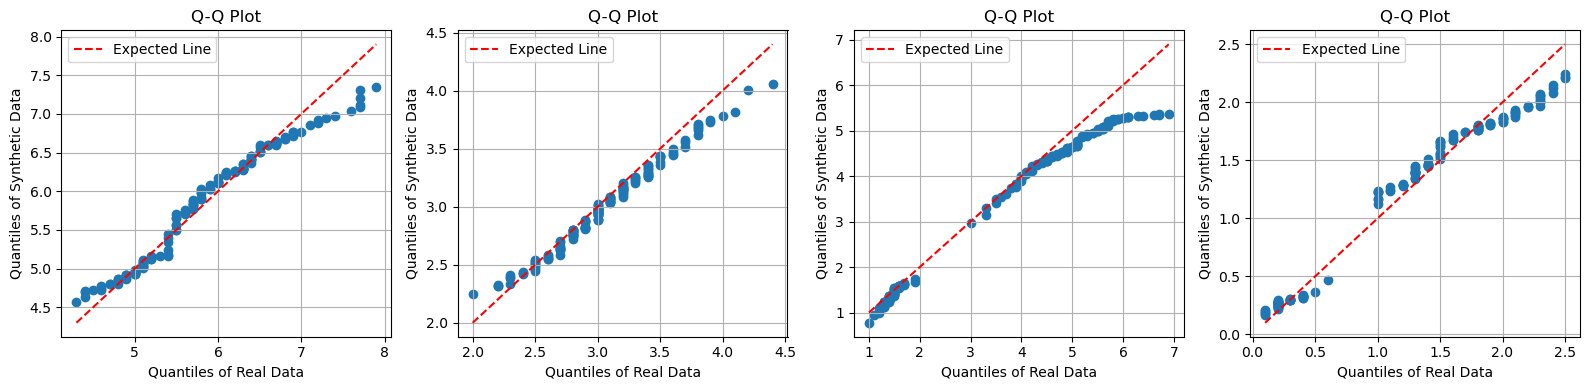

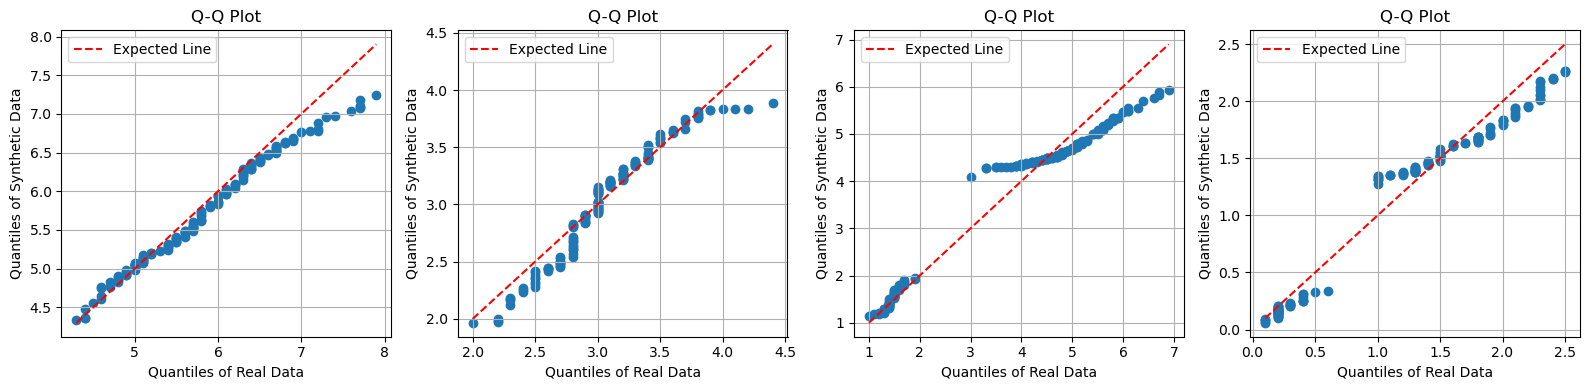

In [30]:
gan2_16nv_df = pd.DataFrame(med_gan_dict['Dataframes'][3])
gan2_16nv_df['target'] = y
gan2_16nv_df['target'] = gan2_16nv_df['target'].map({i: species[i] for i in range(len(species))})
gan2_16nv_df.columns = real_iris.columns

gan3_16nv_df = pd.DataFrame(big_gan_dict['Dataframes'][3])
gan3_16nv_df['target'] = y
gan3_16nv_df['target'] = gan3_16nv_df['target'].map({i: species[i] for i in range(len(species))})
gan3_16nv_df.columns = real_iris.columns

for dataframe in [gan2_16nv_df, gan3_16nv_df]:
    utils.plot_quantiles(real_iris, dataframe)

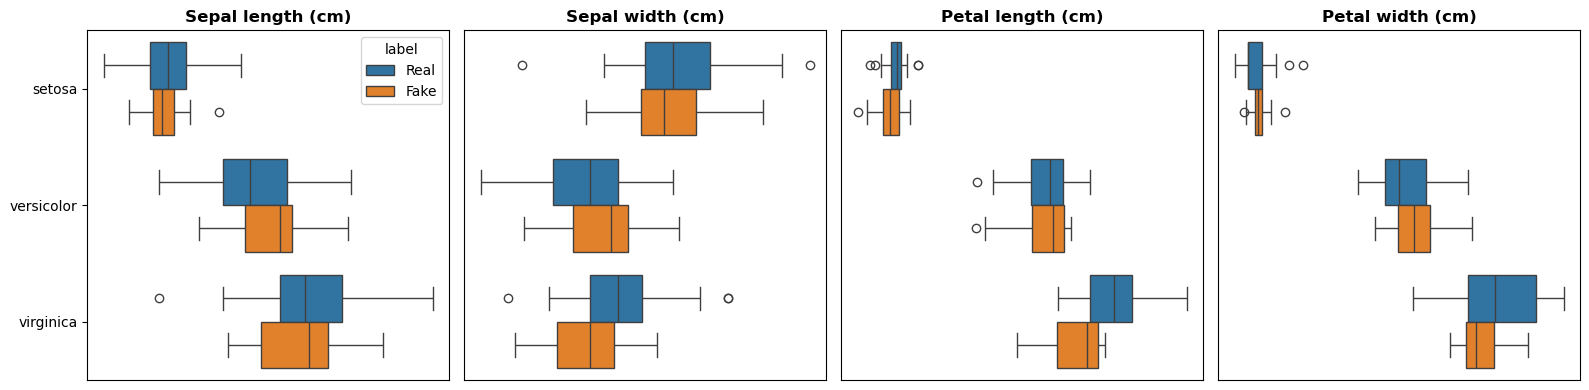

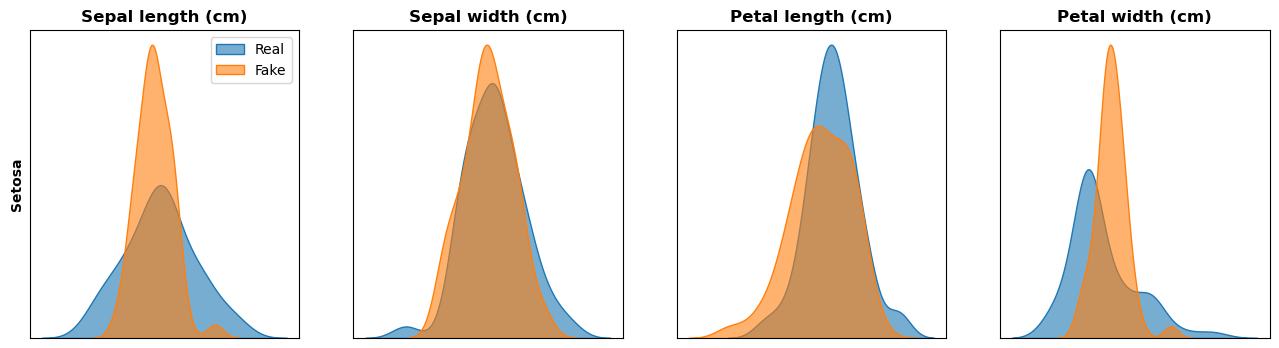

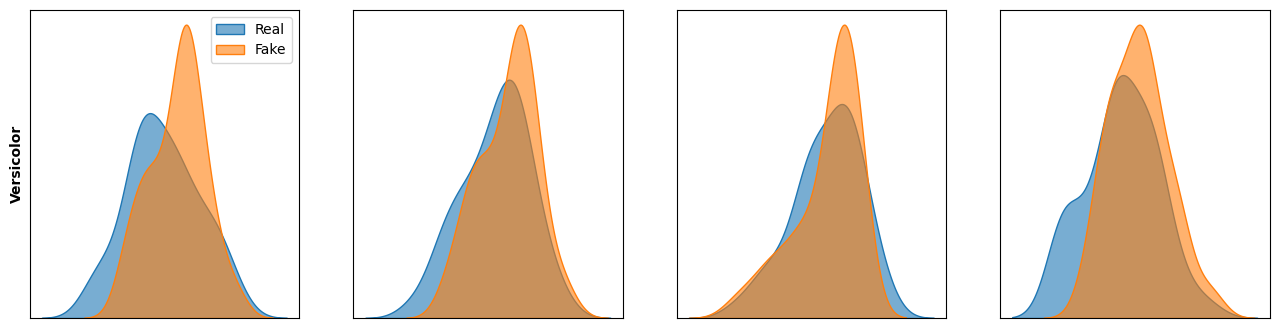

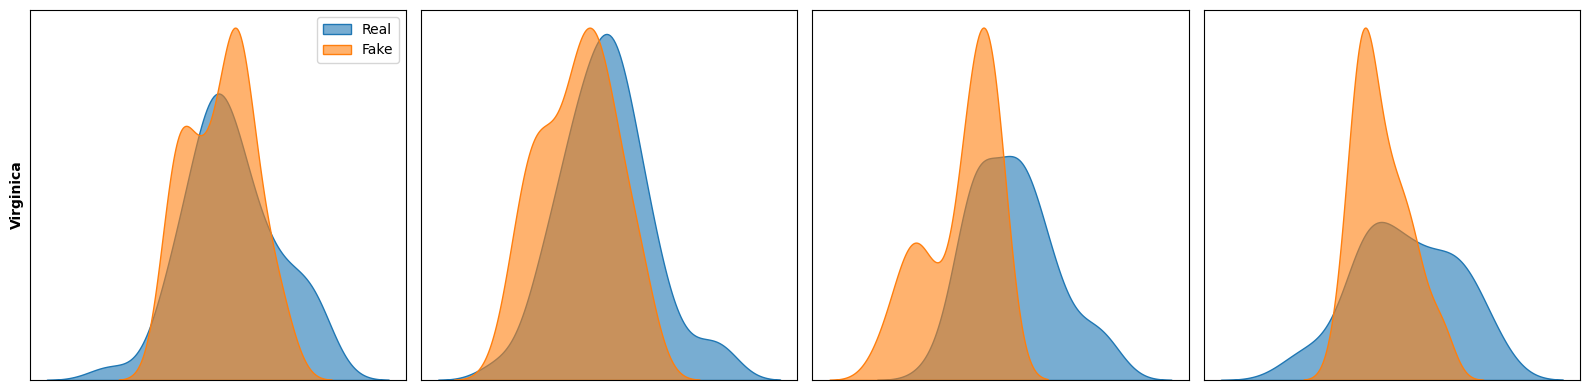

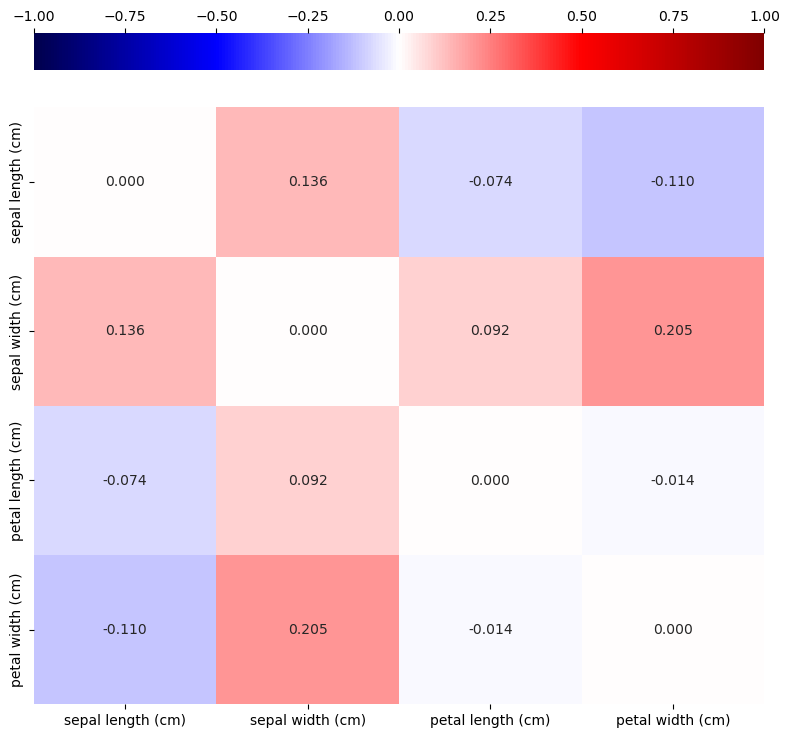

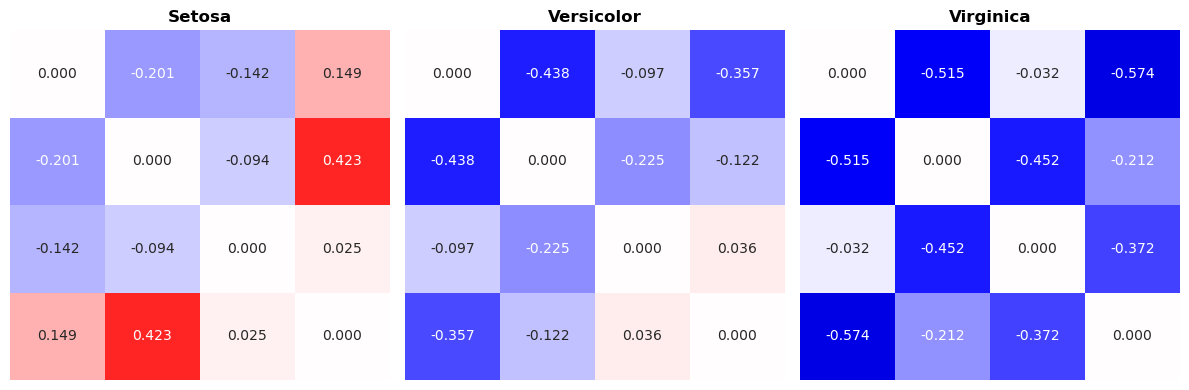

In [31]:
utils.plot_data(real_iris, 'target', gan2_16nv_df)

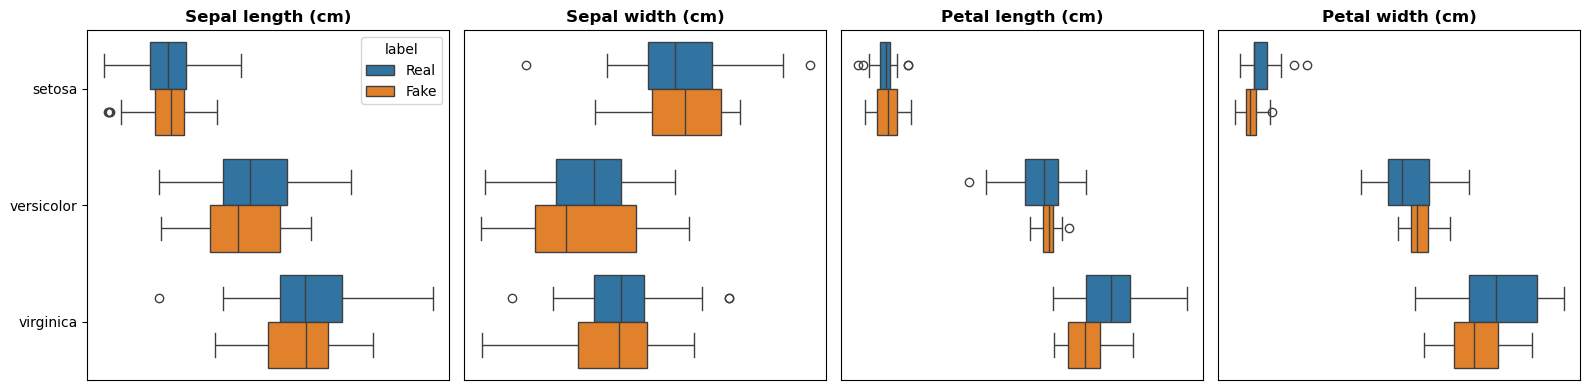

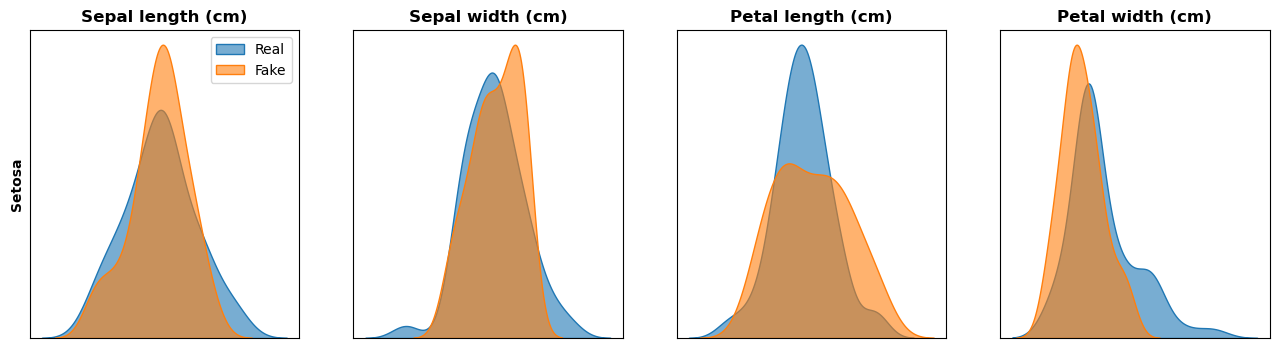

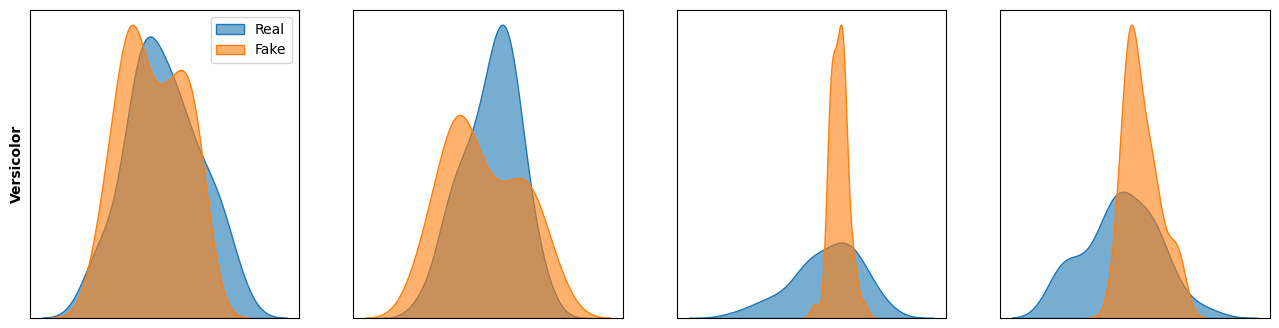

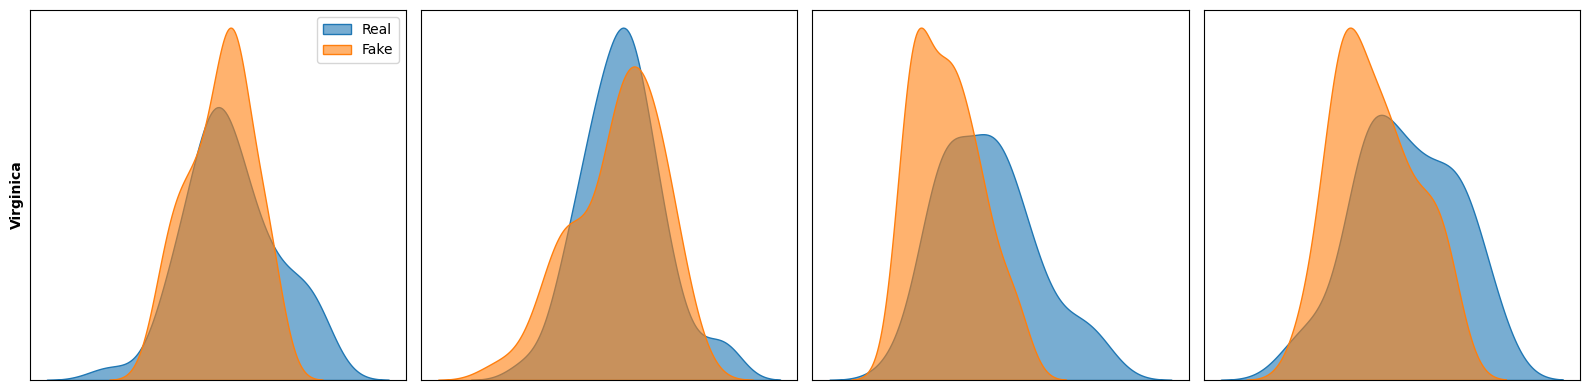

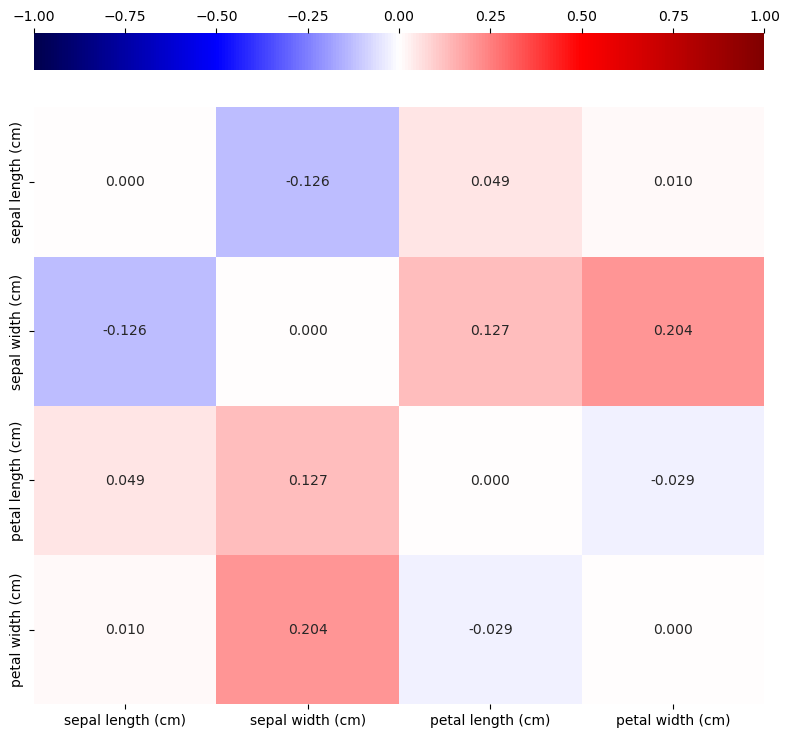

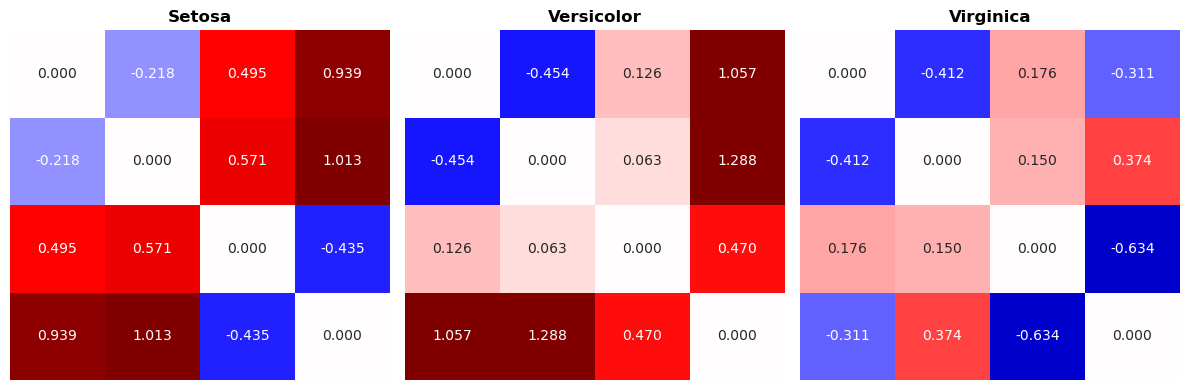

In [32]:
utils.plot_data(real_iris, 'target', gan3_16nv_df)

In [33]:
print(f"Medium GAN: {((real_iris.select_dtypes('number').corr() - gan2_16nv_df.select_dtypes('number').corr()).abs().sum().sum()):.4f}")
print(f"Big GAN: {((real_iris.select_dtypes('number').corr() - gan3_16nv_df.select_dtypes('number').corr()).abs().sum().sum()):.4f}")

Medium GAN: 1.2608
Big GAN: 1.0914


In [34]:
print('Medium GAN correlation differences:\n')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {((real_iris[real_iris['target'] == target].select_dtypes('number').corr() - gan2_16nv_df[gan2_16nv_df['target'] == target].select_dtypes('number').corr()).abs().sum().sum()):.4f}")
print('\nBig GAN correlation differences:\n')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {((real_iris[real_iris['target'] == target].select_dtypes('number').corr() - gan3_16nv_df[gan3_16nv_df['target'] == target].select_dtypes('number').corr()).abs().sum().sum()):.4f}")

Medium GAN correlation differences:

Setosa: 2.0704
Versicolor: 2.5484
Virginica: 4.3110

Big GAN correlation differences:

Setosa: 7.3449
Versicolor: 6.9146
Virginica: 4.1133


Analyzing the performance of both models with statistical and graphical methods, they seem to show rather similar performance overall. Analyzing the differences between the class-specific correlations, the average architecture shows a greater ability to reproduce 2 out of 3 classes. For this the **medium architecture with a noise vector of size 16** will be chosen.

## Fine Tuning the CGAN
First of all let's set a new class for our GAN nets using the best noise vector size.

In [35]:
noise_dim = 16

class Generator(nn.Module):
    def __init__(self, input_dim, num_classes, noise_std = 0.1):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.noise_std = noise_std
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = x + self.noise_std * torch.randn_like(x)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes, noise_std = 0.1):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.noise_std = noise_std
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = x + self.noise_std * torch.randn_like(x)
        x = self.model(x)
        return x

set_seed()
gen = Generator(input_dim = noise_dim, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Discriminator parameters: {sum(p.numel() for p in disc.parameters())/1000}k')

Generator parameters: 3.965k
Discriminator parameters: 3.146k


In [36]:
epochs = 10001
min_lr = 1e-10
g_lr = 2e-4
d_lr = 1e-4
verbose = 20

In [37]:
g_opt = torch.optim.Adam(gen.parameters(), lr = g_lr)
d_opt = torch.optim.Adam(disc.parameters(), lr = d_lr)

g_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(g_opt, eta_min = min_lr, T_max = epochs)
d_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(d_opt, eta_min = min_lr, T_max = epochs)
#
gen_grad_norm = torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm = 0.5)
disc_grad_norm = torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm = 0.5)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, noise_dim)

In [38]:
for epoch in tqdm(range(epochs), desc = f'Training GAN'):
            
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
    
        train_z = torch.randn(real_data.shape[0], noise_dim)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        d_real_output = disc(real_data, labels).detach()
        d_fake_output_before = disc(fake_data.detach(), labels).detach()
    
        D_x = d_real_output.mean().item()
        D_G_z_before = d_fake_output_before.mean().item()
    
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
    
        disc_grad_norm = torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm=1.0)
        d_opt.step()
        
        d_fake_output_after = disc(fake_data.detach(), labels).detach()
        D_G_z_after = d_fake_output_after.mean().item()
    
        gen.zero_grad()
    
        gen_labels = torch.ones(real_data.shape[0], 1)
    
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        gen_grad_norm = torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
        g_opt.step()
        
    g_scheduler.step()
    d_scheduler.step()
    
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % (epochs // verbose) == 0 or epoch == epochs - 1:

        print(f'\nEpoch {epoch}/{epochs - 1} | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f} | D(x): {D_x:.4f} | D(G(x)): {D_G_z_before:.4f}/{D_G_z_after:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training GAN:   0%|          | 0/10001 [00:00<?, ?it/s]


Epoch 0/10000 | DLoss: 0.6960 | GLoss 0.7825 | D(x): 0.4575 | D(G(x)): 0.4572/0.4575
MEAN: [ 0.176  0.19  -0.23   0.151]
STD:  [0.983 0.979 0.983 0.985]
MIN:  [-1.636 -2.161 -1.744 -1.236]
MAX:  [2.599 3.211 1.48  1.808]
SKEW: [ 0.545  0.728 -0.492  0.079]
KURT: [-1.14  -0.863 -2.139 -2.061]

Epoch 500/10000 | DLoss: 0.4888 | GLoss 1.1767 | D(x): 0.5710 | D(G(x)): 0.3220/0.3254
MEAN: [0.778 0.039 1.23  0.971]
STD:  [-0.618 -0.97  -0.419 -0.377]
MIN:  [0.964 1.176 1.85  1.247]
MAX:  [0.441 0.862 0.504 0.478]
SKEW: [-0.307  0.985 -0.776 -0.698]
KURT: [ 0.842  1.6   -0.086  0.117]

Epoch 1000/10000 | DLoss: 0.6773 | GLoss 0.6614 | D(x): 0.5476 | D(G(x)): 0.5067/0.5212
MEAN: [0.183 0.469 0.225 0.302]
STD:  [0.35  0.126 0.165 0.229]
MIN:  [-0.49  -0.769  0.039  0.069]
MAX:  [1.969 2.204 1.107 1.176]
SKEW: [0.956 0.027 0.329 0.472]
KURT: [0.841 1.62  0.065 0.126]

Epoch 1500/10000 | DLoss: 0.6845 | GLoss 0.7344 | D(x): 0.4878 | D(G(x)): 0.4754/0.4785
MEAN: [ 0.241 -0.556  0.007 -0.112]
STD:

In [39]:
#set_seed()
#gen_z = gen(z, real_gan_dataloader.dataset.label)
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = real_iris['target']
gan_df.columns = real_iris.columns

In [40]:
round(utils.calculate_ks_test(real_iris, gan_df),5).style.background_gradient(cmap = 'Reds')

In [41]:
utils.calculate_wasserstein_distance(real_iris, gan_df).style.background_gradient(cmap = 'Reds')

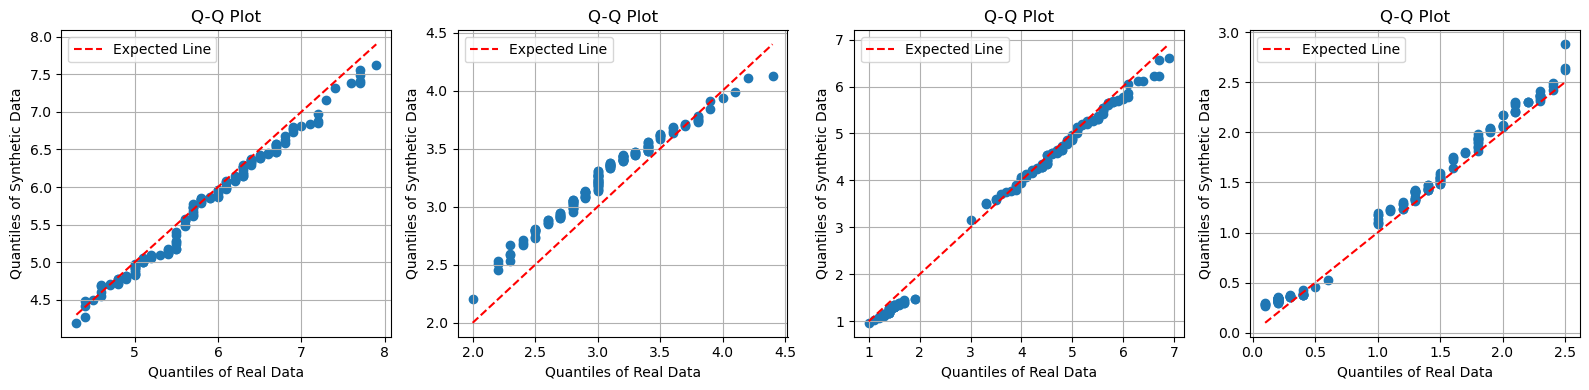

In [42]:
utils.plot_quantiles(real_iris, gan_df)

In [43]:
print(f"Overall correlations difference: {(real_iris.select_dtypes('number').corr() - gan_df.select_dtypes('number').corr()).sum().sum():.4f}")

for specie in real_iris['target'].unique():
    print(f"{specie.capitalize()}: {(real_iris[real_iris['target'] == specie].select_dtypes('number').corr() - gan_df[real_iris['target'] == specie].select_dtypes('number').corr()).sum().sum():.4f}")

Overall correlations difference: -1.5877
Setosa: -0.6013
Versicolor: -3.7111
Virginica: -5.4439


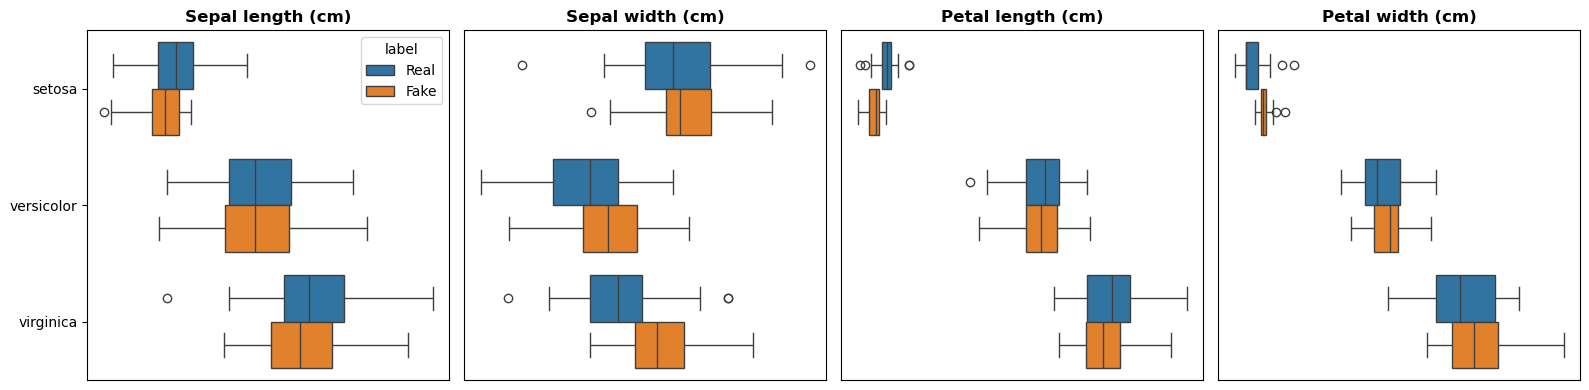

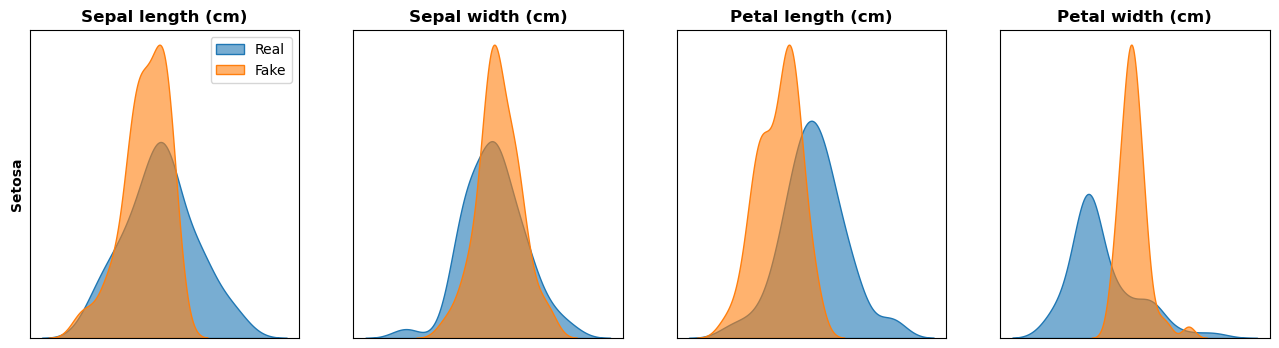

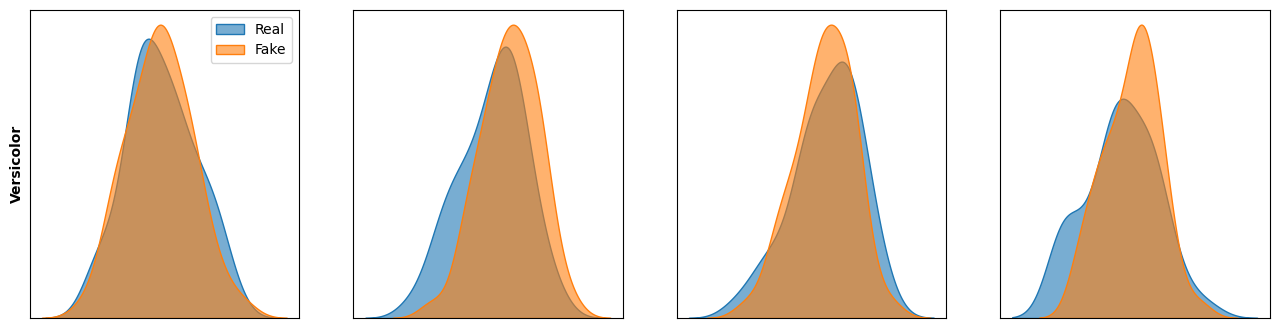

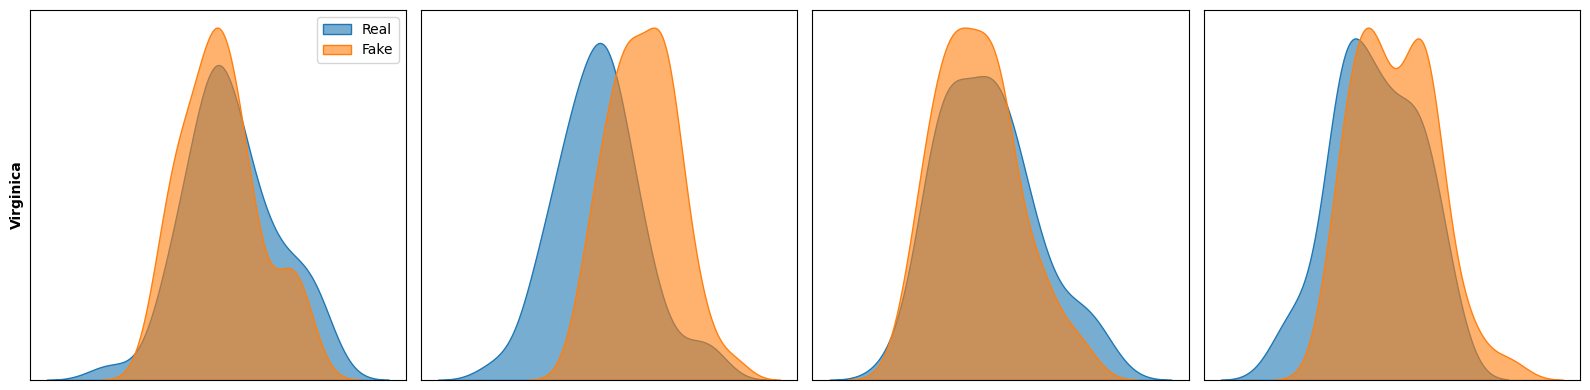

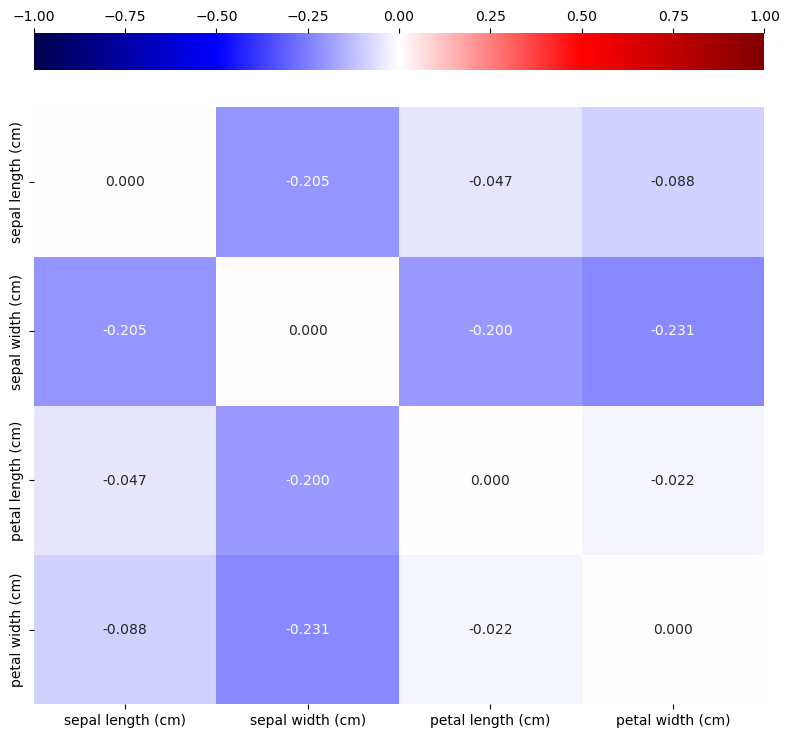

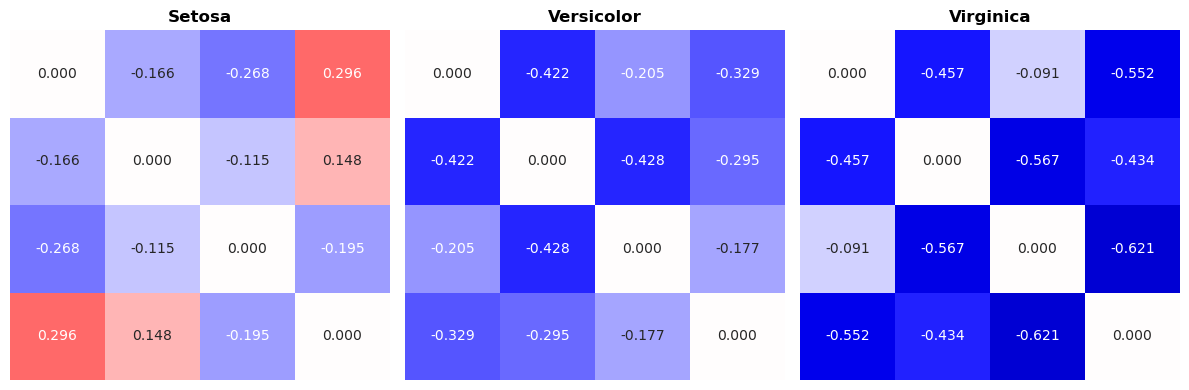

In [44]:
utils.plot_data(real_iris, 'target', gan_df)

It is well known that neural networks perform best when they exploit large amounts of data; having no additional data to train the model we can approach the problem from another perspective by performing feature engeeneering to increase the complexity of the task.

Taking advantage of Samy Baladram's work we will create some features of his [Iris Extended Dataset](https://www.kaggle.com/datasets/samybaladram/iris-dataset-extended).

Specifically:
$$ \text{Sepal Area} \rightarrow \text{Sepal Length} \times \text{Sepal Width} $$

$$ \text{Petal Area} \rightarrow \text{Petal Length} \times \text{Petal Width} $$

$$ \text{Sepal Aspect Ratio} \rightarrow \frac{\text{Sepal Length}}{\text{Sepal Width}} $$

$$ \text{Petal Aspect Ratio} \rightarrow \frac{\text{Petal Length}}{\text{Petal Width}} $$

$$ \text{Sepal to Petal Length Ratio} \rightarrow \frac{\text{Sepal Length}}{\text{Petal Length}} $$

$$ \text{Sepal to Petal Width Ratio} \rightarrow \frac{\text{Sepal Width}}{\text{Petal Width}} $$

In [45]:
aug_iris = real_iris.copy()

aug_iris['sepal area'] = aug_iris['sepal length (cm)'] * aug_iris['sepal width (cm)']
aug_iris['petal area'] = aug_iris['petal length (cm)'] * aug_iris['petal width (cm)']
aug_iris['sepal aspect ratio'] = aug_iris['sepal length (cm)'] / aug_iris['sepal width (cm)']
aug_iris['petal aspect ratio'] = aug_iris['petal length (cm)'] / aug_iris['petal width (cm)']
aug_iris['sepal petal length ratio'] = aug_iris['sepal length (cm)'] / aug_iris['petal length (cm)']
aug_iris['sepal petal width ratio'] = aug_iris['sepal width (cm)'] / aug_iris['petal width (cm)']

target_column = aug_iris.pop('target')
aug_iris['target'] = target_column
aug_iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   sepal area  petal area  sepal aspect ratio  petal aspect ratio  \
0       17.85        0.28            1.457143                 7.0   
1       14.70        0.28            1.633333                 7.0   
2       15.04        0.26            1.468750                 6.5   
3       14.26        0.30            1.483871                 7.5   
4       18.00        0.28            1.388889                 7.0   

   sepal petal length ratio  sepal petal width ratio  target  
0                  3.642857                     17.5  setosa  
1                  3.500000                     15.0  setosa  
2                  3.615385                     16.0  setosa  
3                  3.066667                     15.5  setosa  
4                  3.571429                     18.0  setosa

Now we have to preprocess the new real data.

In [46]:
X_aug, y = aug_iris.select_dtypes('number'), y

aug_std_scl = StandardScaler()
X_aug_scld = aug_std_scl.fit_transform(X_aug)

aug_gan_dataset = IrisDataset(X_aug_scld, y)
aug_gan_dataloader = DataLoader(aug_gan_dataset, batch_size = 32, shuffle= True)

for batch in aug_gan_dataloader:
    gan_batch = batch
    break
    
print(gan_batch[0].shape)
print(gan_batch[1].shape)

torch.Size([32, 10])
torch.Size([32])


Now let's check new GAN's models dimensions.

In [47]:
data_dim = aug_iris.select_dtypes('number').shape[1]

# Smallest GAN

class Generator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, data_dim),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Medium GAN

class Generator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, data_dim),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Big GAN

class Generator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, data_dim),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

In [48]:
small_gan_dict = {'Generator': Generator1, 'Discriminator': Discriminator1, 
                  'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}
med_gan_dict = {'Generator': Generator2, 'Discriminator': Discriminator2, 
                'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}
big_gan_dict = {'Generator': Generator3, 'Discriminator': Discriminator3, 
                'Generator List': [], 'Noise Vector List': [], 'Model Size':[], 'Dataframes':[]}

noise_size = [2**n for n in range(1, 7)]

criterion = nn.BCELoss()


for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for size_idx, size in enumerate(noise_size):
        
        set_seed()
        gen = model['Generator'](input_dim = size, num_classes = 3)
        disc = model['Discriminator'](input_dim = data_dim, num_classes = 3)
        
        g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
        d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)
        
        model['Noise Vector List'].append(size)
        model['Model Size'].append(sum(p.numel() for p in gen.parameters()))
        
        set_seed()
        z = torch.randn(150, size)
        
        for epoch in tqdm(range(501), desc = f'GAN {model_idx + 1} NV {size}'):
            
            gen_epoch_loss = 0
            disc_epoch_loss = 0
    
            disc.train()
            gen.train()
            
            for data, labels in aug_gan_dataloader:
                
                real_data = data
                real_labels = torch.ones(real_data.shape[0], 1)
            
                train_z = torch.randn(real_data.shape[0], size)
                fake_data = gen(train_z, labels)
                fake_labels = torch.zeros(real_data.shape[0], 1)
            
                disc.zero_grad()
                
                real_loss = criterion(disc(real_data, labels), real_labels)
                fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
                d_loss = (real_loss + fake_loss) / 2
                disc_epoch_loss += d_loss.item()
                d_loss.backward()
            
                d_opt.step()
            
                gen.zero_grad()
            
                gen_labels = torch.ones(real_data.shape[0], 1)
            
                g_loss = criterion(disc(fake_data, labels), gen_labels)
                gen_epoch_loss += g_loss.item()
                g_loss.backward()
            
                g_opt.step()
                
            g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
            d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
            
            if epoch == 500:
        
                print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
                with torch.no_grad():
                    gen.eval()
                    gen_z = gen(z, aug_gan_dataloader.dataset.label)
                    utils.compare_results(aug_gan_dataloader.dataset.data, gen_z)
                    
        model['Dataframes'].append(aug_std_scl.inverse_transform(gen(z, aug_gan_dataloader.dataset.label).detach().numpy()))

GAN 1 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6873 | GLoss 0.7215
MEAN: [ 0.147  0.102 -0.099  0.014  0.089 -0.362  0.06   0.111  0.253  0.024]
STD:  [0.008 0.036 0.034 0.062 0.138 0.044 0.016 0.343 0.115 0.186]
MIN:  [ 0.517 -0.232 -0.069 -0.079 -0.007 -0.263  0.349 -0.035  0.582  0.447]
MAX:  [0.721 0.448 0.468 0.566 1.044 0.007 1.033 2.574 1.595 2.91 ]
SKEW: [ 0.591 -0.497  0.273  0.286 -0.112  0.214  0.733  1.342  0.279  1.098]
KURT: [ 0.466 -0.275  0.045  0.14   0.757  0.261  0.199  6.339  0.559  4.35 ]


GAN 1 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5193 | GLoss 1.1051
MEAN: [ 0.107  0.042 -0.072  0.23   0.109  0.307 -0.024 -0.127  0.235  0.193]
STD:  [0.206 0.562 0.148 0.049 0.642 0.223 0.228 0.117 0.011 0.039]
MIN:  [-0.455 -1.415 -0.27   0.381 -1.471  0.365 -0.344  0.654  0.581  1.095]
MAX:  [1.643 2.314 0.877 0.917 2.727 1.195 1.475 2.771 1.367 2.943]
SKEW: [0.992 0.064 0.396 0.548 0.176 0.412 0.631 2.158 0.332 1.25 ]
KURT: [0.87  1.252 0.078 0.103 1.232 0.201 0.549 7.005 0.561 4.348]


GAN 1 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5474 | GLoss 1.0186
MEAN: [ 0.245 -0.312  0.435 -0.381  0.09   0.394  0.066 -0.089  0.118  0.108]
STD:  [-0.009 -0.15  -0.182 -0.004 -0.388 -0.035  0.076 -0.02   0.028  0.225]
MIN:  [ 0.007  0.336  0.646 -0.187  1.714  0.656 -0.016  0.329  0.245  0.329]
MAX:  [ 0.473 -0.32   0.154 -0.352  0.497  0.605  1.295  2.49   0.989  3.164]
SKEW: [0.081 0.156 0.037 0.378 0.692 0.296 0.71  1.606 0.203 1.184]
KURT: [ 4.550e-01  3.130e-01 -3.400e-02 -6.000e-03  1.288e+00  3.070e-01
  4.840e-01  7.110e+00  3.990e-01  4.380e+00]


GAN 1 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6238 | GLoss 0.9310
MEAN: [-0.05  -0.072 -0.036  0.027 -0.226 -0.065  0.271  0.12  -0.121  0.182]
STD:  [ 0.074  0.229 -0.069 -0.228  0.232  0.013  0.154  0.169 -0.065 -0.041]
MIN:  [-0.629 -0.901  0.008  0.408 -0.931  0.272  0.432  0.268  0.153  0.719]
MAX:  [ 1.095  1.197  0.26  -0.056  1.938  0.652  1.856  3.114  0.636  2.575]
SKEW: [ 0.408  0.219 -0.077  0.009  0.478  0.249  0.874  1.762  0.19   1.165]
KURT: [0.92  0.754 0.084 0.134 1.834 0.276 0.095 7.151 0.413 4.238]


GAN 1 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6815 | GLoss 0.7544
MEAN: [ 0.011 -0.244 -0.273  0.175 -0.177 -0.123  0.051  0.047  0.057 -0.158]
STD:  [-0.068 -0.137 -0.2   -0.332  0.053 -0.191  0.096  0.266 -0.099  0.076]
MIN:  [-0.274  0.243 -0.2    0.755  0.774  0.218 -0.097 -0.069  0.171 -0.006]
MAX:  [ 0.309  0.756 -0.436 -0.381  1.023 -0.278  0.609  3.108  0.766  2.433]
SKEW: [ 0.31   0.354 -0.2    0.029  0.858 -0.123  0.441  1.568  0.155  0.966]
KURT: [0.76  0.766 0.09  0.119 0.128 0.257 0.386 7.141 0.554 4.24 ]


GAN 1 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5946 | GLoss 0.9925
MEAN: [-0.258 -0.049 -0.257 -0.046 -0.063 -0.118 -0.023 -0.061 -0.065 -0.157]
STD:  [ 0.191  0.126 -0.022 -0.025  0.128 -0.164  0.318  0.136 -0.192 -0.064]
MIN:  [-0.773 -0.713 -0.275  0.025 -0.479  0.245 -0.261  0.132  0.084  0.159]
MAX:  [ 0.459  0.862 -0.242 -0.103  1.599 -0.668  1.547  2.81   0.686  2.414]
SKEW: [ 0.171 -0.155  0.053  0.121  0.54   0.056  0.682  1.601  0.162  1.029]
KURT: [ 0.292  0.502 -0.064 -0.016  1.482 -0.189  0.143  7.11   0.557  4.41 ]


GAN 2 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5016 | GLoss 1.2696
MEAN: [ 0.013 -0.031  0.02  -0.155  0.181  0.051 -0.028 -0.489  0.133 -0.599]
STD:  [ 0.252 -0.027 -0.044 -0.041  0.186 -0.137 -0.176 -0.012 -0.289 -0.145]
MIN:  [-0.576  0.069 -0.011  0.179  0.837  0.701  0.436 -0.167  0.634 -0.23 ]
MAX:  [ 0.142  0.499  0.031 -0.386  1.868  0.199 -0.911  1.576  0.783  1.557]
SKEW: [-0.166  0.173  0.169 -0.116  1.619  0.188 -0.01   1.697  0.279  1.021]
KURT: [-0.21   0.806  0.06  -0.19  -1.311  0.234 -0.28   6.875  0.572  4.322]


GAN 2 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.4300 | GLoss 2.1380
MEAN: [-0.263  0.443  0.055 -0.13   0.039  0.167  0.007  0.273 -0.031  0.103]
STD:  [0.07  0.107 0.046 0.063 0.065 0.067 0.182 0.383 0.211 0.293]
MIN:  [-0.465  1.225  0.088  0.045  0.452  0.526  0.163  0.627 -0.068  0.371]
MAX:  [-0.511  1.543  0.082 -0.296  0.949  0.492  1.125  3.39   1.125  3.011]
SKEW: [-0.111  0.527 -0.209 -0.096  0.323  0.199  0.765  1.587  0.16   1.062]
KURT: [-0.069 -0.285 -0.048 -0.101  0.7    0.112  0.063  6.788  0.411  4.191]


GAN 2 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.2341 | GLoss 11.8332
MEAN: [ 2.504  0.983  2.598  2.343  2.425  2.677  0.931  0.707 -1.828  0.102]
STD:  [-2.322 -0.486 -2.69  -2.128 -2.44  -2.253 -0.306 -1.267 -1.81   0.286]
MIN:  [7.142 0.943 8.736 7.536 6.526 8.357 1.832 3.795 0.097 0.127]
MAX:  [ 1.588  1.127  1.158  1.182  2.312  2.167  1.947  1.808 -5.081  3.239]
SKEW: [1.037 0.258 0.478 0.633 1.17  1.044 0.445 2.557 0.212 1.049]
KURT: [ 0.742  1.269 -0.156 -0.123  2.24   0.07   0.447  7.044  0.326  4.368]


GAN 2 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.3565 | GLoss 1.3621
MEAN: [-0.155 -0.203 -0.355 -0.137 -0.014  0.012 -0.113  0.237  0.023  0.147]
STD:  [0.507 0.081 0.178 0.294 0.288 0.279 0.267 0.298 0.244 0.054]
MIN:  [-1.248 -0.144 -0.414 -0.23  -0.256  0.071 -0.612  0.154 -0.093  0.595]
MAX:  [1.261 1.767 0.274 0.56  2.414 0.865 1.345 3.187 1.321 2.737]
SKEW: [-0.071  1.063  0.087 -0.006  1.344  0.231  0.603  1.612  0.14   1.065]
KURT: [ 0.601  0.647 -0.095 -0.09   0.735  0.126  0.562  6.944  0.421  4.252]


GAN 2 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5811 | GLoss 0.9826
MEAN: [-0.155 -0.239 -0.266  0.368 -0.324  0.039  0.558 -0.011  0.271  0.126]
STD:  [ 0.11   0.117 -0.155 -0.192  0.164  0.181  0.161  0.491  0.017  0.008]
MIN:  [-0.06  -0.318  0.239  1.596 -0.581  0.256  0.661 -0.246  0.48   0.491]
MAX:  [ 1.03   0.984 -0.3    0.404  1.874  0.702  2.235  3.278  1.128  2.579]
SKEW: [ 0.557  0.504 -0.13   0.223  0.675 -0.074  0.75   1.582  0.214  1.032]
KURT: [ 0.611  0.441 -0.062 -0.186  1.803  0.104  0.339  6.966  0.459  4.256]


GAN 2 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5274 | GLoss 0.9822
MEAN: [ 0.283 -0.044  0.173  0.069  0.19   0.008  0.317  0.023  0.031 -0.135]
STD:  [0.361 0.048 0.094 0.058 0.23  0.103 0.192 0.142 0.009 0.064]
MIN:  [-0.277 -0.677  0.119  0.225 -0.289  0.285  0.163  0.159  0.256 -0.029]
MAX:  [ 0.955  1.27   0.549 -0.056  1.667  0.276  1.563  2.785  0.894  2.506]
SKEW: [-0.128  0.19   0.122 -0.053  0.468  0.003  0.683  1.609  0.136  0.981]
KURT: [-0.365  1.279 -0.037 -0.118  1.133 -0.08   0.211  7.067  0.435  4.32 ]


GAN 3 NV 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.6110 | GLoss 1.2606
MEAN: [ 0.056  0.212  0.174 -0.167  0.287  0.03   0.121  0.243  0.124  0.099]
STD:  [ 0.289  0.241  0.167 -0.182  0.191 -0.101  0.151  0.14   0.287  0.331]
MIN:  [ 0.442  0.162  0.357  0.303  2.272  0.997  0.047  0.433 -0.007  0.032]
MAX:  [ 1.229  1.547  0.987 -0.448  2.721  0.41   1.297  2.389  1.584  2.73 ]
SKEW: [ 0.903 -0.043  0.221 -0.138  2.211  0.206  0.245  1.477  0.298  0.768]
KURT: [ 4.000e-02  5.700e-02  3.000e-03  5.100e-02 -4.295e+00  1.640e-01
  4.450e-01  6.536e+00  4.600e-01  3.654e+00]


GAN 3 NV 4:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.4346 | GLoss 1.2697
MEAN: [ 0.163 -0.041 -0.233 -0.293  0.383 -0.159 -0.082 -0.024  0.549  0.188]
STD:  [0.219 0.632 0.176 0.128 0.752 0.042 0.431 0.406 0.29  0.45 ]
MIN:  [-0.139 -1.964 -0.269 -0.321 -1.098  0.125 -0.548 -0.3    0.754  0.027]
MAX:  [1.409 1.983 0.42  0.054 3.405 0.412 1.503 2.973 1.849 3.308]
SKEW: [ 0.708 -0.48  -0.01  -0.147  0.828  0.129  0.214  1.537  0.571  1.063]
KURT: [0.801 0.731 0.023 0.104 0.6   0.294 0.408 6.983 0.516 4.293]


GAN 3 NV 8:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5050 | GLoss 2.5741
MEAN: [-1.496 -0.56  -0.705 -1.115 -1.744 -0.768 -0.296  0.487  1.073  1.02 ]
STD:  [-0.068 -0.268  0.573  0.388 -0.668  0.247  0.016  0.893  0.575  0.519]
MIN:  [-0.683 -0.303 -1.149 -1.148 -0.379 -0.487 -0.901 -0.051  0.755  1.128]
MAX:  [-0.418  0.604  0.198 -0.377 -0.741 -0.294 -0.987  4.621  2.946  4.715]
SKEW: [ 0.857 -0.02   0.103  0.59   0.184 -0.051 -0.851  2.128  0.638  2.256]
KURT: [ 0.362  1.483 -0.757 -0.348  2.05  -0.082 -0.649  6.392  0.436  4.369]


GAN 3 NV 16:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.4542 | GLoss 1.2383
MEAN: [-0.092 -0.226  0.14   0.195 -0.211  0.318  0.06  -0.001 -0.032 -0.179]
STD:  [-0.076  0.023 -0.253 -0.036  0.166 -0.311 -0.006  0.195 -0.147 -0.01 ]
MIN:  [ 0.216  0.736  1.26   0.853 -0.311  1.878  0.298 -0.095  0.086 -0.017]
MAX:  [0.357 1.15  0.5   0.565 2.175 0.859 0.464 2.522 0.254 1.943]
SKEW: [0.903 0.994 0.499 0.535 1.305 1.005 0.475 1.31  0.086 0.896]
KURT: [ 0.343 -0.621 -0.308 -0.185  0.961 -0.214  0.057  6.399  0.366  4.095]


GAN 3 NV 32:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.5735 | GLoss 1.1435
MEAN: [-0.086 -0.824  0.453  0.178 -0.6    0.091  0.51  -0.25   0.067 -0.106]
STD:  [ 0.07  -0.356 -0.382  0.143  0.332  0.064 -0.346  0.12   0.121  0.161]
MIN:  [-0.706 -1.602  1.386  0.126 -1.631  0.232  1.29  -0.328  0.004  0.068]
MAX:  [-0.009 -0.37   0.22   0.278  1.514  0.065  1.261  2.355  1.068  2.652]
SKEW: [-0.167 -0.303  0.245  0.084  0.872  0.066  0.639  1.498  0.118  1.012]
KURT: [ 2.400e-01  1.451e+00 -6.700e-02 -6.000e-03  1.742e+00  6.000e-03
  5.120e-01  6.974e+00  4.250e-01  4.257e+00]


GAN 3 NV 64:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 500/500 | DLoss: 0.4353 | GLoss 1.2169
MEAN: [ 0.236  0.148 -0.01   0.214  0.155  0.14  -0.07  -0.028 -0.165  0.148]
STD:  [ 0.073  0.045  0.114 -0.127  0.202 -0.115  0.1    0.14  -0.115  0.362]
MIN:  [-0.022 -0.357  0.083  0.736 -0.68   0.851  0.179  0.141  0.075 -0.004]
MAX:  [1.109 0.931 0.56  0.297 1.632 0.378 1.109 1.993 0.038 2.765]
SKEW: [0.473 0.223 0.102 0.214 0.018 0.305 0.695 1.118 0.113 0.537]
KURT: [ 0.684  0.7   -0.049  0.016  1.249  0.191  0.036  5.549  0.307  2.85 ]


In [49]:
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Model Size']):
        print(f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]} -> {size/1000}k parameters")

GAN 1 NV 2 -> 0.899k parameters
GAN 1 NV 4 -> 0.963k parameters
GAN 1 NV 8 -> 1.091k parameters
GAN 1 NV 16 -> 1.347k parameters
GAN 1 NV 32 -> 1.859k parameters
GAN 1 NV 64 -> 2.883k parameters
GAN 2 NV 2 -> 3.171k parameters
GAN 2 NV 4 -> 3.299k parameters
GAN 2 NV 8 -> 3.555k parameters
GAN 2 NV 16 -> 4.067k parameters
GAN 2 NV 32 -> 5.091k parameters
GAN 2 NV 64 -> 7.139k parameters
GAN 3 NV 2 -> 11.811k parameters
GAN 3 NV 4 -> 12.067k parameters
GAN 3 NV 8 -> 12.579k parameters
GAN 3 NV 16 -> 13.603k parameters
GAN 3 NV 32 -> 15.651k parameters
GAN 3 NV 64 -> 19.747k parameters


In [50]:
ks_results_df = []
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Dataframes']):
        ks_results = utils.calculate_ks_test(real_iris, pd.DataFrame(size))
        ks_statistics = ks_results['KS Statistic']
        ks_results_df.append({'Model': f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]}", **ks_statistics})
comaprisons_df = pd.DataFrame(ks_results_df).set_index('Model')
comaprisons_df.columns = real_iris.columns[:-1]
comaprisons_df['avg_ks'] = comaprisons_df.mean(1)
comaprisons_df.sort_values('avg_ks').style.background_gradient(cmap = 'Reds')

In [51]:
wd_results_df = []
for model_idx, model in enumerate([small_gan_dict, med_gan_dict, big_gan_dict]):
    for idx, size in enumerate(model['Dataframes']):
        wd_results = utils.calculate_wasserstein_distance(real_iris, pd.DataFrame(size))
        wd_statistics = wd_results['W Distance']
        wd_results_df.append({'Model': f"GAN {model_idx + 1} NV {model['Noise Vector List'][idx]}", **wd_statistics})
comaprisons_df = pd.DataFrame(wd_results_df).set_index('Model')
comaprisons_df.columns = real_iris.columns[:-1]
comaprisons_df['avg_wd'] = comaprisons_df.mean(1)
comaprisons_df.sort_values('avg_wd').style.background_gradient(cmap = 'Reds')

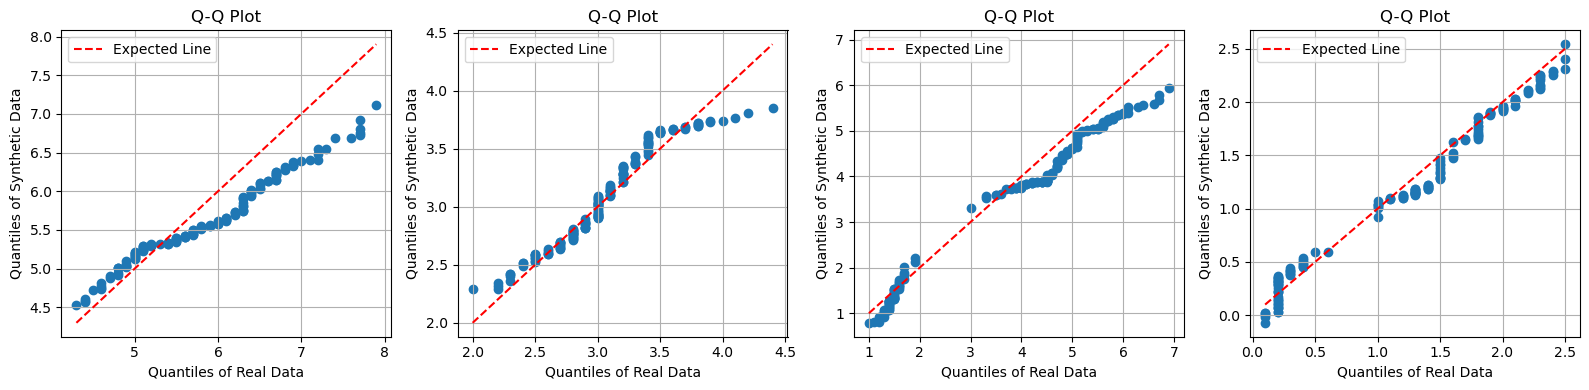

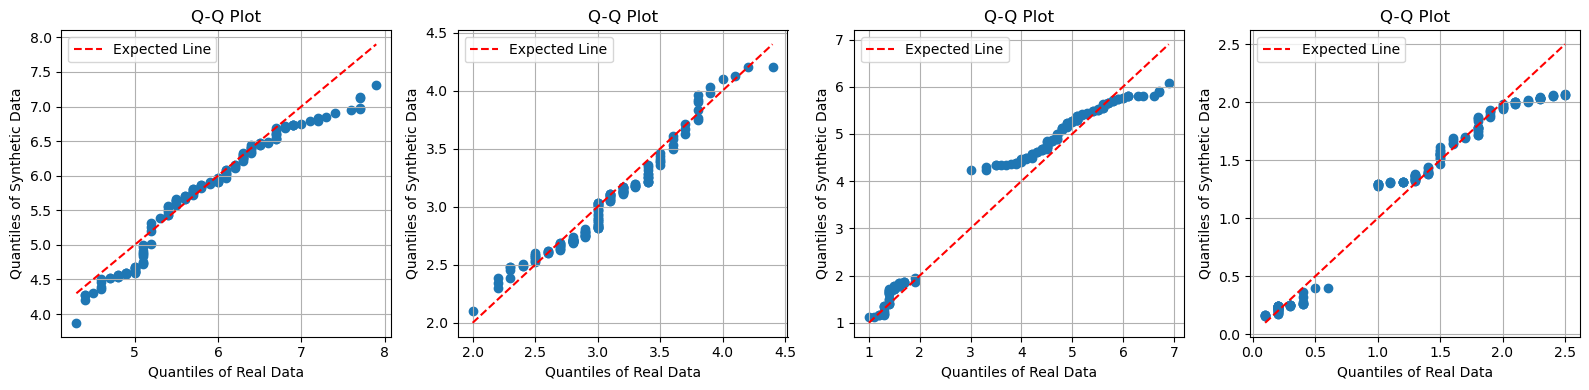

In [52]:
gan2_64nv_df = pd.DataFrame(med_gan_dict['Dataframes'][-1][:,:4])
gan2_64nv_df['target'] = y
gan2_64nv_df['target'] = gan2_64nv_df['target'].map({i: species[i] for i in range(len(species))})
gan2_64nv_df.columns = real_iris.columns

gan1_2nv_df = pd.DataFrame(small_gan_dict['Dataframes'][0][:,:4])
gan1_2nv_df['target'] = y
gan1_2nv_df['target'] = gan1_2nv_df['target'].map({i: species[i] for i in range(len(species))})
gan1_2nv_df.columns = real_iris.columns

for dataframe in [gan2_64nv_df, gan1_2nv_df]:
    utils.plot_quantiles(real_iris, dataframe)

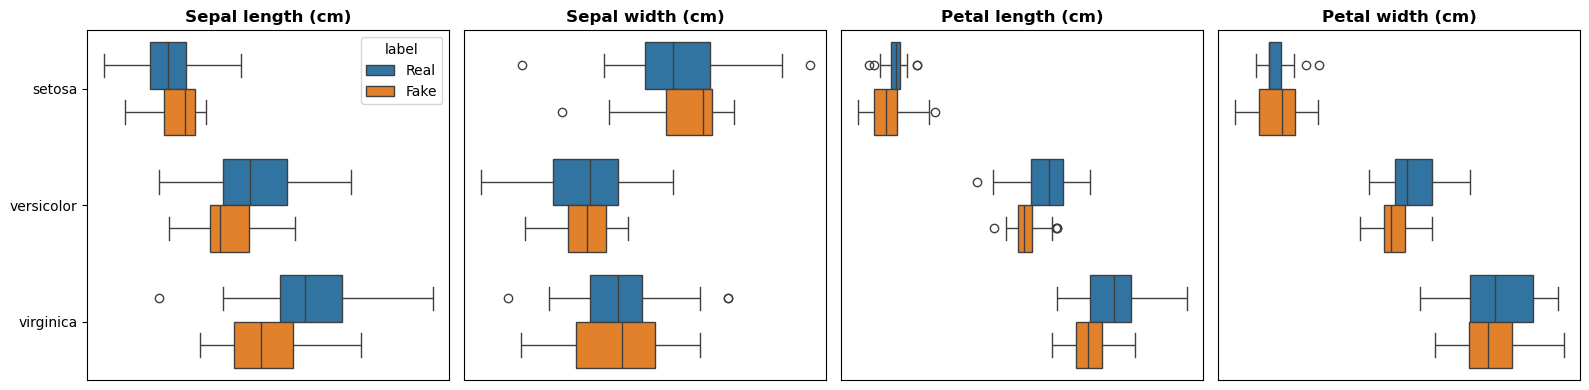

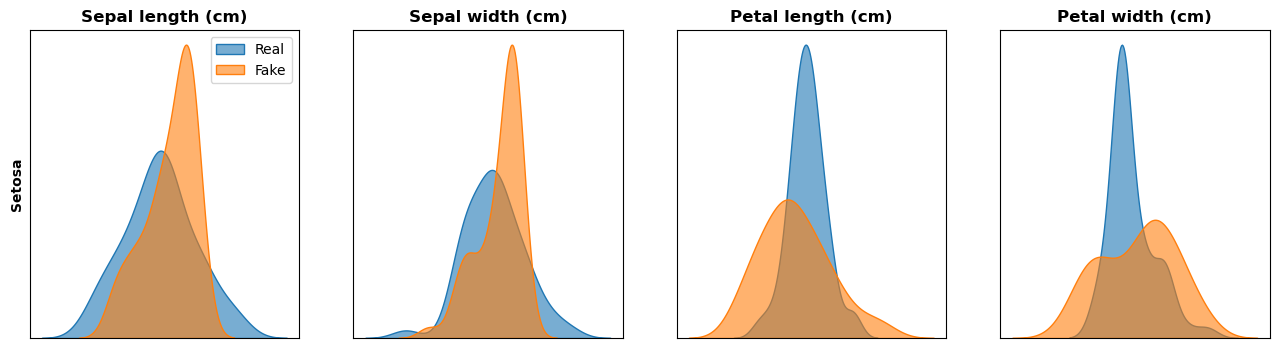

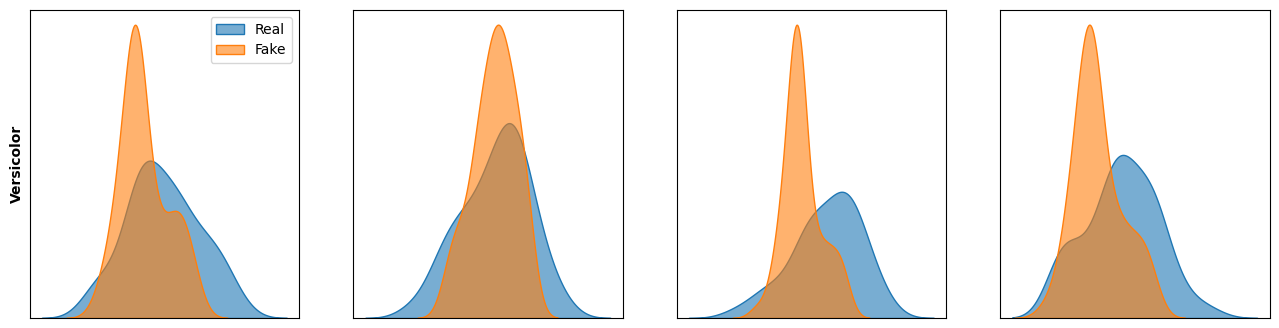

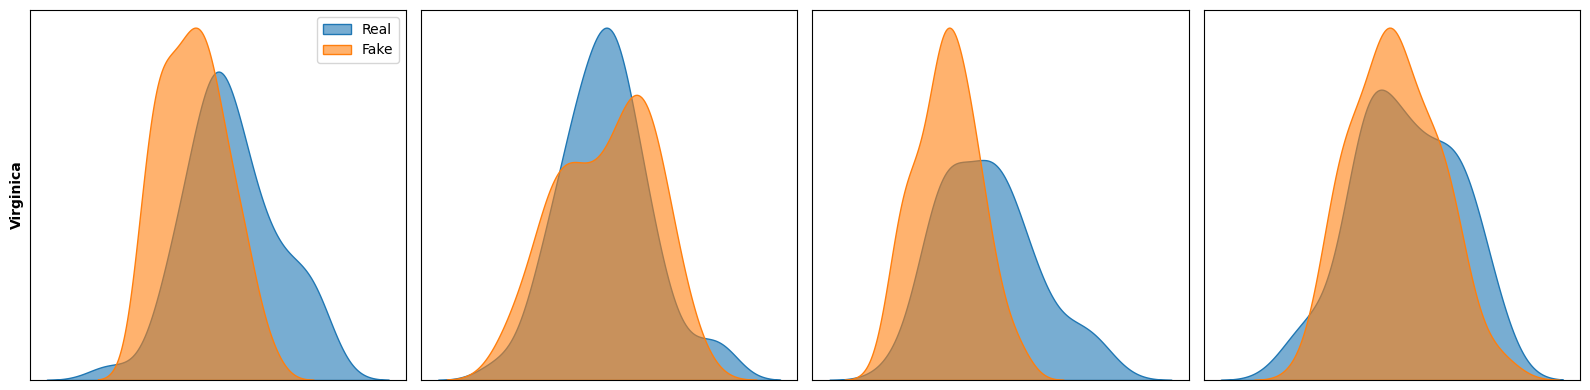

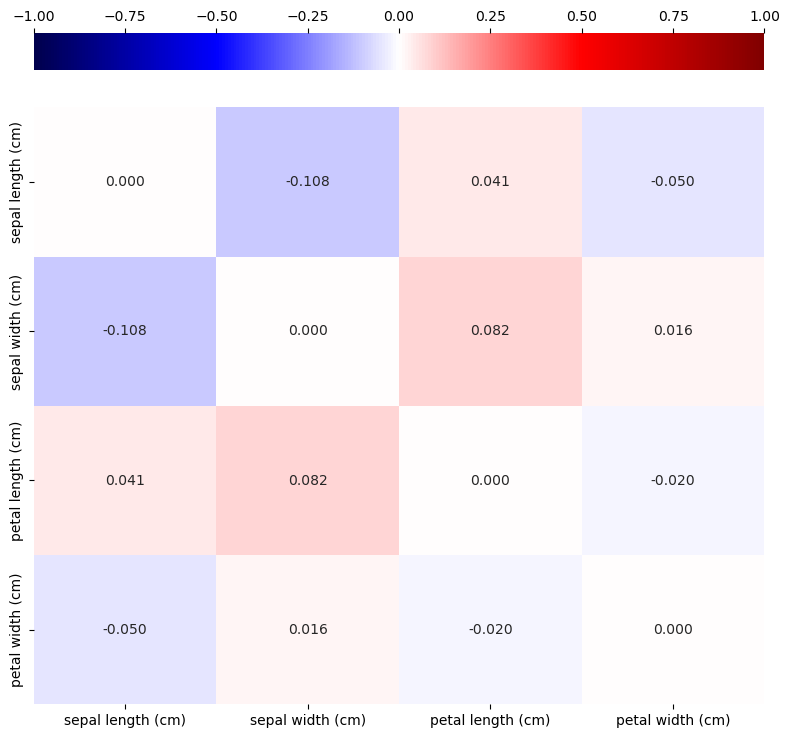

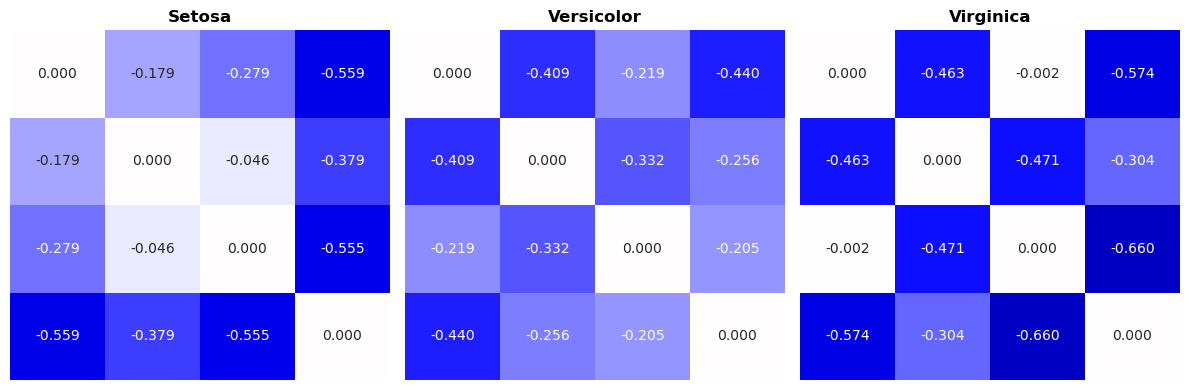

In [53]:
utils.plot_data(real_iris, 'target', gan2_64nv_df)

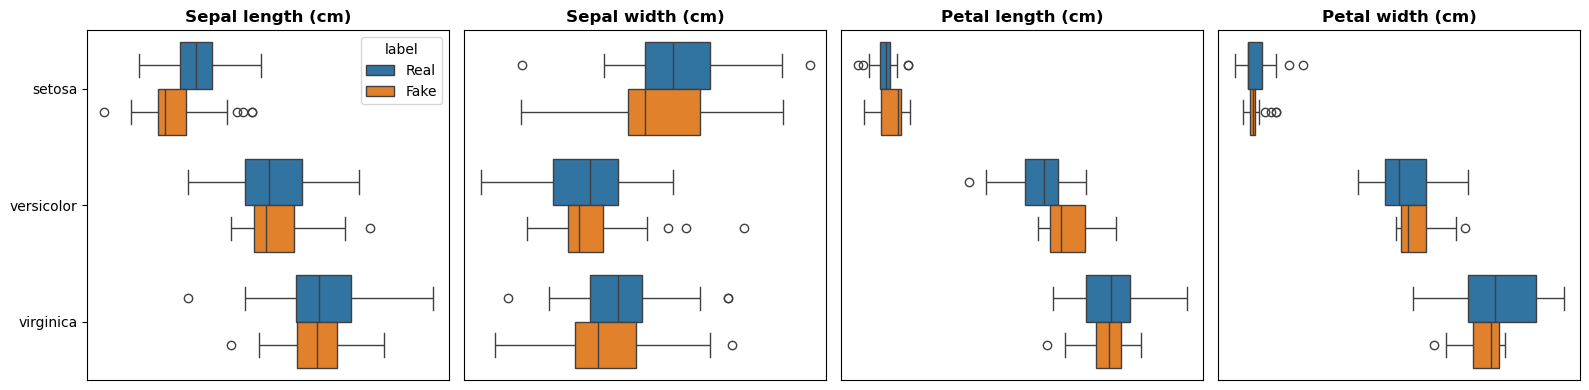

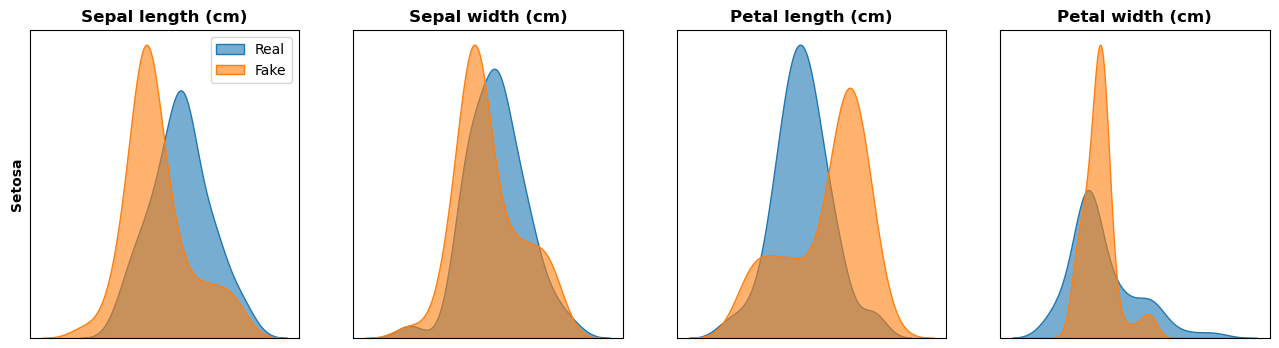

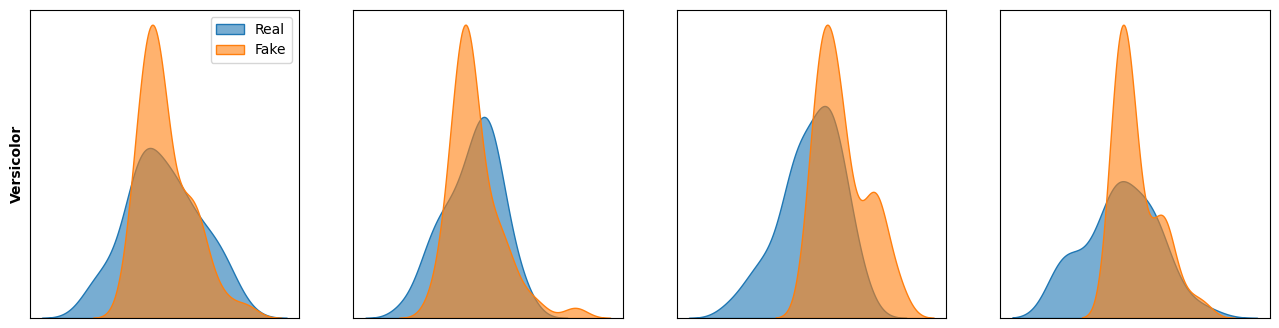

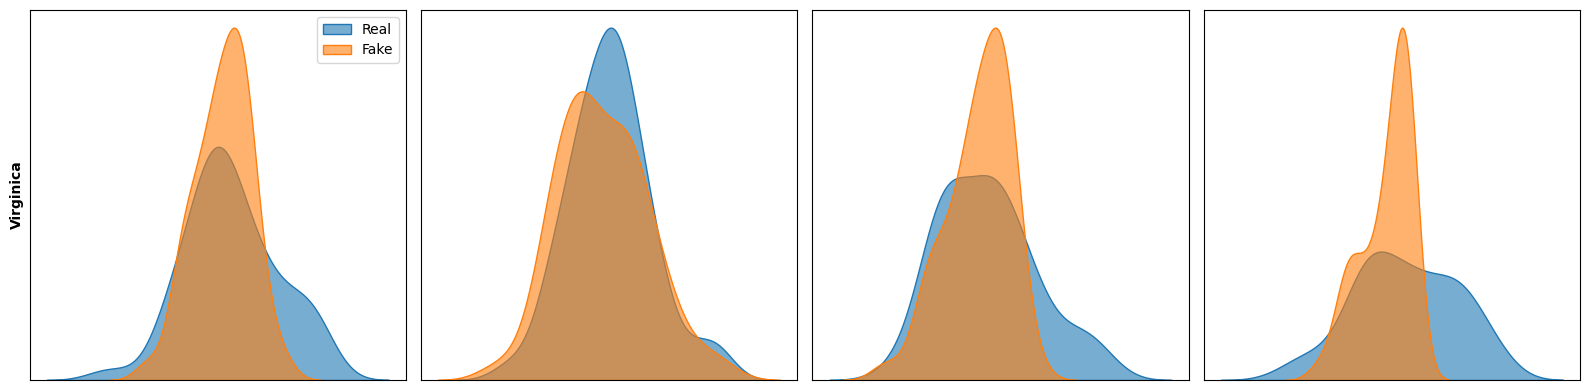

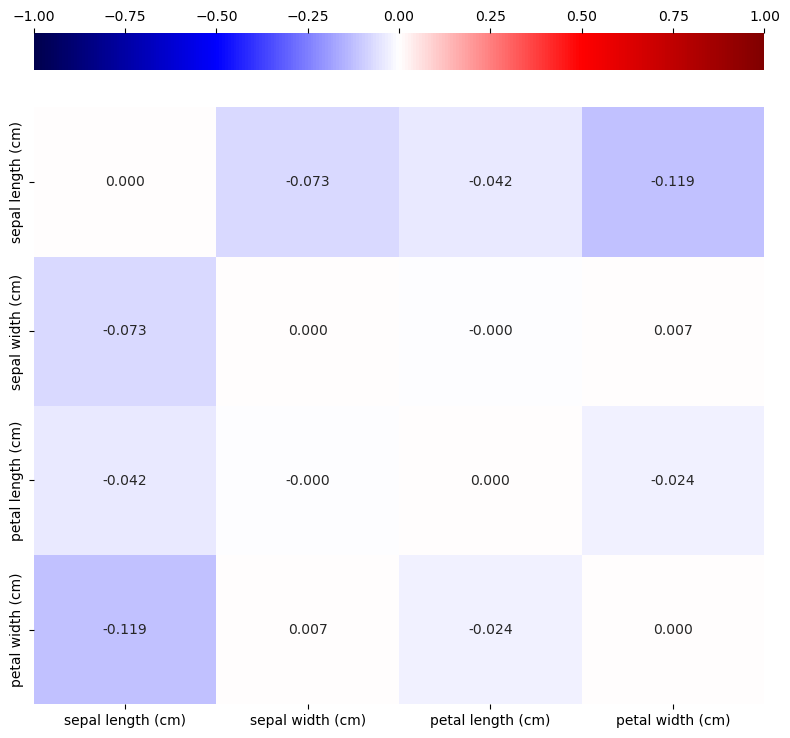

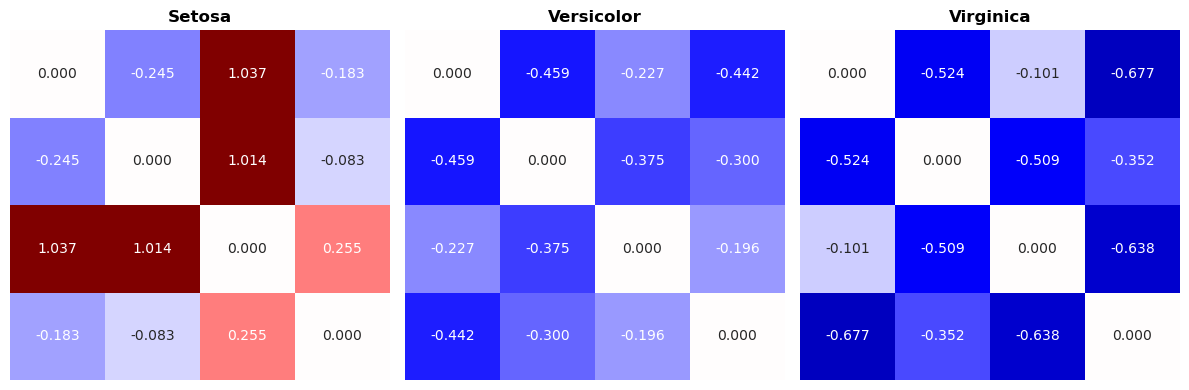

In [54]:
utils.plot_data(real_iris, 'target', gan1_2nv_df)

In [55]:
print((real_iris.select_dtypes('number').corr() - gan2_64nv_df.select_dtypes('number').corr()).abs().sum().sum())
print((real_iris.select_dtypes('number').corr() - gan1_2nv_df.select_dtypes('number').corr()).abs().sum().sum())

0.6333498352192091
0.5309538531198492


In [56]:
print(f"Medium GAN: {(real_iris.select_dtypes('number').corr().sum() - gan2_64nv_df.select_dtypes('number').corr().sum()).sum():.4f}")
print(f"Big GAN: {(real_iris.select_dtypes('number').corr().sum() - gan1_2nv_df.select_dtypes('number').corr().sum()).sum():.4f}")

Medium GAN: -0.0795
Big GAN: -0.5020


In [57]:
print('Medium GAN correlation differences:\n')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {(real_iris[real_iris['target'] == target].select_dtypes('number').corr().sum() - gan2_64nv_df[gan2_16nv_df['target'] == target].select_dtypes('number').corr().sum()).sum():.4f}")
print('\nBig GAN correlation differences:\n')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {(real_iris[real_iris['target'] == target].select_dtypes('number').corr().sum() - gan1_2nv_df[gan3_16nv_df['target'] == target].select_dtypes('number').corr().sum()).sum():.4f}")

Medium GAN correlation differences:

Setosa: -3.9926
Versicolor: -3.7232
Virginica: -4.9446

Big GAN correlation differences:

Setosa: 3.5894
Versicolor: -3.9978
Virginica: -5.6037


The difference is still the same; it will be the data generated that will give us an idea of the usefulness of this addition.

In [58]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 2e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, noise_dim)

In [59]:
for epoch in tqdm(range(5001), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in aug_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], noise_dim)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 500 == 0 or epoch == 5000:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(aug_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/5001 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x19 and 67x128)

In [60]:
fake_data = gen(z, real_gan_dataloader.dataset.label)
gan_df = pd.DataFrame(aug_std_scl.inverse_transform(fake_data.detach().numpy()))
gan_df['target'] = target_column
gan_df.columns = aug_iris.columns
gan_df

RuntimeError: mat1 and mat2 shapes cannot be multiplied (150x19 and 67x128)

In [61]:
gan_df = gan_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']]
gan_df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             5.069601          3.937117           1.154008          0.301228   
1             4.707715          3.264698           1.303325          0.365481   
2             4.683053          3.278196           1.147590          0.300638   
3             4.999763          3.844005           1.141363          0.319213   
4             4.936061          3.467638           1.391885          0.361379   
..                 ...               ...                ...               ...   
145           6.080393          3.051331           5.079227          1.942495   
146           6.571808          3.524757           5.698608          2.419187   
147           6.849372          3.440859           5.780247          2.294170   
148           7.388225          3.781111           6.124889          2.622458   
149           6.083968          3.080033           5.126587          1.950195   

        target  
0       setosa  
1       setosa  
2       setosa  
3       setosa  
4       setosa  
..         ...  
145  virginica  
146  virginica  
147  virginica  
148  virginica  
149  virginica  

[150 rows x 5 columns]

In [62]:
utils.describe_data(real_iris, 'target', gan_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     4.856      5.914   
     sepal width (cm)   3.428      2.770     2.974     3.491      2.934   
     petal length (cm)  1.462      4.260     5.552     1.265      4.227   
     petal width (cm)   0.246      1.326     2.026     0.345      1.383   
STD  sepal length (cm)  0.352      0.516     0.636     0.226      0.491   
     sepal width (cm)   0.379      0.314     0.322     0.270      0.271   
     petal length (cm)  0.174      0.470     0.552     0.117      0.403   
     petal width (cm)   0.105      0.198     0.275     0.044      0.151   
MIN  sepal length (cm)  4.300      4.900     4.900     4.193      4.811   
     sepal width (cm)   2.300      2.000     2.200     2.801      2.203   
     petal length (cm)  1.000      3.000     4.500     0.966      3.162   
     petal width (cm)   0.100      1.000     1.400     0.271      1.083   
MAX  sepal length (cm)  5.800      7.000     7.900     5.176      7.156   
     sepal width (cm)   4.400      3.400     3.800     4.123      3.518   
     petal length (cm)  1.900      5.100     6.900     1.476      5.148   
     petal width (cm)   0.600      1.800     2.500     0.523      1.756   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.920      0.120   
     sepal width (cm)   0.040     -0.352     0.355     0.033     -0.285   
     petal length (cm)  0.103     -0.588     0.533    -0.368     -0.346   
     petal width (cm)   1.216     -0.030    -0.126     1.540     -0.100   
KURT sepal length (cm) -0.346     -0.599    -0.088     0.556     -0.232   
     sepal width (cm)   0.744     -0.448     0.520     0.308     -0.160   
     petal length (cm)  0.805     -0.074    -0.256    -0.459     -0.088   
     petal width (cm)   1.434     -0.488    -0.661     4.296     -0.399   
IQR  sepal length (cm)  0.400      0.700     0.675     0.307      0.723   
     sepal width (cm)   0.475      0.475     0.375     0.331      0.392   
     petal length (cm)  0.175      0.600     0.775     0.174      0.563   
     petal width (cm)   0.100      0.300     0.500     0.042      0.202   

                                  
                       virginica  
MEAN sepal length (cm)     6.448  
     sepal width (cm)      3.304  
     petal length (cm)     5.435  
     petal width (cm)      2.149  
STD  sepal length (cm)     0.542  
     sepal width (cm)      0.258  
     petal length (cm)     0.470  
     petal width (cm)      0.257  
MIN  sepal length (cm)     5.549  
     sepal width (cm)      2.798  
     petal length (cm)     4.596  
     petal width (cm)      1.728  
MAX  sepal length (cm)     7.622  
     sepal width (cm)      3.989  
     petal length (cm)     6.615  
     petal width (cm)      2.879  
SKEW sepal length (cm)     0.476  
     sepal width (cm)      0.219  
     petal length (cm)     0.502  
     petal width (cm)      0.444  
KURT sepal length (cm)    -0.457  
     sepal width (cm)     -0.295  
     petal length (cm)    -0.195  
     petal width (cm)     -0.215  
IQR  sepal length (cm)     0.694  
     sepal width (cm)      0.352  
     petal length (cm)     0.611  
     petal width (cm)      0.394

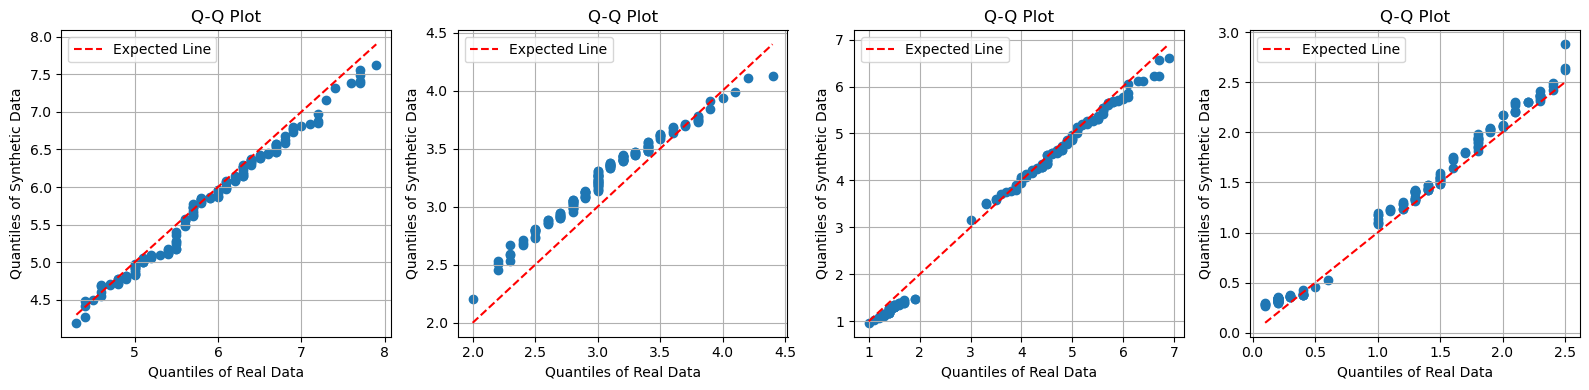

In [63]:
utils.plot_quantiles(real_iris.select_dtypes('number'), gan_df.select_dtypes('number'))

In [ ]:
utils.plot_data(real_iris, 'target', gan_df)

In [64]:
utils.calculate_ks_test(real_iris, gan_df).style.background_gradient(cmap = 'Reds')

In [65]:
utils.calculate_wasserstein_distance(real_iris, gan_df).style.background_gradient(cmap = 'Reds')

In [66]:
print(f"Overall correlations difference: {(real_iris.select_dtypes('number').corr() - gan_df.select_dtypes('number').corr()).sum().sum():.4f}")

for specie in real_iris['target'].unique():
    print(f"{specie.capitalize()}: {(real_iris[real_iris['target'] == specie].select_dtypes('number').corr() - gan_df[real_iris['target'] == specie].select_dtypes('number').corr()).sum().sum():.4f}")


Overall correlations difference: -1.5877
Setosa: -0.6013
Versicolor: -3.7111
Virginica: -5.4439


As we can see in general the model is able to reproduce the global features quite adequately but struggles to reproduce the specific features of individual classes. By modifying the model structure and training cycle will it be able to capture the features of each class?

In [67]:
noise_dim = 16
data_dim = aug_iris.select_dtypes('number').shape[1]

class Generator(nn.Module):
    def __init__(self, input_dim, num_classes, output_dim):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, output_dim),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

set_seed()    
gen = Generator(input_dim = noise_dim, num_classes = 3, output_dim = data_dim)
disc = Discriminator(input_dim = data_dim, num_classes = 3)

print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Discriminator parameters: {sum(p.numel() for p in disc.parameters())/1000}k')

Generator parameters: 13.603k
Discriminator parameters: 12.682k


In [68]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 2e-3)#, betas = (0.5, 0.999))
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)#, betas = (0.5, 0.999))

g_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(g_opt, eta_min = 1e-6, T_max = 5000)
d_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(d_opt, eta_min = 1e-6, T_max = 5000)

gen_grad_norm = torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm = 0.5)
disc_grad_norm = torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm = 0.5)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, noise_dim)

In [69]:
models = [gen, disc]

for model in models:
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

for epoch in tqdm(range(5001), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in aug_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], noise_dim)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        disc_grad_norm = torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm=1.0)
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        gen_grad_norm = torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
        g_opt.step()
        
    g_scheduler.step()
    d_scheduler.step()
    
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 500 == 0 or epoch == 5000:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(aug_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/5001 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6759 | GLoss 0.7286
MEAN: [-0.256  0.494 -0.267 -0.002  0.107 -0.301 -0.343  0.22   0.538 -0.385]
STD:  [0.871 0.787 0.812 0.92  0.865 0.881 0.83  0.877 0.784 0.838]
MIN:  [-1.798 -1.277 -1.379 -1.247 -1.773 -1.24  -1.714 -0.324  0.254 -0.751]
MAX:  [1.881 3.193 0.856 1.53  3.365 1.472 1.703 4.247 2.759 3.48 ]
SKEW: [ 0.039  0.752 -0.738 -0.007  0.737 -0.353 -0.388  2.408  1.456  1.307]
KURT: [-0.408  0.379 -1.981 -0.787  0.162 -1.774 -0.706  6.052 -0.928  3.124]

Epoch 500/500 | DLoss: 0.5016 | GLoss 1.3705
MEAN: [ 0.287 -0.017  0.093 -0.272  0.046 -0.131  0.134  0.397  0.191  0.281]
STD:  [ 0.137  0.261 -0.064 -0.027  0.202 -0.112  0.167  0.376  0.035  0.279]
MIN:  [-0.081 -1.517  0.309 -0.248 -0.844  0.068  0.068  0.692  0.096  0.362]
MAX:  [ 0.814  1.289  0.074 -0.77   1.154 -0.861  1.539  3.563  1.006  3.442]
SKEW: [-0.221 -0.171  0.    -0.052 -0.199 -0.204  0.607  1.65   0.128  1.046]
KURT: [ 1.490e-01  1.200e+00 -2.000e-03 -2.200e-02  4.780e-01 -1.940e-01

In [70]:
fake_data = gen(z, real_gan_dataloader.dataset.label)
gan_df = pd.DataFrame(aug_std_scl.inverse_transform(fake_data.detach().numpy()))
gan_df['target'] = target_column
gan_df.columns = aug_iris.columns
gan_df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             5.022744          3.339551           1.473477          0.206904   
1             4.550932          3.197224           1.340970          0.181948   
2             5.135529          3.541556           1.688402          0.465228   
3             5.043009          3.289731           1.405908          0.204345   
4             4.842601          3.341710           1.561282          0.210688   
..                 ...               ...                ...               ...   
145           6.740142          3.144462           5.565056          2.441724   
146           6.283014          3.353544           5.610962          2.426346   
147           6.762519          3.023583           5.280365          2.197448   
148           6.225812          3.321132           5.603781          2.408579   
149           6.517801          3.317275           5.612017          2.405635   

     sepal area  petal area  sepal aspect ratio  petal aspect ratio  \
0     16.830189    0.270476            1.511872            7.527637   
1     14.579118    0.535995            1.425579            6.916389   
2     18.447266    0.874684            1.463932            3.200352   
3     16.657869    0.269487            1.539562            7.151103   
4     16.287661    0.243573            1.442478            7.537385   
..          ...         ...                 ...                 ...   
145   21.065170   13.423928            2.145121            2.249401   
146   21.052919   13.620450            1.870488            2.248356   
147   20.360800   11.615140            2.229510            2.480747   
148   20.704992   13.524088            1.876452            2.281913   
149   21.515112   13.484407            1.972054            2.308045   

     sepal petal length ratio  sepal petal width ratio     target  
0                    3.429849                16.373899     setosa  
1                    3.266913                15.721463     setosa  
2                    3.127087                 6.721617     setosa  
3                    3.599402                16.168165     setosa  
4                    3.238522                16.750584     setosa  
..                        ...                      ...        ...  
145                  1.222918                 1.403386  virginica  
146                  1.077581                 1.274711  virginica  
147                  1.297203                 1.564262  virginica  
148                  1.083323                 1.361203  virginica  
149                  1.147549                 1.387015  virginica  

[150 rows x 11 columns]

In [71]:
gan_df = gan_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']]
gan_df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             5.022744          3.339551           1.473477          0.206904   
1             4.550932          3.197224           1.340970          0.181948   
2             5.135529          3.541556           1.688402          0.465228   
3             5.043009          3.289731           1.405908          0.204345   
4             4.842601          3.341710           1.561282          0.210688   
..                 ...               ...                ...               ...   
145           6.740142          3.144462           5.565056          2.441724   
146           6.283014          3.353544           5.610962          2.426346   
147           6.762519          3.023583           5.280365          2.197448   
148           6.225812          3.321132           5.603781          2.408579   
149           6.517801          3.317275           5.612017          2.405635   

        target  
0       setosa  
1       setosa  
2       setosa  
3       setosa  
4       setosa  
..         ...  
145  virginica  
146  virginica  
147  virginica  
148  virginica  
149  virginica  

[150 rows x 5 columns]

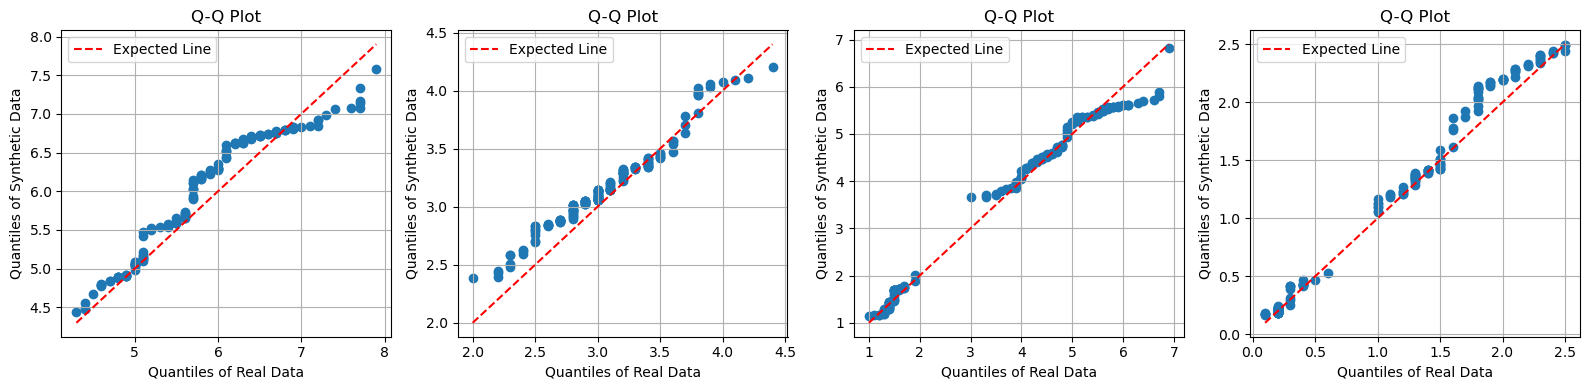

In [72]:
utils.plot_quantiles(real_iris.select_dtypes('number'), gan_df.select_dtypes('number'))

In [73]:
utils.calculate_ks_test(real_iris, gan_df).style.background_gradient(cmap = 'Reds')

In [74]:
utils.calculate_wasserstein_distance(real_iris, gan_df).style.background_gradient(cmap = 'Reds')

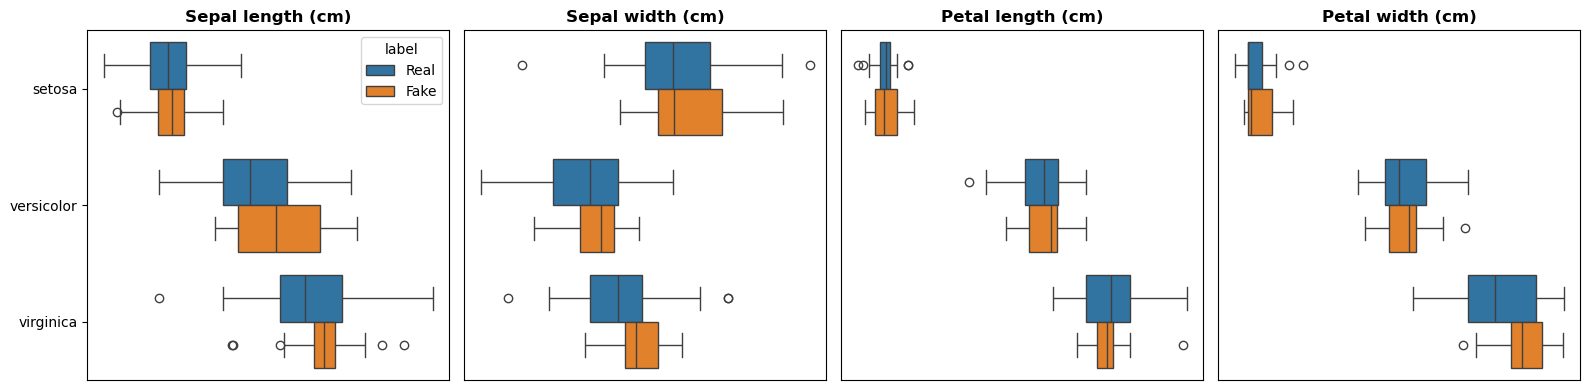

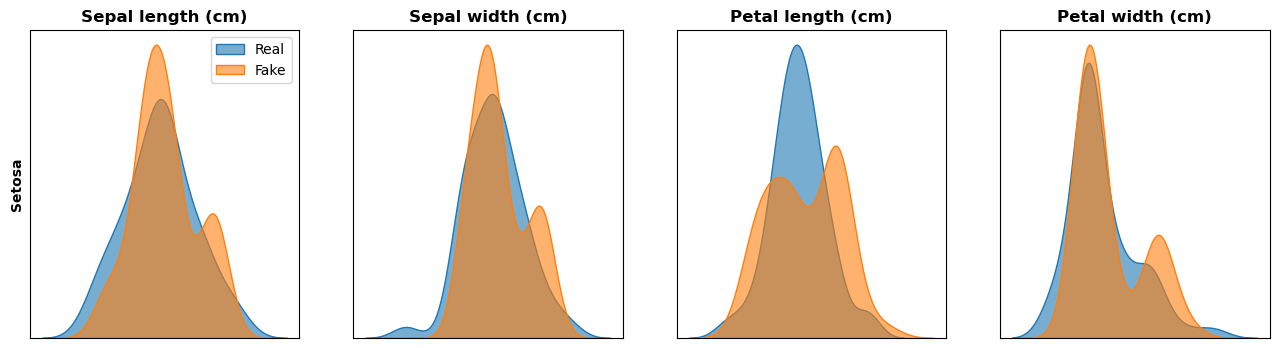

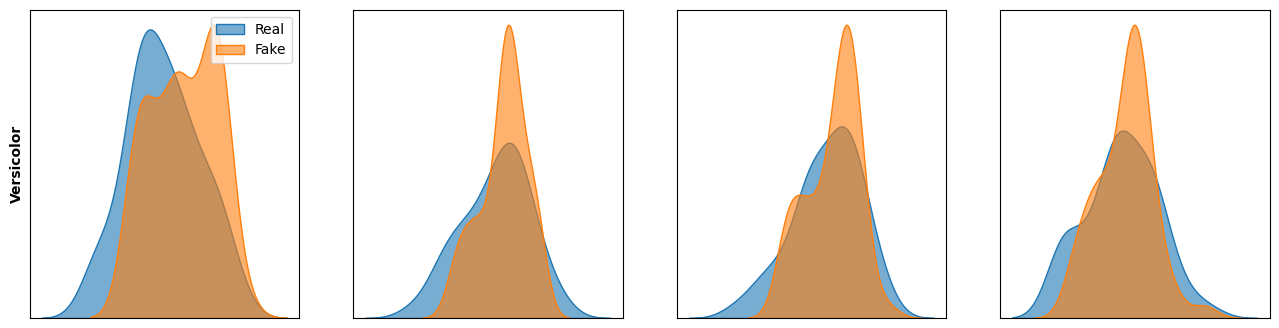

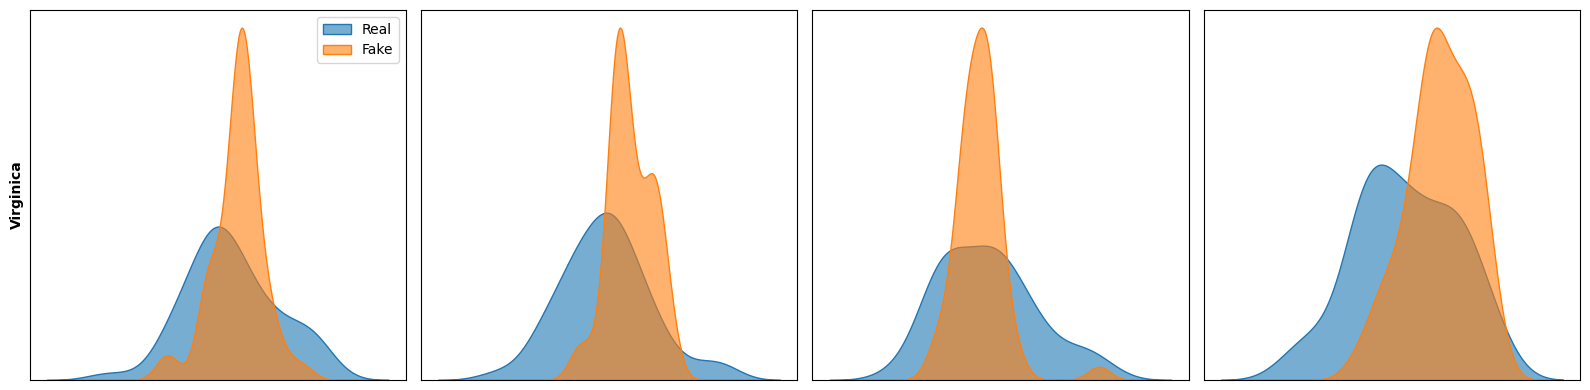

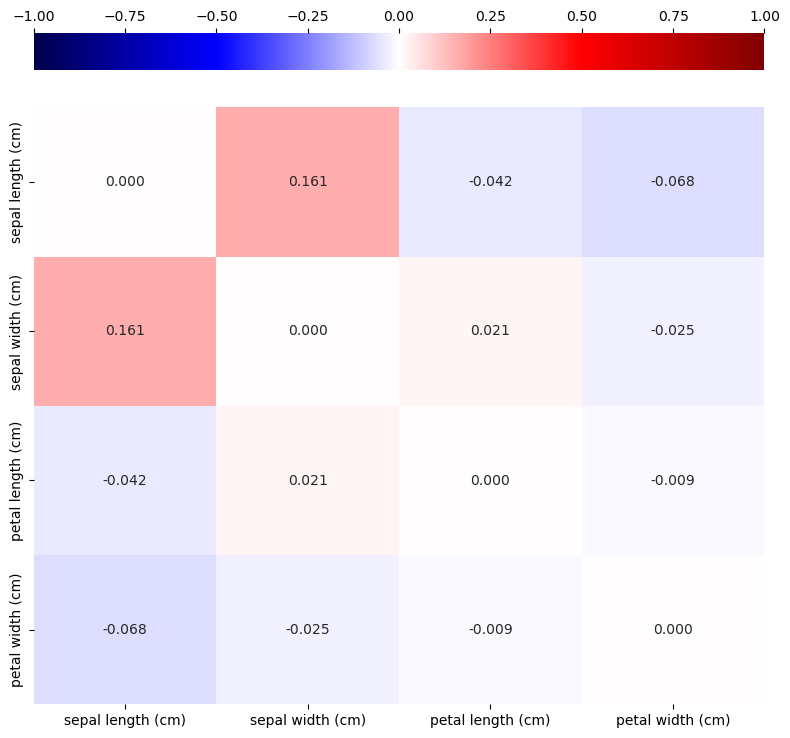

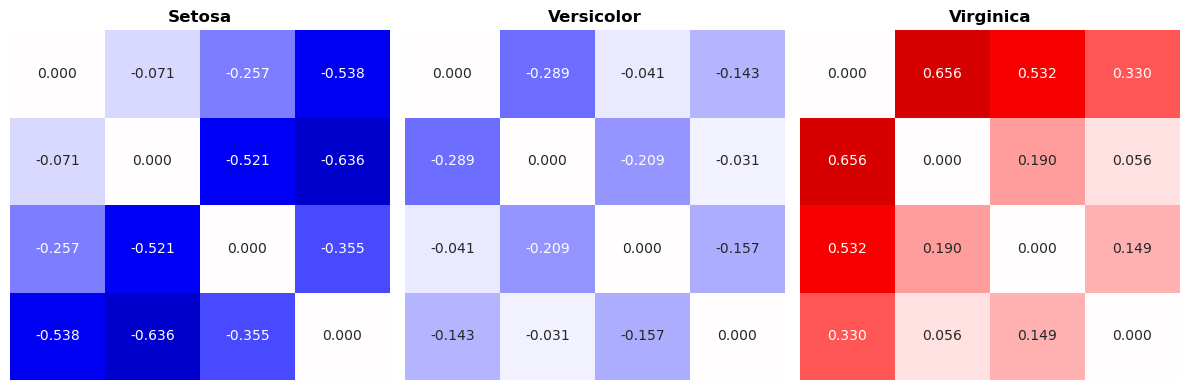

In [75]:
utils.plot_data(real_iris, 'target', gan_df)

In [76]:
print(f"Overall correlations difference: {(real_iris.select_dtypes('number').corr() - gan_df.select_dtypes('number').corr()).sum().sum():.4f}")

for specie in real_iris['target'].unique():
    print(f"{specie.capitalize()}: {(real_iris[real_iris['target'] == specie].select_dtypes('number').corr() - gan_df[real_iris['target'] == specie].select_dtypes('number').corr()).sum().sum():.4f}")


Overall correlations difference: 0.0781
Setosa: -4.7567
Versicolor: -1.7369
Virginica: 3.8276


In [77]:
noise_dim = 16

class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, output_dim, hidden_dim, class_dim):
        super(ConditionalGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim + class_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, noise, labels):
        labels = labels.unsqueeze(1)
        x = torch.cat([noise, labels], dim=1)
        return self.net(x)
    
class ConditionalCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, class_dim):
        super(ConditionalCritic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + class_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, data, labels):
        labels = labels.unsqueeze(1)
        x = torch.cat([data, labels], dim=1)
        return self.net(x)

set_seed()
gen = ConditionalGenerator(noise_dim = noise_dim, output_dim = 4, hidden_dim = 32, class_dim = 1)
crit = ConditionalCritic(input_dim = 4, hidden_dim = 32, class_dim = 1)

batch_size = 32
noise = torch.randn(batch_size, noise_dim)
labels = torch.randint(0, 2, (batch_size,))

print(gen(noise, labels).shape)

print(crit(torch.randn(32,4), batch[1]).shape)

torch.Size([32, 4])
torch.Size([32, 1])


In [78]:
def gradient_penalty(critic, real_data, fake_data, labels, lambda_gp = 10):
    batch_size = real_data.size(0)
    # Genera un campione interpolato tra real e fake
    epsilon = torch.rand(batch_size, 1, device=real_data.device)
    epsilon = epsilon.expand_as(real_data)  # Espande la dimensione
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)  # Abilita il calcolo del gradiente
    
    # Calcola il punteggio del critico sull'interpolazione
    interpolated_score = critic(interpolated, labels)
    
    # Calcola il gradiente rispetto a interpolated
    grad_outputs = torch.ones_like(interpolated_score, device=real_data.device)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Calcola la norma del gradiente
    gradients_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    # Penalità sul gradiente
    penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return penalty

# Funzione di perdita del critico
def critic_loss(critic, real_data, fake_data, labels, lambda_gp=10):
    # Score del critico per i dati reali e generati
    real_score = critic(real_data, labels)
    fake_score = critic(fake_data, labels)
    
    # Calcolo della Wasserstein loss per il critico
    wasserstein_loss = fake_score.mean() - real_score.mean()
    
    # Aggiungi la penalità sul gradiente
    gp = gradient_penalty(critic, real_data, fake_data, labels, lambda_gp)
    return wasserstein_loss + gp

# Funzione di perdita del generatore
def generator_loss(critic, fake_data, labels):
    # Score del critico per i dati generati
    fake_score = critic(fake_data, labels)
    return -fake_score.mean()

In [79]:
g_lr = 1e-3
c_lr = 2e-3

#g_opt = torch.optim.AdamW(gen.parameters(), lr = g_lr, betas = (0.5, 0.999))
#c_opt = torch.optim.AdamW(crit.parameters(), lr = c_lr, betas = (0.5, 0.999))

g_opt = torch.optim.AdamW(gen.parameters(), lr=5e-4, betas=(0.5, 0.999), weight_decay=0)
c_opt = torch.optim.AdamW(crit.parameters(), lr=2e-3, betas=(0.5, 0.999), weight_decay=0)

set_seed()
z = torch.randn(150, noise_dim)

In [80]:
for epoch in tqdm(range(5001)):
    
    gen.train()
    crit.train()
    
    gen_epoch_loss = 0
    crit_epoch_loss = 0
    
    for data, labels in real_gan_dataloader:
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        c_opt.zero_grad()
        crit_loss = critic_loss(crit, data, fake_data, labels)
        crit_epoch_loss += crit_loss.item()
        crit_loss.backward()
        c_opt.step()
        
    if epoch % 5 == 0:
            
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        g_opt.zero_grad()
        gen_loss = generator_loss(critic = crit, fake_data = fake_data, labels = labels)
        gen_epoch_loss += gen_loss.item()
        gen_loss.backward()
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    c_epoch_loss = crit_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 500 == 0 or epoch == 5000:    
        print(f"Epoch{epoch}/100 | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch0/100 | CLoss: 8.7089 | GLoss: 0.0057
Epoch500/100 | CLoss: -1.5193 | GLoss: -0.0556
Epoch1000/100 | CLoss: -0.9413 | GLoss: -0.5153
Epoch1500/100 | CLoss: -0.6179 | GLoss: -0.5707
Epoch2000/100 | CLoss: -0.4687 | GLoss: -0.4389
Epoch2500/100 | CLoss: -0.3516 | GLoss: -0.7242
Epoch3000/100 | CLoss: -0.3044 | GLoss: -0.3883
Epoch3500/100 | CLoss: -0.2928 | GLoss: -0.4934
Epoch4000/100 | CLoss: -0.1752 | GLoss: -0.6889
Epoch4500/100 | CLoss: -0.0731 | GLoss: -0.6309
Epoch5000/100 | CLoss: -0.0242 | GLoss: 0.4495


In [81]:
fake_df = pd.DataFrame(std_scl.inverse_transform(gen(z, real_gan_dataloader.dataset.label).detach().numpy()))
fake_df['target'] = real_iris['target']
fake_df.columns = real_iris.columns
utils.calculate_ks_test(real_iris, fake_df).style.background_gradient(cmap = 'Reds')

In [82]:
utils.calculate_wasserstein_distance(real_iris, fake_df).style.background_gradient(cmap = 'Reds')

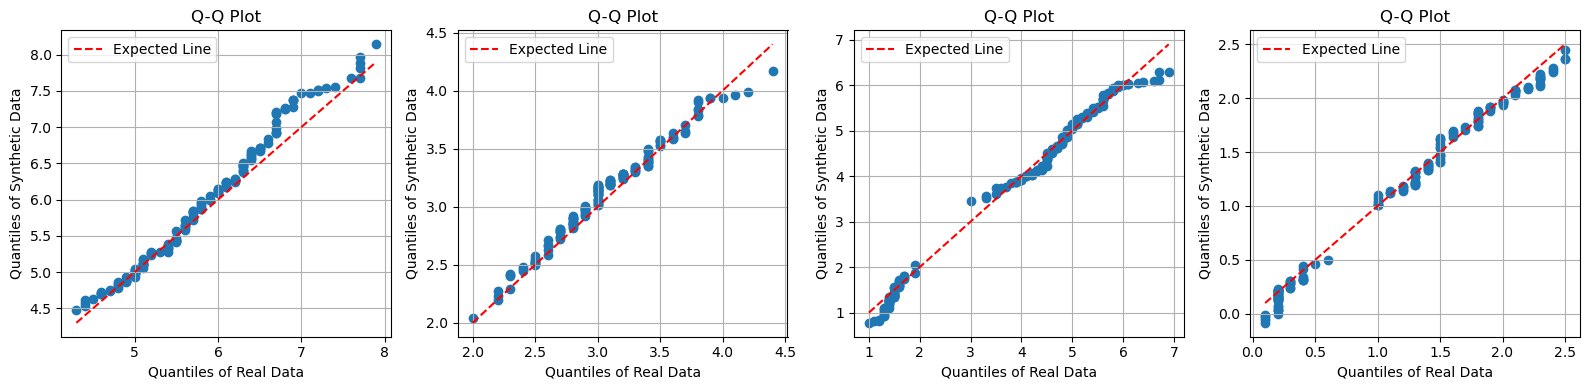

In [83]:
utils.plot_quantiles(real_iris, fake_df)

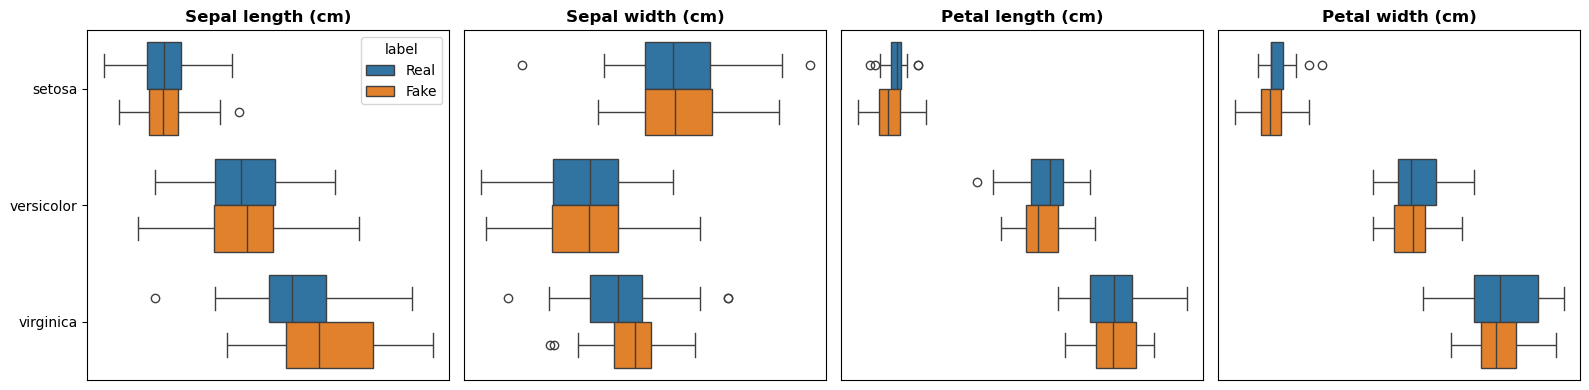

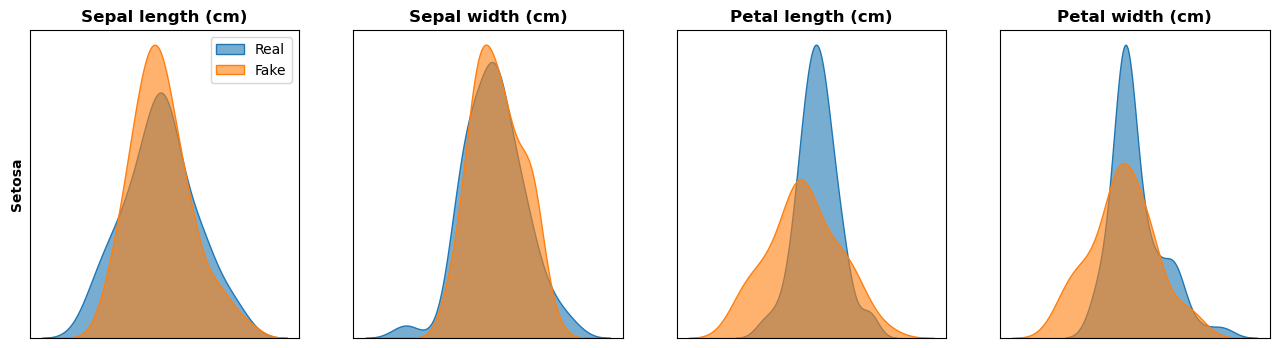

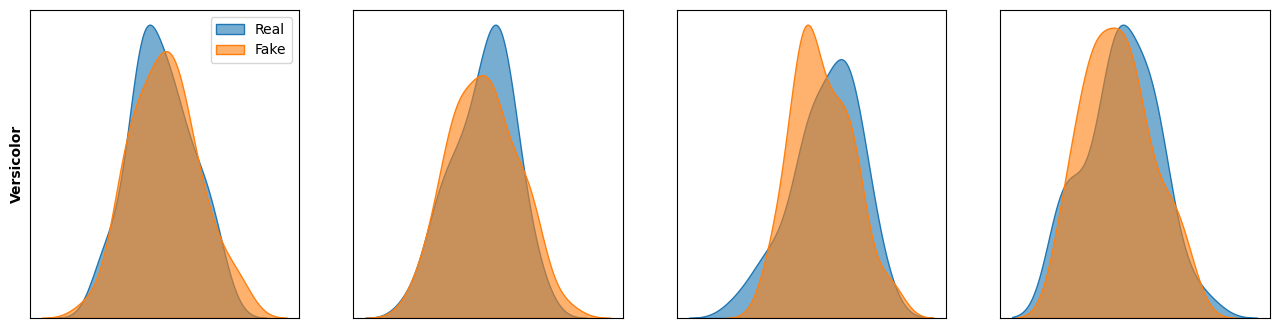

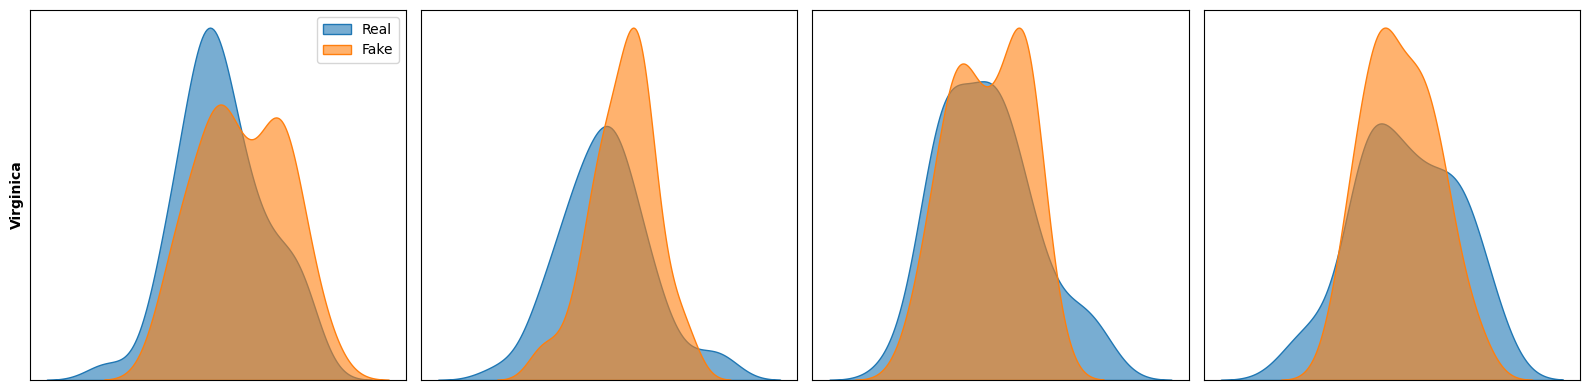

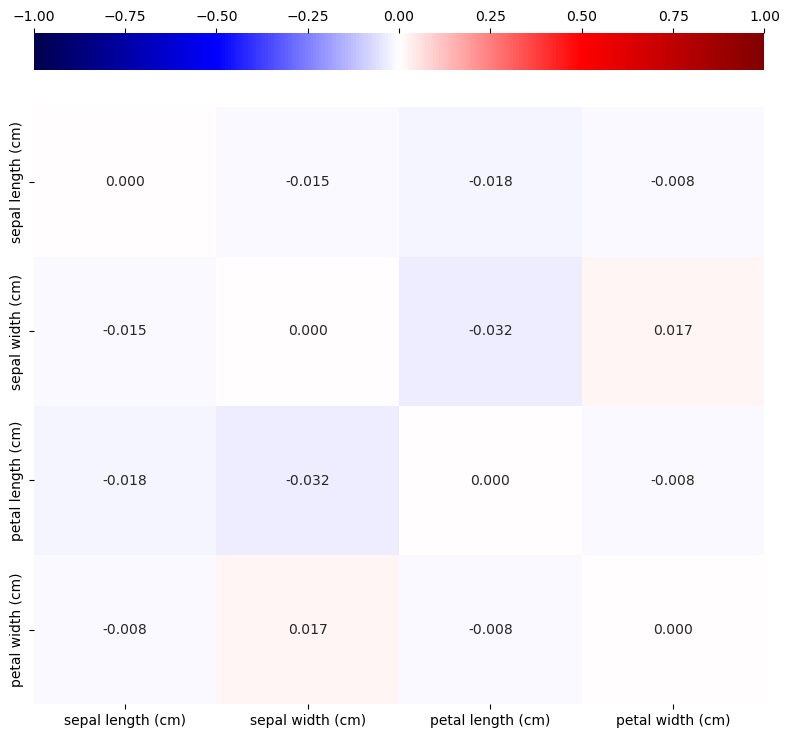

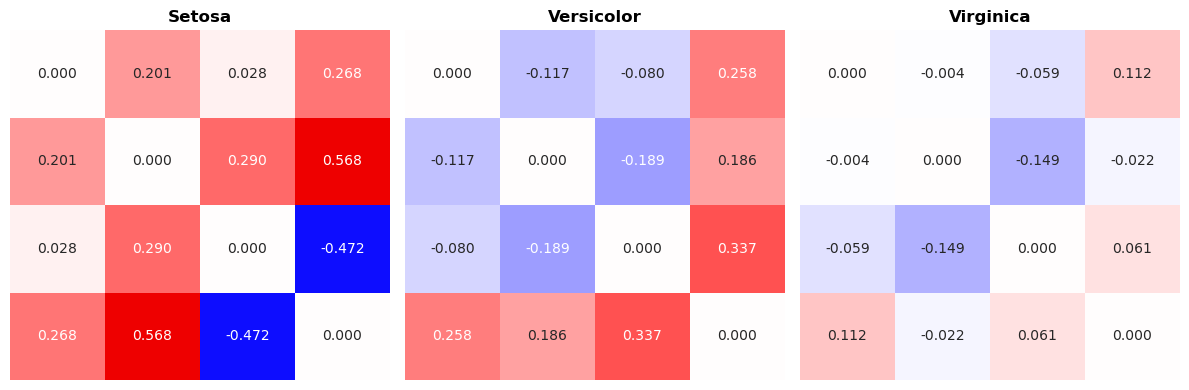

In [84]:
utils.plot_data(real_iris, 'target', fake_df)

In [85]:
print(f"Correlations difference: {((real_iris.select_dtypes('number').corr() - fake_df.select_dtypes('number').corr()).abs().sum().sum()):.4f}")
print('\nClass corr diff:')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {((real_iris[real_iris['target'] == target].select_dtypes('number').corr() - fake_df[fake_df['target'] == target].select_dtypes('number').corr()).abs().sum().sum()):.4f}")

Correlations difference: 0.1954

Class corr diff:
Setosa: 3.6523
Versicolor: 2.3344
Virginica: 0.8156


In [86]:
aug_iris = real_iris.copy()

aug_iris['sepal area'] = aug_iris['sepal length (cm)'] * aug_iris['sepal width (cm)']
aug_iris['petal area'] = aug_iris['petal length (cm)'] * aug_iris['petal width (cm)']
#aug_iris['sepal aspect ratio'] = aug_iris['sepal length (cm)'] / aug_iris['sepal width (cm)']
#aug_iris['petal aspect ratio'] = aug_iris['petal length (cm)'] / aug_iris['petal width (cm)']
#aug_iris['sepal petal length ratio'] = aug_iris['sepal length (cm)'] / aug_iris['petal length (cm)']
#aug_iris['sepal petal width ratio'] = aug_iris['sepal width (cm)'] / aug_iris['petal width (cm)']

target_column = aug_iris.pop('target')
aug_iris['target'] = target_column
aug_iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   sepal area  petal area  target  
0       17.85        0.28  setosa  
1       14.70        0.28  setosa  
2       15.04        0.26  setosa  
3       14.26        0.30  setosa  
4       18.00        0.28  setosa

In [87]:
X_aug, y = aug_iris.select_dtypes('number'), y

aug_std_scl = StandardScaler()
X_aug_scld = aug_std_scl.fit_transform(X_aug)

aug_gan_dataset = IrisDataset(X_aug_scld, y)
aug_gan_dataloader = DataLoader(aug_gan_dataset, batch_size = 32, shuffle= True)

for batch in aug_gan_dataloader:
    gan_batch = batch
    break
    
print(gan_batch[0].shape)
print(gan_batch[1].shape)

torch.Size([32, 6])
torch.Size([32])


In [88]:
data_dim = aug_iris.shape[1] - 1

set_seed()
gen = ConditionalGenerator(noise_dim = noise_dim, output_dim = data_dim, hidden_dim = 32, class_dim = 1)
crit = ConditionalCritic(input_dim = data_dim, hidden_dim = 32, class_dim = 1)

batch_size = 32
noise = torch.randn(batch_size, noise_dim)
labels = torch.randint(0, 2, (batch_size,))

print(gen(noise, labels).shape)

print(crit(torch.randn(32, data_dim), batch[1]).shape)

torch.Size([32, 6])
torch.Size([32, 1])


In [89]:
g_lr = 1e-3
c_lr = 2e-3

#g_opt = torch.optim.AdamW(gen.parameters(), lr = g_lr, betas = (0.5, 0.999))
#c_opt = torch.optim.AdamW(crit.parameters(), lr = c_lr, betas = (0.5, 0.999))

g_opt = torch.optim.AdamW(gen.parameters(), lr=5e-4, betas=(0.5, 0.999), weight_decay=0)
c_opt = torch.optim.AdamW(crit.parameters(), lr=2e-3, betas=(0.5, 0.999), weight_decay=0)

set_seed()
z = torch.randn(150, noise_dim)

In [90]:
epochs = 10000

for epoch in tqdm(range(epochs + 1)):
    
    gen.train()
    crit.train()
    
    gen_epoch_loss = 0
    crit_epoch_loss = 0
    
    for data, labels in aug_gan_dataloader:
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        c_opt.zero_grad()
        crit_loss = critic_loss(crit, data, fake_data, labels)
        crit_epoch_loss += crit_loss.item()
        crit_loss.backward()
        c_opt.step()
        
    if epoch % 5 == 0:
            
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        g_opt.zero_grad()
        gen_loss = generator_loss(critic = crit, fake_data = fake_data, labels = labels)
        gen_epoch_loss += gen_loss.item()
        gen_loss.backward()
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(aug_gan_dataloader)
    c_epoch_loss = crit_epoch_loss/len(aug_gan_dataloader)
    
    if epoch % 500 == 0 or epoch == epochs:    
        print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  0%|          | 0/10001 [00:00<?, ?it/s]

Epoch0/10000 | CLoss: 8.4185 | GLoss: 0.0051
Epoch500/10000 | CLoss: -1.9327 | GLoss: -0.0199
Epoch1000/10000 | CLoss: -1.2327 | GLoss: -0.2859
Epoch1500/10000 | CLoss: -0.7603 | GLoss: 0.0645
Epoch2000/10000 | CLoss: -0.5516 | GLoss: -0.1059
Epoch2500/10000 | CLoss: -0.4192 | GLoss: -0.7364
Epoch3000/10000 | CLoss: -0.3940 | GLoss: -0.5843
Epoch3500/10000 | CLoss: -0.2846 | GLoss: -0.6764
Epoch4000/10000 | CLoss: -0.2150 | GLoss: -1.1312
Epoch4500/10000 | CLoss: -0.0918 | GLoss: -1.1105
Epoch5000/10000 | CLoss: -0.1511 | GLoss: -1.4197
Epoch5500/10000 | CLoss: -0.0858 | GLoss: -1.3653
Epoch6000/10000 | CLoss: -0.0657 | GLoss: -0.8950
Epoch6500/10000 | CLoss: -0.0165 | GLoss: -0.8512
Epoch7000/10000 | CLoss: -0.0649 | GLoss: -0.8544
Epoch7500/10000 | CLoss: -0.1043 | GLoss: -0.8892
Epoch8000/10000 | CLoss: -0.0867 | GLoss: -0.8650
Epoch8500/10000 | CLoss: -0.1281 | GLoss: -0.7539
Epoch9000/10000 | CLoss: -0.1483 | GLoss: -0.7591
Epoch9500/10000 | CLoss: -0.1811 | GLoss: -0.7469
Epoch10

In [91]:
fake_df = pd.DataFrame(aug_std_scl.inverse_transform(gen(z, aug_gan_dataloader.dataset.label).detach().numpy()))
fake_df['target'] = real_iris['target']
fake_df.columns = aug_iris.columns
fake_df = fake_df[real_iris.columns]
utils.calculate_ks_test(real_iris, fake_df).style.background_gradient(cmap = 'Reds')

In [92]:
utils.calculate_wasserstein_distance(real_iris, fake_df).style.background_gradient(cmap = 'Reds')

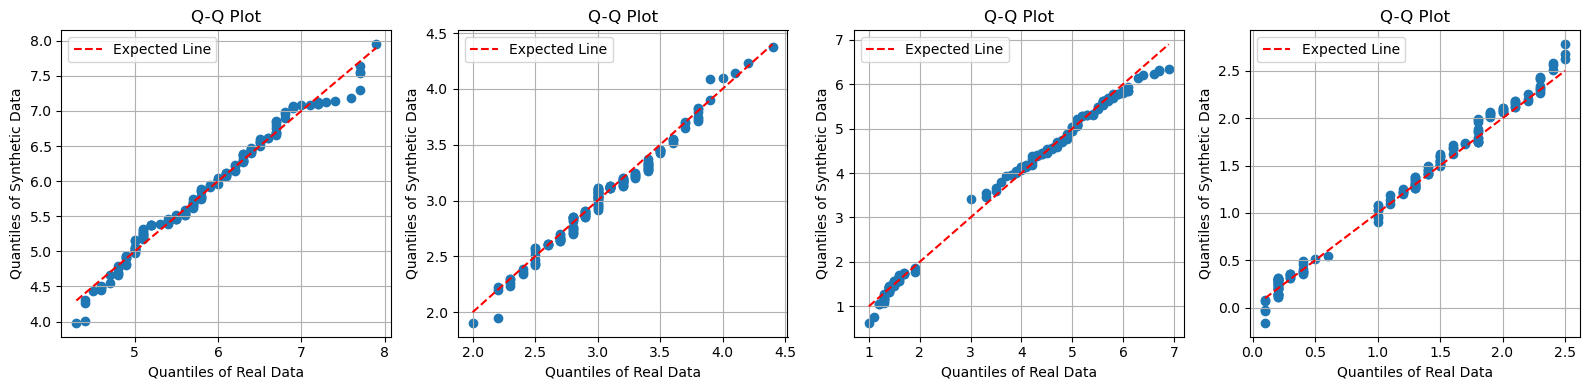

In [93]:
utils.plot_quantiles(real_iris, fake_df)

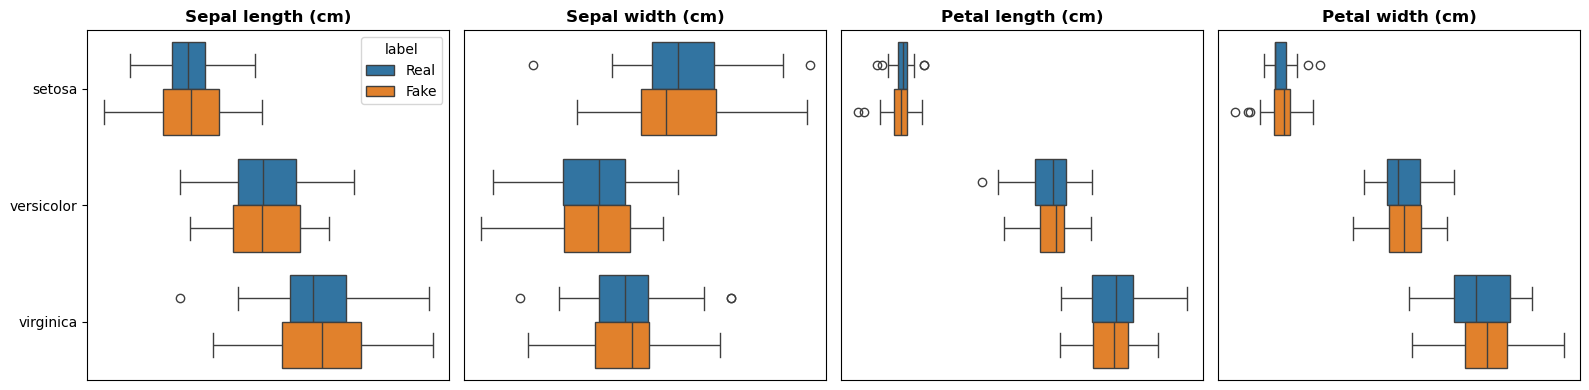

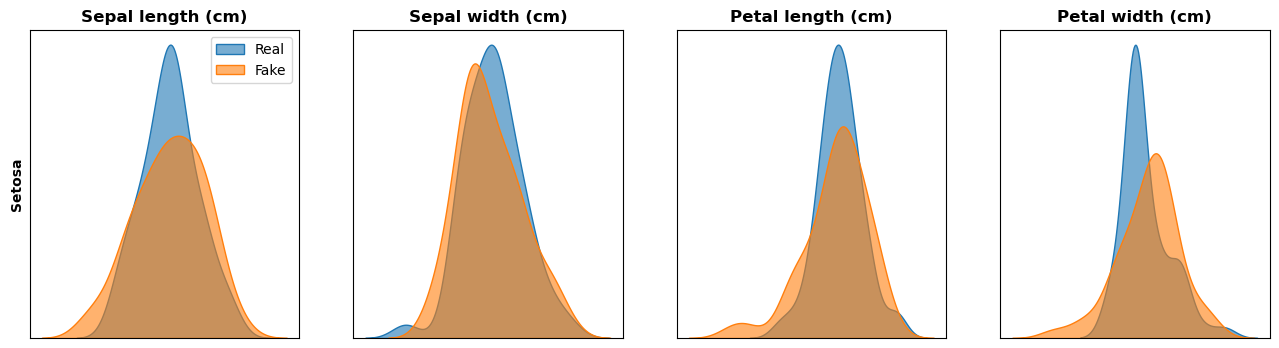

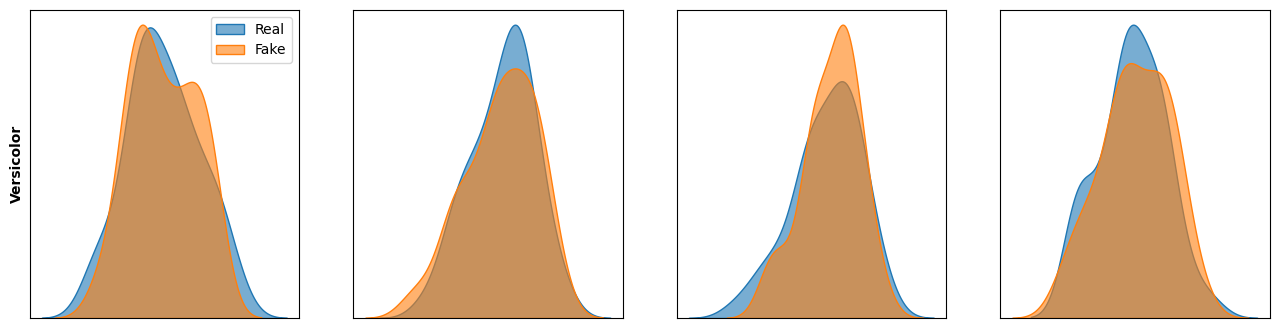

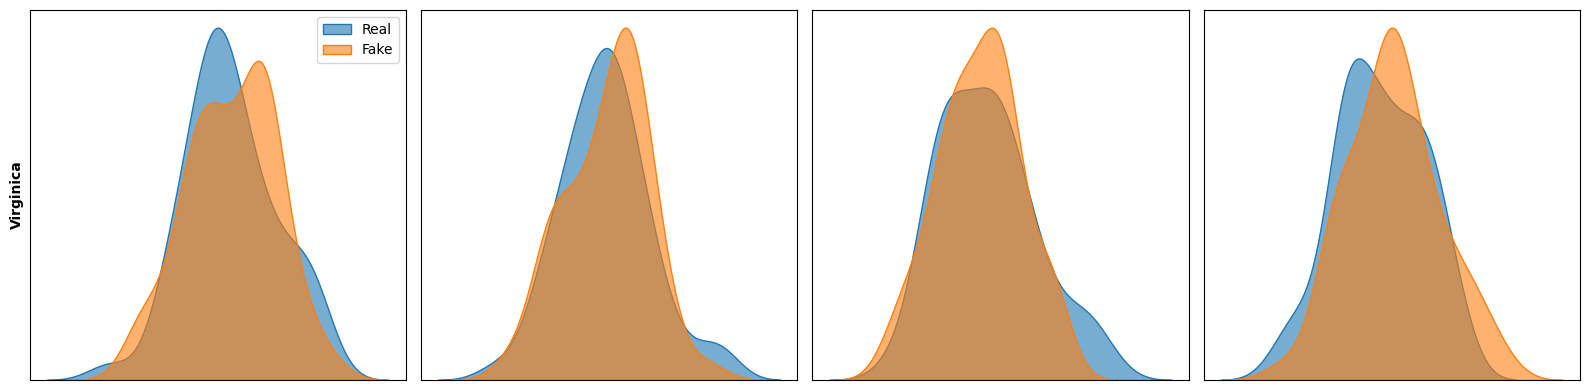

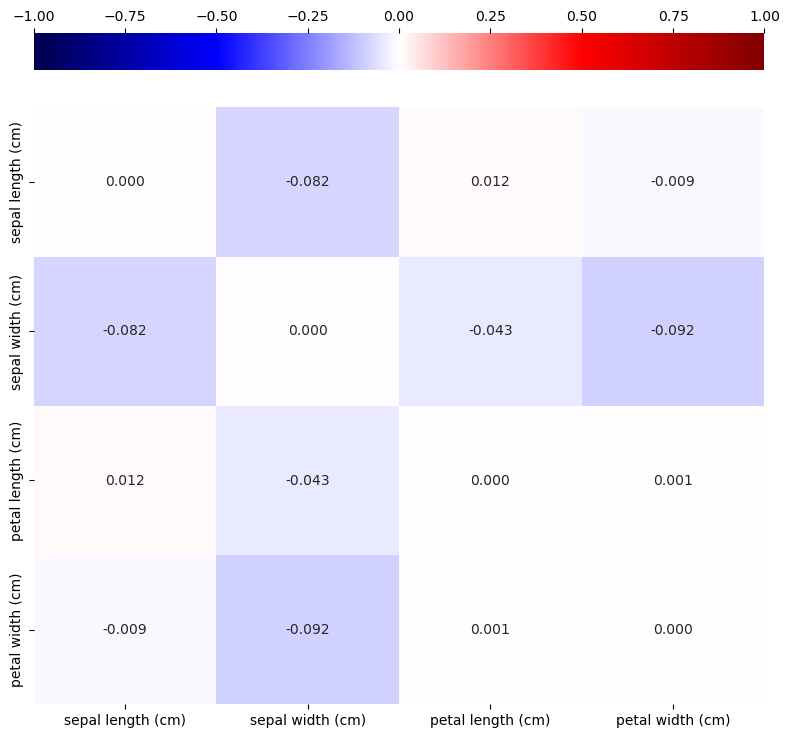

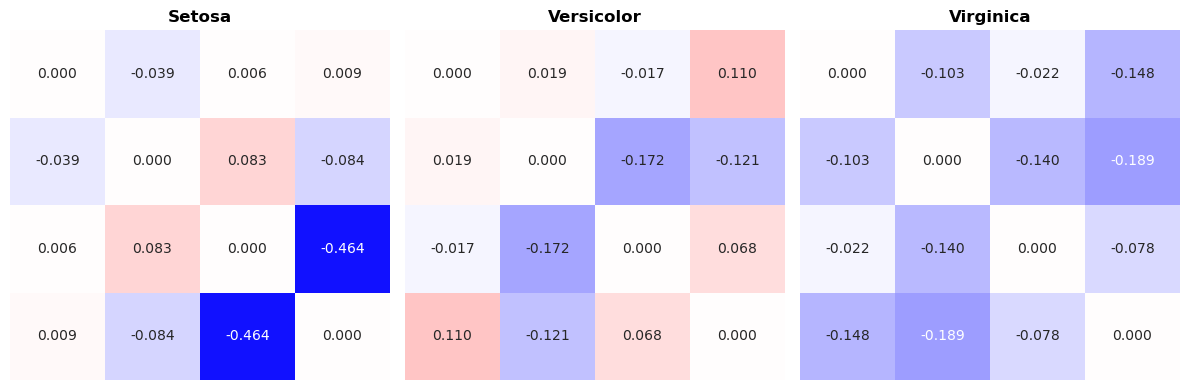

In [94]:
utils.plot_data(real_iris, 'target', fake_df)

In [95]:
print(f"Correlations difference: {((real_iris.select_dtypes('number').corr() - fake_df.select_dtypes('number').corr()).abs().sum().sum()):.4f}")
print(f"Correlations difference: {((real_iris.select_dtypes('number').corr() - fake_df.select_dtypes('number').corr()).abs().mean().mean()):.4f}")
print('\nClass corr diff:')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {((real_iris[real_iris['target'] == target].select_dtypes('number').corr() - fake_df[fake_df['target'] == target].select_dtypes('number').corr()).abs().sum().sum()):.4f}")
    print(f"{target.capitalize()}: {((real_iris[real_iris['target'] == target].select_dtypes('number').corr() - fake_df[fake_df['target'] == target].select_dtypes('number').corr()).abs().mean().mean()):.4f}")

Correlations difference: 0.4779
Correlations difference: 0.0299

Class corr diff:
Setosa: 1.3706
Setosa: 0.0857
Versicolor: 1.0156
Versicolor: 0.0635
Virginica: 1.3583
Virginica: 0.0849


In [96]:
print(f"Correlations difference: {((real_iris.select_dtypes('number').corr() - fake_df.select_dtypes('number').corr()).abs().sum().sum()):.4f}")
print('\nClass corr diff:')
for target in real_iris['target'].unique():
    print(f"{target.capitalize()}: {((real_iris[real_iris['target'] == target].select_dtypes('number').corr() - fake_df[fake_df['target'] == target].select_dtypes('number').corr()).abs().sum().sum()):.4f}")

Correlations difference: 0.4779

Class corr diff:
Setosa: 1.3706
Versicolor: 1.0156
Virginica: 1.3583


In [97]:
sum(p.numel() for p in crit.parameters())

1345